# Chapter 2

## Analysis of carbon limitation and refixation of respiratory CO2

In [2]:
# run functions.py to define functions for modifying and analysing model

%run ../functions.py

## Basic model setup

In [3]:

model_var = "../diel_plant_core_model.xml"


# define objective reaction
output_string = "AraCore_Biomass_tx"
objective_direction = "max"

# define suffices for day and night reactions and metabolites
day_tag = "_00"
night_tag = "_12"

charge_state_mets = False

In [4]:
# set solver for optimisation
solver = 'glpk'
cobra.core.Configuration.solver = solver


diel_model = cobra.io.read_sbml_model(model_var)
diel_model.solver

In [5]:
# photon flux constraints
diel_model.reactions.get_by_id("Photon_tx"+day_tag).upper_bound = 200
diel_model.reactions.get_by_id("Photon_tx"+night_tag).upper_bound = 0 #night-time darkness

# prevent phloem output reactions
diel_model.reactions.get_by_id("Phloem_output_tx"+day_tag).bounds = (0, 0)
diel_model.reactions.get_by_id("Phloem_output_tx"+night_tag).bounds = (0, 0)


# Rubisco C:O constraint = 3:1
set_Rubisco_C_to_O_ratio(diel_model, 3/1)


# output constraint day:night = 3:1
set_output_day_night_ratio(diel_model, 3/1, output_string)

# maintenance costs based on linear equation using light intensity, as in Toepfer et al., 2021
## maintenance day:night = 1:1

#light
PPFD = diel_model.reactions.get_by_id("Photon_tx"+day_tag).upper_bound
ATPase = (PPFD*0.0049)+2.7851

print("ATPase flux during the day: ", ATPase)

diel_model.reactions.get_by_id("ATPase_tx"+day_tag).bounds = (ATPase, ATPase)

#dark
print("ATPase flux at night: ", ATPase)
diel_model.reactions.get_by_id("ATPase_tx"+night_tag).bounds = (ATPase, ATPase)


# maintenance ATPase:NADPHoxidase = 3:1
set_NGAM_ATP_NADPH_ratio(diel_model, 3/1)
print("set maintenance ATPase:NADPHoxidase ratio to 3:1")


# nitrate day:night = 3:2
set_nitrate_uptake_day_night_ratio(diel_model, 3/2)
print("set nitrate uptake light:dark ratio to 3:2")


# amino acids accumulating day to night, not night to day
aa_day_to_night_only = True

amino_acids = ["ASN_v",
"SER_v",
"GLN_v",
"GLY_v",
"THR_v",
"L_ALPHA_ALANINE_v",
"VAL_v",
"ILE_v",
"PHE_v",
"LEU_v",
"LYS_v",
"ARG_v",
"L_ASPARTATE_v",
"GLT_v",
"HIS_v",
"MET_v",
"PRO_v",
"TRP_v",
"TYR_v",
"CYS_v"]#,
#"4_AMINO_BUTYRATE_v"]

if aa_day_to_night_only:

    for rxn in diel_model.reactions:
        if "_12_to_00" in rxn.id and rxn.id[:-16] in amino_acids:
            rxn.upper_bound = 0
            # print(rxn.id[:-16])
    print("set amino acid accumulation to day to night only")
else:
    pass

ATPase flux during the day:  3.7651
ATPase flux at night:  3.7651
set maintenance ATPase:NADPHoxidase ratio to 3:1
set nitrate uptake light:dark ratio to 3:2
set amino acid accumulation to day to night only


In [6]:
# set objective
diel_model.objective = {diel_model.reactions.get_by_id(output_string+"_total"): 1}
diel_model.objective_direction = objective_direction

print("Objective set to :",str(diel_model.objective_direction), output_string+"_total")


Objective set to : max AraCore_Biomass_tx_total


## Model results without CO2-constraint

In [7]:
C3_unlimited = diel_model.copy()


solution_C3_unlimited, C3_unlimited_opt = optimise_model(C3_unlimited, output_string+"_total", pFBA=True)

Objective: AraCore_Biomass_tx_total


In [8]:
model_results_overview(C3_unlimited_opt, solution_C3_unlimited, output_string+"_total")

Photon uptake = 200.0   % of allowed Photon uptake = 100.0
Output rate (AraCore_Biomass_tx_total) 0.1283		sum of fluxes: 1321.8213
gas exchange = Day: 12.39721 Night: -1.27822
CCE: 0.8968946656107852
ATPase: 3.7651 3.7651
Rubisco Carbox./Oxygen. = 14.7856/4.9285

Linker fluxes 		 Day 	 Night
VAL_v_linker                         0.0       0.0

NITRATE_v_linker                     0.0             0.39019

CIT_v_linker                         0.0             0.18446

PHE_v_linker                     0.00762       0.0

STARCH_p_linker                  0.64888                 0.0

LYS_v_linker                     0.00823       0.0

MET_v_linker                     0.00349       0.0

MAL_v_linker                         0.0                 0.0

CYS_v_linker                         0.0       0.0

4_AMINO_BUTYRATE_v_linker                 0.0             0.00927

L_ASPARTATE_v_linker                -0.0       0.0

L_ALPHA_ALANINE_v_linker                 0.0       0.0

FRU_v_linker            

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


In [9]:
for reaction in C3_unlimited_opt.boundary:
    print(reaction.id,"\t", round(reaction.flux,3))

Ca_tx_00 	 0.085
Photon_tx_00 	 200.0
H_tx_00 	 -1.252
Sucrose_tx_00 	 0.0
H2O_tx_00 	 10.922
CO2_tx_00 	 12.397
O2_tx_00 	 -15.392
Pi_tx_00 	 -0.0
Mg_tx_00 	 0.056
Nitrate_tx_00 	 0.585
SO4_tx_00 	 0.014
NH4_tx_00 	 0.0
K_tx_00 	 0.173
unlProtHYPO_c_00 	 0.0
GLC_tx_00 	 0.0
EX_charge_00 	 0.0
Ca_tx_12 	 0.028
Photon_tx_12 	 0.0
H_tx_12 	 0.63
Sucrose_tx_12 	 0.0
H2O_tx_12 	 -1.34
CO2_tx_12 	 -1.278
O2_tx_12 	 1.679
Pi_tx_12 	 -0.0
Mg_tx_12 	 0.019
Nitrate_tx_12 	 0.39
SO4_tx_12 	 0.0
NH4_tx_12 	 0.0
K_tx_12 	 0.058
unlProtHYPO_c_12 	 0.0
GLC_tx_12 	 0.0
EX_charge_12 	 0.0
AraCore_Biomass_tx_total 	 0.128
Phloem_output_tx_mod_total 	 0.0


solution_C3_unlimited (results 15/04/2025):

- light-limited (100% photo use = 200 PPFD)
- objective flux (AraCore biomass):0.1283
- citrate accumulation = 0.1845 night to day
- malate accumulation = 0 either direction
- nocturnal CO2 refixation = 35.77%
- total carbon use efficiency = 89.69%

### check higher NGAM costs

In [10]:
C3_unlimited_NGAM_high = diel_model.copy()

NGAM = 8.5

C3_unlimited_NGAM_high.reactions.ATPase_tx_00.bounds = (NGAM, NGAM)
C3_unlimited_NGAM_high.reactions.ATPase_tx_12.bounds = (NGAM, NGAM)


solution_C3_unlimited_NGAM_high, C3_unlimited_NGAM_high_opt = optimise_model(C3_unlimited_NGAM_high, output_string+"_total", pFBA=True)


calc_carbon_flux(C3_unlimited_NGAM_high_opt, output_string="AraCore_Biomass_tx", night_tag = "_12")


Objective: AraCore_Biomass_tx_total
CO2 daytime exchange: 11.947500713156622
CO2 nightime exchange: -2.7562518964113716
CO2 respiratory losses: 0 (no CO2_m_00 found)
Carbon day to night: 5.999610318429513
Carbon night to day: 0.9455462178318305
CO2 exchange night:day: 0.15760127202383725
AraCore_Biomass_tx_00 carbon flux: -6.893436612558848
AraCore_Biomass_tx_12 carbon flux: -2.297812204186282
total carbon biomass flux: -9.19124881674513
total CCE: 0.7693030565483725
nCO2RC: 0.23943640757645257
night CCE1 (carbon in to biomass): 0.38299357495400943
night CCE2 (1 - (carbon lost / carbon in)): 0.5405948469778514


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


,value
CO2 daytime exchange,11.947501
CO2 nightime exchange,-2.756252
Carbon day to night,5.999610
Carbon night to day,0.945546
CO2 exchange night:day,0.157601
day carbon biomass flux,6.893437
night carbon biomass flux,2.297812
total Carbon biomass flux,9.191249
total CCE,0.769303
nCO2RC,0.239436


In [69]:


model = C3_unlimited_NGAM_high.copy()
model.reactions.ATPase_tx_00.bounds = (0, 1000)
model.reactions.ATPase_tx_12.bounds = (0, 1000)

ATPase_day_night_equal = model.problem.Constraint(
                            (model.reactions.ATPase_tx_00.flux_expression) -
                            (model.reactions.ATPase_tx_12.flux_expression) , 
                            lb = 0,
                            ub= 0,
                            name= "ATPase_day_night_equal")
model.add_cons_vars(ATPase_day_night_equal)

df_NGAM_scan, NGAM_scan_sols = parameter_scan_CO2(model, output_string+"_total", "ATPase_tx_00", 0, 10.5, 0.5, pFBA=True, CO2_refixation_allowed=True, verbose=True, scan_ub_and_lb=True)

Scanning process: ATPase_tx_00 

------- Scan iteration: 1      Scan value: 0.0 (ATPase_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1455171
----- Cytosol -----
producing CO2:	CO2_pc_12	0.358987
consuming CO2:	ISOCITDEH_RXN_c_12	-0.002866
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.041288
producing CO2:	GLUTDECARBOX_RXN_c_12	0.014022
producing CO2:	CO2_mc_12	0.168739
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.028054
producing CO2:	RXN_9650_p_12	0.028054
producing CO2:	RXN_5682_p_12	0.006017
producing CO2:	2.3.1.180_RXN_p_12	0.028054
producing CO2:	RXN_9654_p_12	0.028054
consuming CO2:	RXN0_5224_p_12	0.196378
producing HCO3-:	RXN0_5224_p_12	0.196378
consuming CO2:	CO2_pc_12	0.358987
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.196378
producing CO2:	PYRUVDEH_RXN_p_12	0.205065
producing CO2:	RXN_9653_p_12	0.028054
producing CO2:	RXN_7800_p_12	0.013075
producing CO2:	RXN_9651_p_12	0.028054
producing CO2:	RXN_

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 2      Scan value: 0.5 (ATPase_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.143365
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.038261
producing HCO3-:	RXN0_5224_c_12	0.038261
producing CO2:	CO2_pc_12	0.408254
producing CO2:	ISOCITDEH_RXN_c_12	0.003233
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.040678
producing CO2:	GLUTDECARBOX_RXN_c_12	0.013815
producing CO2:	CO2_mc_12	0.190655
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.021786
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.038261
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005928
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.027639
producing CO2:	RXN_9650_p_12	0.027639
producing CO2:	2.3.1.180_RXN_p_12	0.027639
producing CO2:	RXN_9654_p_12	0.027639
consuming CO2:	RXN0_5224_p_12	0.193473
producing HCO3-:	RXN0_5224_p_12	0.193473
consuming CO2:	CO2_pc_12	0.408254
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.193473
producing

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 3      Scan value: 1.0 (ATPase_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1411479
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.11062
producing HCO3-:	RXN0_5224_c_12	0.11062
producing CO2:	CO2_pc_12	0.430148
consuming CO2:	ISOCITDEH_RXN_c_12	-0.053232
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.040049
producing CO2:	GLUTDECARBOX_RXN_c_12	0.013601
producing CO2:	CO2_mc_12	0.292755
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.077863
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.11062
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005837
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.027212
producing CO2:	RXN_9650_p_12	0.027212
producing CO2:	2.3.1.180_RXN_p_12	0.027212
producing CO2:	RXN_9654_p_12	0.027212
consuming CO2:	RXN0_5224_p_12	0.190482
producing HCO3-:	RXN0_5224_p_12	0.190482
consuming CO2:	CO2_pc_12	0.430148
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.190482
producing 

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 4      Scan value: 1.5 (ATPase_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1388726
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.182992
producing HCO3-:	RXN0_5224_c_12	0.182992
producing CO2:	CO2_pc_12	0.451887
consuming CO2:	ISOCITDEH_RXN_c_12	-0.109721
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.039403
producing CO2:	GLUTDECARBOX_RXN_c_12	0.013382
producing CO2:	CO2_mc_12	0.394819
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.133955
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.182992
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005743
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.026773
producing CO2:	RXN_9650_p_12	0.026773
producing CO2:	2.3.1.180_RXN_p_12	0.026773
producing CO2:	RXN_9654_p_12	0.026773
consuming CO2:	RXN0_5224_p_12	0.187411
producing HCO3-:	RXN0_5224_p_12	0.187411
consuming CO2:	CO2_pc_12	0.451887
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.187411
produci

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 5      Scan value: 2.0 (ATPase_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1365855
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.251588
producing HCO3-:	RXN0_5224_c_12	0.251588
producing CO2:	CO2_pc_12	0.47569
consuming CO2:	ISOCITDEH_RXN_c_12	-0.159606
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.038754
producing CO2:	GLUTDECARBOX_RXN_c_12	0.013161
producing CO2:	CO2_mc_12	0.496785
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.186745
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.251588
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005648
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.026332
producing CO2:	RXN_9650_p_12	0.026332
producing CO2:	2.3.1.180_RXN_p_12	0.026332
producing CO2:	RXN_9654_p_12	0.026332
consuming CO2:	RXN0_5224_p_12	0.184324
producing HCO3-:	RXN0_5224_p_12	0.184324
consuming CO2:	CO2_pc_12	0.47569
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.184324
producing

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 6      Scan value: 2.5 (ATPase_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1342459
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.261418
producing HCO3-:	RXN0_5224_c_12	0.261418
producing CO2:	CO2_pc_12	0.497222
consuming CO2:	ISOCITDEH_RXN_c_12	-0.187954
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.03809
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012936
producing CO2:	CO2_mc_12	0.604199
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.228768
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.261418
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005551
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.025881
producing CO2:	RXN_9650_p_12	0.025881
producing CO2:	2.3.1.180_RXN_p_12	0.025881
producing CO2:	RXN_9654_p_12	0.025881
consuming CO2:	RXN0_5224_p_12	0.181167
producing HCO3-:	RXN0_5224_p_12	0.181167
consuming CO2:	CO2_pc_12	0.497222
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.181167
producin

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 7      Scan value: 3.0 (ATPase_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1319062
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.271249
producing HCO3-:	RXN0_5224_c_12	0.271249
producing CO2:	CO2_pc_12	0.518755
consuming CO2:	ISOCITDEH_RXN_c_12	-0.216301
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.037426
producing CO2:	GLUTDECARBOX_RXN_c_12	0.01271
producing CO2:	CO2_mc_12	0.711612
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.270791
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.271249
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005454
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02543
producing CO2:	RXN_9650_p_12	0.02543
producing CO2:	2.3.1.180_RXN_p_12	0.02543
producing CO2:	RXN_9654_p_12	0.02543
consuming CO2:	RXN0_5224_p_12	0.17801
producing HCO3-:	RXN0_5224_p_12	0.17801
consuming CO2:	CO2_pc_12	0.518755
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.17801
producing CO2:	

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 8      Scan value: 3.5 (ATPase_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1295666
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.278118
producing HCO3-:	RXN0_5224_c_12	0.278118
producing CO2:	CO2_pc_12	0.540288
consuming CO2:	ISOCITDEH_RXN_c_12	-0.244567
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036763
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012485
producing CO2:	CO2_mc_12	0.819189
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.312773
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.278118
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005358
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.024979
producing CO2:	RXN_9650_p_12	0.024979
producing CO2:	2.3.1.180_RXN_p_12	0.024979
producing CO2:	RXN_9654_p_12	0.024979
consuming CO2:	RXN0_5224_p_12	0.174852
producing HCO3-:	RXN0_5224_p_12	0.174852
consuming CO2:	CO2_pc_12	0.540288
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.174852
produci

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 9      Scan value: 4.0 (ATPase_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1272261
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.277914
producing HCO3-:	RXN0_5224_c_12	0.277914
producing CO2:	CO2_pc_12	0.565883
consuming CO2:	ISOCITDEH_RXN_c_12	-0.274182
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036099
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012259
producing CO2:	CO2_mc_12	0.924067
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.353398
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.277914
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005261
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.024528
producing CO2:	RXN_9650_p_12	0.024528
producing CO2:	2.3.1.180_RXN_p_12	0.024528
producing CO2:	RXN_9654_p_12	0.024528
consuming CO2:	RXN0_5224_p_12	0.171694
producing HCO3-:	RXN0_5224_p_12	0.171694
consuming CO2:	CO2_pc_12	0.565883
producing CO2:	1.2.1.2_RXN_p_12	0.004065
consuming HCO3-:	ACETYL_COA_C

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 10      Scan value: 4.5 (ATPase_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1248763
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.272781
producing HCO3-:	RXN0_5224_c_12	0.272781
producing CO2:	CO2_pc_12	0.587313
consuming CO2:	ISOCITDEH_RXN_c_12	-0.298477
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.035432
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012033
producing CO2:	CO2_mc_12	1.039575
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.393432
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.272781
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005164
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.024075
producing CO2:	RXN_9650_p_12	0.024075
producing CO2:	2.3.1.180_RXN_p_12	0.024075
producing CO2:	RXN_9654_p_12	0.024075
consuming CO2:	RXN0_5224_p_12	0.168523
producing HCO3-:	RXN0_5224_p_12	0.168523
consuming CO2:	CO2_pc_12	0.587313
producing CO2:	1.2.1.2_RXN_p_12	0.003989
consuming HCO3-:	ACETYL_COA_

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 11      Scan value: 5.0 (ATPase_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1225265
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.267648
producing HCO3-:	RXN0_5224_c_12	0.267648
producing CO2:	CO2_pc_12	0.608744
consuming CO2:	ISOCITDEH_RXN_c_12	-0.322772
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.034765
producing CO2:	GLUTDECARBOX_RXN_c_12	0.011807
producing CO2:	CO2_mc_12	1.155082
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.433467
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.267648
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005067
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.023622
producing CO2:	RXN_9650_p_12	0.023622
producing CO2:	2.3.1.180_RXN_p_12	0.023622
producing CO2:	RXN_9654_p_12	0.023622
consuming CO2:	RXN0_5224_p_12	0.165351
producing HCO3-:	RXN0_5224_p_12	0.165351
consuming CO2:	CO2_pc_12	0.608744
producing CO2:	1.2.1.2_RXN_p_12	0.003914
consuming HCO3-:	ACETYL_COA_

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 12      Scan value: 5.5 (ATPase_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1201766
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.262515
producing HCO3-:	RXN0_5224_c_12	0.262515
producing CO2:	CO2_pc_12	0.630174
consuming CO2:	ISOCITDEH_RXN_c_12	-0.347067
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.034098
producing CO2:	GLUTDECARBOX_RXN_c_12	0.01158
producing CO2:	CO2_mc_12	1.270589
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.473501
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.262515
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.004969
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.023169
producing CO2:	RXN_9650_p_12	0.023169
producing CO2:	2.3.1.180_RXN_p_12	0.023169
producing CO2:	RXN_9654_p_12	0.023169
consuming CO2:	RXN0_5224_p_12	0.16218
producing HCO3-:	RXN0_5224_p_12	0.16218
consuming CO2:	CO2_pc_12	0.630174
producing CO2:	1.2.1.2_RXN_p_12	0.003839
consuming HCO3-:	ACETYL_COA_CAR

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 13      Scan value: 6.0 (ATPase_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1178268
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.257382
producing HCO3-:	RXN0_5224_c_12	0.257382
producing CO2:	CO2_pc_12	0.651605
consuming CO2:	ISOCITDEH_RXN_c_12	-0.371362
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.033432
producing CO2:	GLUTDECARBOX_RXN_c_12	0.011354
producing CO2:	CO2_mc_12	1.386097
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.513536
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.257382
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.004872
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.022716
producing CO2:	RXN_9650_p_12	0.022716
producing CO2:	2.3.1.180_RXN_p_12	0.022716
producing CO2:	RXN_9654_p_12	0.022716
consuming CO2:	RXN0_5224_p_12	0.159009
producing HCO3-:	RXN0_5224_p_12	0.159009
consuming CO2:	CO2_pc_12	0.651605
producing CO2:	1.2.1.2_RXN_p_12	0.003764
consuming HCO3-:	ACETYL_COA_

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 14      Scan value: 6.5 (ATPase_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.115477
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.252249
producing HCO3-:	RXN0_5224_c_12	0.252249
producing CO2:	CO2_pc_12	0.673035
consuming CO2:	ISOCITDEH_RXN_c_12	-0.395657
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.032765
producing CO2:	GLUTDECARBOX_RXN_c_12	0.011127
producing CO2:	CO2_mc_12	1.501604
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.55357
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.252249
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.004775
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.022263
producing CO2:	RXN_9650_p_12	0.022263
producing CO2:	2.3.1.180_RXN_p_12	0.022263
producing CO2:	RXN_9654_p_12	0.022263
consuming CO2:	RXN0_5224_p_12	0.155838
producing HCO3-:	RXN0_5224_p_12	0.155838
consuming CO2:	CO2_pc_12	0.673035
producing CO2:	1.2.1.2_RXN_p_12	0.003689
consuming HCO3-:	ACETYL_COA_CA

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 15      Scan value: 7.0 (ATPase_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1131271
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.247116
producing HCO3-:	RXN0_5224_c_12	0.247116
producing CO2:	CO2_pc_12	0.694466
consuming CO2:	ISOCITDEH_RXN_c_12	-0.419952
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.032098
producing CO2:	GLUTDECARBOX_RXN_c_12	0.010901
producing CO2:	CO2_mc_12	1.617112
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.593605
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.247116
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.004678
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02181
producing CO2:	RXN_9650_p_12	0.02181
producing CO2:	2.3.1.180_RXN_p_12	0.02181
producing CO2:	RXN_9654_p_12	0.02181
consuming CO2:	RXN0_5224_p_12	0.152667
producing HCO3-:	RXN0_5224_p_12	0.152667
consuming CO2:	CO2_pc_12	0.694466
producing CO2:	1.2.1.2_RXN_p_12	0.003614
consuming HCO3-:	ACETYL_COA_CARB

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 16      Scan value: 7.5 (ATPase_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1107773
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.241983
producing HCO3-:	RXN0_5224_c_12	0.241983
producing CO2:	CO2_pc_12	0.715896
consuming CO2:	ISOCITDEH_RXN_c_12	-0.444247
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.031431
producing CO2:	GLUTDECARBOX_RXN_c_12	0.010674
producing CO2:	CO2_mc_12	1.732619
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.63364
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.241983
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.004581
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.021357
producing CO2:	RXN_9650_p_12	0.021357
producing CO2:	2.3.1.180_RXN_p_12	0.021357
producing CO2:	RXN_9654_p_12	0.021357
consuming CO2:	RXN0_5224_p_12	0.149496
producing HCO3-:	RXN0_5224_p_12	0.149496
consuming CO2:	CO2_pc_12	0.715896
producing CO2:	1.2.1.2_RXN_p_12	0.003539
consuming HCO3-:	ACETYL_COA_C

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 17      Scan value: 8.0 (ATPase_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1084275
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.23685
producing HCO3-:	RXN0_5224_c_12	0.23685
producing CO2:	CO2_pc_12	0.737327
consuming CO2:	ISOCITDEH_RXN_c_12	-0.468542
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.030765
producing CO2:	GLUTDECARBOX_RXN_c_12	0.010448
producing CO2:	CO2_mc_12	1.848127
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.673674
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.23685
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.004484
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.020904
producing CO2:	RXN_9650_p_12	0.020904
producing CO2:	2.3.1.180_RXN_p_12	0.020904
producing CO2:	RXN_9654_p_12	0.020904
consuming CO2:	RXN0_5224_p_12	0.146325
producing HCO3-:	RXN0_5224_p_12	0.146325
consuming CO2:	CO2_pc_12	0.737327
producing CO2:	1.2.1.2_RXN_p_12	0.003464
consuming HCO3-:	ACETYL_COA_CAR

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 18      Scan value: 8.5 (ATPase_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1060777
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.231717
producing HCO3-:	RXN0_5224_c_12	0.231717
producing CO2:	CO2_pc_12	0.755368
consuming CO2:	ISOCITDEH_RXN_c_12	-0.492837
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.030098
producing CO2:	GLUTDECARBOX_RXN_c_12	0.010222
producing CO2:	CO2_mc_12	1.967023
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.713709
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.231717
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.004386
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.020451
producing CO2:	RXN_9650_p_12	0.020451
producing CO2:	2.3.1.180_RXN_p_12	0.020451
producing CO2:	RXN_9654_p_12	0.020451
consuming CO2:	RXN0_5224_p_12	0.143154
producing HCO3-:	RXN0_5224_p_12	0.143154
consuming CO2:	CO2_pc_12	0.755368
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.143154
produc

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 19      Scan value: 9.0 (ATPase_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1037278
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.226584
producing HCO3-:	RXN0_5224_c_12	0.226584
producing CO2:	CO2_pc_12	0.780188
consuming CO2:	ISOCITDEH_RXN_c_12	-0.517132
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.029431
producing CO2:	GLUTDECARBOX_RXN_c_12	0.009995
producing CO2:	CO2_mc_12	2.079142
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.753743
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.226584
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.004289
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.019997
producing CO2:	RXN_9650_p_12	0.019997
producing CO2:	2.3.1.180_RXN_p_12	0.019997
producing CO2:	RXN_9654_p_12	0.019997
consuming CO2:	RXN0_5224_p_12	0.139982
producing HCO3-:	RXN0_5224_p_12	0.139982
consuming CO2:	CO2_pc_12	0.780188
producing CO2:	1.2.1.2_RXN_p_12	0.003314
consuming HCO3-:	ACETYL_COA_

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 20      Scan value: 9.5 (ATPase_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.101378
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.221451
producing HCO3-:	RXN0_5224_c_12	0.221451
producing CO2:	CO2_pc_12	0.801618
consuming CO2:	ISOCITDEH_RXN_c_12	-0.541428
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.028765
producing CO2:	GLUTDECARBOX_RXN_c_12	0.009769
producing CO2:	CO2_mc_12	2.194649
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.793778
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.221451
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.004192
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.019544
producing CO2:	RXN_9650_p_12	0.019544
producing CO2:	2.3.1.180_RXN_p_12	0.019544
producing CO2:	RXN_9654_p_12	0.019544
consuming CO2:	RXN0_5224_p_12	0.136811
producing HCO3-:	RXN0_5224_p_12	0.136811
consuming CO2:	CO2_pc_12	0.801618
producing CO2:	1.2.1.2_RXN_p_12	0.003239
consuming HCO3-:	ACETYL_COA_C

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 21      Scan value: 10.0 (ATPase_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0990282
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.216318
producing HCO3-:	RXN0_5224_c_12	0.216318
producing CO2:	CO2_pc_12	0.823049
consuming CO2:	ISOCITDEH_RXN_c_12	-0.565723
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.028098
producing CO2:	GLUTDECARBOX_RXN_c_12	0.009542
producing CO2:	CO2_mc_12	2.310157
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.833812
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.216318
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.004095
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.019091
producing CO2:	RXN_9650_p_12	0.019091
producing CO2:	2.3.1.180_RXN_p_12	0.019091
producing CO2:	RXN_9654_p_12	0.019091
consuming CO2:	RXN0_5224_p_12	0.13364
producing HCO3-:	RXN0_5224_p_12	0.13364
consuming CO2:	CO2_pc_12	0.823049
producing CO2:	1.2.1.2_RXN_p_12	0.003164
consuming HCO3-:	ACETYL_COA_C

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


In [70]:
df_NGAM_scan

,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,...,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0
reactions,,,,,,,,,,,,,,,,,,,,,
PRO_PROTON_vc_00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ca_tx_00,0.096041,0.094621,0.093158,0.091656,0.090146,0.088602,0.087058,0.085514,0.083969,0.082418,...,0.079317,0.077766,0.076215,0.074664,0.073113,0.071562,0.070011,0.068460,0.066909,0.065359
H2O_xc_00,4.684809,4.772303,4.858797,4.943416,5.005459,4.983617,4.961774,4.940012,4.918498,4.900319,...,4.863960,4.845781,4.827601,4.809422,4.791243,4.773063,4.754884,4.736705,4.718525,4.700346
sCIT_biomass_00,-0.028782,-0.028356,-0.027918,-0.027468,-0.027015,-0.026553,-0.026090,-0.025627,-0.025164,-0.024699,...,-0.023770,-0.023305,-0.022840,-0.022375,-0.021911,-0.021446,-0.020981,-0.020516,-0.020052,-0.019587
ACETYLGLUTKIN_RXN_p_00,0.036191,0.035656,0.035105,0.034539,0.033970,0.033388,0.032806,0.032224,0.031642,0.031058,...,0.029889,0.029305,0.028720,0.028136,0.027551,0.026967,0.026382,0.025798,0.025214,0.024629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
daytime CO2 uptake ub,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
scan process ub,0.000000,0.500000,1.000000,1.500000,2.000000,2.500000,3.000000,3.500000,4.000000,4.500000,...,5.500000,6.000000,6.500000,7.000000,7.500000,8.000000,8.500000,9.000000,9.500000,10.000000
total aa day,0.250583,0.246877,0.243059,0.239141,0.226863,0.222977,0.219091,0.218207,0.219086,0.215039,...,0.206946,0.202900,0.198853,0.194807,0.190760,0.186714,0.182668,0.178621,0.174575,0.170528


In [71]:
# Convert column names to integers if they are numeric and end in .0
df_NGAM_scan.columns = [
    int(float(col)) if isinstance(col, str) and col.replace('.', '', 1).isdigit() and float(col).is_integer() else col
    for col in df_NGAM_scan.columns
]

# Display the updated DataFrame
df_NGAM_scan

,0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,...,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10
reactions,,,,,,,,,,,,,,,,,,,,,
PRO_PROTON_vc_00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ca_tx_00,0.096041,0.094621,0.093158,0.091656,0.090146,0.088602,0.087058,0.085514,0.083969,0.082418,...,0.079317,0.077766,0.076215,0.074664,0.073113,0.071562,0.070011,0.068460,0.066909,0.065359
H2O_xc_00,4.684809,4.772303,4.858797,4.943416,5.005459,4.983617,4.961774,4.940012,4.918498,4.900319,...,4.863960,4.845781,4.827601,4.809422,4.791243,4.773063,4.754884,4.736705,4.718525,4.700346
sCIT_biomass_00,-0.028782,-0.028356,-0.027918,-0.027468,-0.027015,-0.026553,-0.026090,-0.025627,-0.025164,-0.024699,...,-0.023770,-0.023305,-0.022840,-0.022375,-0.021911,-0.021446,-0.020981,-0.020516,-0.020052,-0.019587
ACETYLGLUTKIN_RXN_p_00,0.036191,0.035656,0.035105,0.034539,0.033970,0.033388,0.032806,0.032224,0.031642,0.031058,...,0.029889,0.029305,0.028720,0.028136,0.027551,0.026967,0.026382,0.025798,0.025214,0.024629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
daytime CO2 uptake ub,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
scan process ub,0.000000,0.500000,1.000000,1.500000,2.000000,2.500000,3.000000,3.500000,4.000000,4.500000,...,5.500000,6.000000,6.500000,7.000000,7.500000,8.000000,8.500000,9.000000,9.500000,10.000000
total aa day,0.250583,0.246877,0.243059,0.239141,0.226863,0.222977,0.219091,0.218207,0.219086,0.215039,...,0.206946,0.202900,0.198853,0.194807,0.190760,0.186714,0.182668,0.178621,0.174575,0.170528


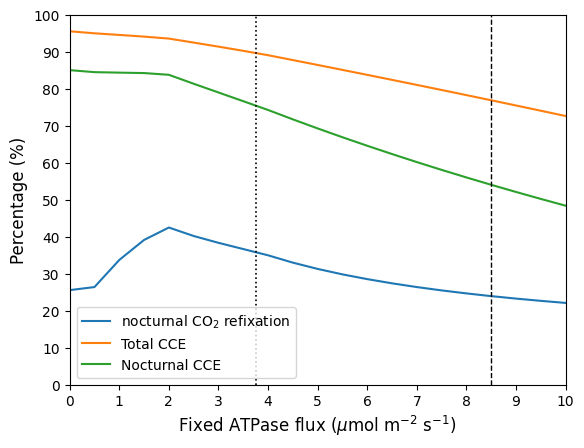

In [82]:
df =df_NGAM_scan

# Get the x-values from the plot
x_values = df_NGAM_scan.columns.astype(float)

# Find the x-value closest to set ATPase fluxes in models
ATPase_1 = 3.7651 #my value for NGAM (ATPase flux) from light intensity
ATPase_2 = 8.5 # Shameer et al., 2018 values for NGAM (ATPase flux)
closest_x1 = ATPase_1*2
closest_x2 = ATPase_2*2

biomass_max = df.T["AraCore_Biomass_tx_total"].max()


# Plot the data
plt.plot(df.T["noct. CO2 coeff."]*100, label="nocturnal CO$_2$ refixation")
plt.plot(df.T["CCE"]*100, label="Total CCE")
plt.plot(df.T["nighttime CCE"]*100, label="Nocturnal CCE")
# plt.plot(df.T["AraCore_Biomass_tx_total"]/biomass_max*100, label="Biomass")

# Add labels and title
plt.xlabel("Fixed ATPase flux ($\mu$mol m$^{-2}$ s$^{-1}$)", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
# plt.title("Increasing NGAM costs decreases CCE (Biomass objective)")

# Set x-axis ticks in increments of 1
plt.xticks(ticks=range(0, 11, 1))  # Assuming the x-axis range is 0 to 10


# Set y-axis limits and y-axis tick marks
plt.ylim(0, 100)
plt.yticks(range(0, 101, 10))

plt.xlim(0, 10)


# Add a vertical line at mine and Shameer et al., 2018's ATPase flux value
plt.axvline(x=3.7651, linestyle='dotted', color = 'black', linewidth=1.2)
plt.axvline(x=8.5, linestyle='--', color = 'black', linewidth=1)



plt.legend()

# Show the plot
plt.savefig("Ch1_NGAM_scan.png", dpi=300, bbox_inches='tight')
plt.show()



In [14]:
df_NGAM_scan

,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,...,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0
reactions,,,,,,,,,,,,,,,,,,,,,
PRO_PROTON_vc_00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ca_tx_00,0.096041,0.094621,0.093158,0.091656,0.090146,0.088602,0.087058,0.085514,0.083969,0.082418,...,0.079317,0.077766,0.076215,0.074664,0.073113,0.071562,0.070011,0.068460,0.066909,0.065359
H2O_xc_00,4.684809,4.772303,4.858797,4.943416,5.005459,4.983617,4.961774,4.940012,4.918498,4.900319,...,4.863960,4.845781,4.827601,4.809422,4.791243,4.773063,4.754884,4.736705,4.718525,4.700346
sCIT_biomass_00,-0.028782,-0.028356,-0.027918,-0.027468,-0.027015,-0.026553,-0.026090,-0.025627,-0.025164,-0.024699,...,-0.023770,-0.023305,-0.022840,-0.022375,-0.021911,-0.021446,-0.020981,-0.020516,-0.020052,-0.019587
ACETYLGLUTKIN_RXN_p_00,0.036191,0.035656,0.035105,0.034539,0.033970,0.033388,0.032806,0.032224,0.031642,0.031058,...,0.029889,0.029305,0.028720,0.028136,0.027551,0.026967,0.026382,0.025798,0.025214,0.024629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
daytime CO2 uptake ub,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
scan process ub,0.000000,0.500000,1.000000,1.500000,2.000000,2.500000,3.000000,3.500000,4.000000,4.500000,...,5.500000,6.000000,6.500000,7.000000,7.500000,8.000000,8.500000,9.000000,9.500000,10.000000
total aa day,0.250583,0.246877,0.243059,0.239141,0.226863,0.222977,0.219091,0.218207,0.219086,0.215039,...,0.206946,0.202900,0.198853,0.194807,0.190760,0.186714,0.182668,0.178621,0.174575,0.170528


### check phloem output as objective

In [15]:
model = diel_model.copy()

#define phloem output reaction
phloem_output_string = "Phloem_output_tx_mod"

phloem_day = Reaction(phloem_output_string+day_tag, name = "Phloem output reaction_day")
phloem_night = Reaction(phloem_output_string+night_tag, name = "Phloem output reaction_night")


# phloem output reaction equation from Shameer et al., 2018 for C3 plants (tomato)

phloem_day.add_metabolites({model.metabolites.get_by_id("4_AMINO_BUTYRATE_c_00"): -0.0022970297,
                                model.metabolites.get_by_id("ARG_c_00"): -0.0004186704,
                                model.metabolites.get_by_id("ASN_c_00"): -0.0015049505,
                                model.metabolites.get_by_id("CYS_c_00"): -0.0004186704,
                                model.metabolites.get_by_id("FRU_c_00"): -0.0792079208,
                                model.metabolites.get_by_id("GLC_c_00"): -0.0693069307,
                                model.metabolites.get_by_id("GLN_c_00"): -0.0240792079,
                                model.metabolites.get_by_id("GLT_c_00"): -0.0124356436,
                                model.metabolites.get_by_id("GLY_c_00"): -0.0007128713,
                                model.metabolites.get_by_id("HIS_c_00"): -0.0004186704,
                                model.metabolites.get_by_id("ILE_c_00"): -0.0017425743,
                                model.metabolites.get_by_id("LEU_c_00"): -0.0020594059,
                                model.metabolites.get_by_id("LYS_c_00"): -0.0022178218,
                                model.metabolites.get_by_id("L_ALPHA_ALANINE_c_00"): -0.0038811881,
                                model.metabolites.get_by_id("L_ASPARTATE_c_00"): -0.006019802,
                                model.metabolites.get_by_id("MET_c_00"): -0.0004186704,
                                model.metabolites.get_by_id("PHE_c_00"): -0.0057029703,
                                model.metabolites.get_by_id("PROTON_e_00"): -0.9603960396,
                                model.metabolites.get_by_id("PRO_c_00"): -0.0004186704,
                                model.metabolites.get_by_id("SER_c_00"): -0.003960396,
                                model.metabolites.get_by_id("THR_c_00"): -0.0068910891,
                                model.metabolites.get_by_id("TRP_c_00"): -0.0004186704,
                                model.metabolites.get_by_id("TYR_c_00"): -0.0004186704,
                                model.metabolites.get_by_id("VAL_c_00"): -0.0027722772,
                                model.metabolites.get_by_id("sSUCROSE_b_00"): -0.7326732673,
                                model.metabolites.get_by_id("PROTON_c_00"): 0.9603960396})

phloem_night.add_metabolites({model.metabolites.get_by_id("4_AMINO_BUTYRATE_c_12"): -0.0022970297,
                                model.metabolites.get_by_id("ARG_c_12"): -0.0004186704,
                                model.metabolites.get_by_id("ASN_c_12"): -0.0015049505,
                                model.metabolites.get_by_id("CYS_c_12"): -0.0004186704,
                                model.metabolites.get_by_id("FRU_c_12"): -0.0792079208,
                                model.metabolites.get_by_id("GLC_c_12"): -0.0693069307,
                                model.metabolites.get_by_id("GLN_c_12"): -0.0240792079,
                                model.metabolites.get_by_id("GLT_c_12"): -0.0124356436,
                                model.metabolites.get_by_id("GLY_c_12"): -0.0007128713,
                                model.metabolites.get_by_id("HIS_c_12"): -0.0004186704,
                                model.metabolites.get_by_id("ILE_c_12"): -0.0017425743,
                                model.metabolites.get_by_id("LEU_c_12"): -0.0020594059,
                                model.metabolites.get_by_id("LYS_c_12"): -0.0022178218,
                                model.metabolites.get_by_id("L_ALPHA_ALANINE_c_12"): -0.0038811881,
                                model.metabolites.get_by_id("L_ASPARTATE_c_12"): -0.006019802,
                                model.metabolites.get_by_id("MET_c_12"): -0.0004186704,
                                model.metabolites.get_by_id("PHE_c_12"): -0.0057029703,
                                model.metabolites.get_by_id("PROTON_e_12"): -0.9603960396,
                                model.metabolites.get_by_id("PRO_c_12"): -0.0004186704,
                                model.metabolites.get_by_id("SER_c_12"): -0.003960396,
                                model.metabolites.get_by_id("THR_c_12"): -0.0068910891,
                                model.metabolites.get_by_id("TRP_c_12"): -0.0004186704,
                                model.metabolites.get_by_id("TYR_c_12"): -0.0004186704,
                                model.metabolites.get_by_id("VAL_c_12"): -0.0027722772,
                                model.metabolites.get_by_id("sSUCROSE_b_12"): -0.7326732673,
                                model.metabolites.get_by_id("PROTON_c_12"): 0.9603960396})



model.add_reactions([phloem_day, phloem_night])


print(phloem_day.reaction)
print(phloem_night.reaction)


## creating total phloem output reaction

phloem_total_met = Metabolite(phloem_output_string+"_total")
phloem_total_met.name = phloem_output_string+"_total"
model.add_metabolites(phloem_total_met)


phloem_light_met = Metabolite(phloem_output_string+"_light")
phloem_light_met.name = phloem_output_string+"_light"
model.add_metabolites(phloem_light_met)

phloem_light_rxn = Reaction(phloem_output_string + "_light")
phloem_light_rxn.add_metabolites({model.metabolites.get_by_id(phloem_output_string+"_light"): -1,
                                  model.metabolites.get_by_id(phloem_output_string+"_total"): 1})
phloem_light_rxn.upper_bound = 1000
phloem_light_rxn.lower_bound = -1000
model.add_reactions([phloem_light_rxn])


phloem_dark_met = Metabolite(phloem_output_string+"_dark")
phloem_dark_met.name = phloem_output_string+"_dark"
model.add_metabolites(phloem_dark_met)

phloem_dark_rxn = Reaction(phloem_output_string + "_dark")
phloem_dark_rxn.add_metabolites({model.metabolites.get_by_id(phloem_output_string+"_dark"): -1,
                                  model.metabolites.get_by_id(phloem_output_string+"_total"): 1})
phloem_dark_rxn.upper_bound = 1000
phloem_dark_rxn.lower_bound = -1000
model.add_reactions([phloem_dark_rxn])


phloem_total_rxn = Reaction(phloem_output_string + "_total")
phloem_total_rxn.add_metabolites({model.metabolites.get_by_id(phloem_output_string+"_total"): -1}) 
phloem_total_rxn.upper_bound = 1000
phloem_total_rxn.lower_bound = 0
model.add_reactions([phloem_total_rxn])


model.reactions.get_by_id(phloem_output_string+day_tag).add_metabolites({model.metabolites.get_by_id(phloem_output_string+"_light"):1})
model.reactions.get_by_id(phloem_output_string+night_tag).add_metabolites({model.metabolites.get_by_id(phloem_output_string+"_dark"):1})


Ignoring reaction 'Phloem_output_tx_mod_00' since it already exists.
Ignoring reaction 'Phloem_output_tx_mod_12' since it already exists.
Ignoring reaction 'Phloem_output_tx_mod_light' since it already exists.
Ignoring reaction 'Phloem_output_tx_mod_dark' since it already exists.
Ignoring reaction 'Phloem_output_tx_mod_total' since it already exists.


0.0022970297 4_AMINO_BUTYRATE_c_00 + 0.0004186704 ARG_c_00 + 0.0015049505 ASN_c_00 + 0.0004186704 CYS_c_00 + 0.0792079208 FRU_c_00 + 0.0693069307 GLC_c_00 + 0.0240792079 GLN_c_00 + 0.0124356436 GLT_c_00 + 0.0007128713 GLY_c_00 + 0.0004186704 HIS_c_00 + 0.0017425743 ILE_c_00 + 0.0020594059 LEU_c_00 + 0.0022178218 LYS_c_00 + 0.0038811881 L_ALPHA_ALANINE_c_00 + 0.006019802 L_ASPARTATE_c_00 + 0.0004186704 MET_c_00 + 0.0057029703 PHE_c_00 + 0.9603960396 PROTON_e_00 + 0.0004186704 PRO_c_00 + 0.003960396 SER_c_00 + 0.0068910891 THR_c_00 + 0.0004186704 TRP_c_00 + 0.0004186704 TYR_c_00 + 0.0027722772 VAL_c_00 + 0.7326732673 sSUCROSE_b_00 --> 0.9603960396 PROTON_c_00
0.0022970297 4_AMINO_BUTYRATE_c_12 + 0.0004186704 ARG_c_12 + 0.0015049505 ASN_c_12 + 0.0004186704 CYS_c_12 + 0.0792079208 FRU_c_12 + 0.0693069307 GLC_c_12 + 0.0240792079 GLN_c_12 + 0.0124356436 GLT_c_12 + 0.0007128713 GLY_c_12 + 0.0004186704 HIS_c_12 + 0.0017425743 ILE_c_12 + 0.0020594059 LEU_c_12 + 0.0022178218 LYS_c_12 + 0.0038811

In [16]:
model.reactions.query("Phloem_output")

[<Reaction Phloem_output_tx_00 at 0x7f41eb9e1210>,
 <Reaction Phloem_output_tx_12 at 0x7f41eba3b8b0>,
 <Reaction Phloem_output_tx_mod_00 at 0x7f41eb830040>,
 <Reaction Phloem_output_tx_mod_12 at 0x7f41eb833c10>,
 <Reaction Phloem_output_tx_mod_light at 0x7f41eb832c80>,
 <Reaction Phloem_output_tx_mod_dark at 0x7f41eb831a80>,
 <Reaction Phloem_output_tx_mod_total at 0x7f41eb832740>]

In [17]:
model.reactions.get_by_id("Phloem_output_tx_mod"+day_tag).bounds = (0, 1000)
model.reactions.get_by_id("Phloem_output_tx_mod"+night_tag).bounds = (0, 1000)
phloem_output_string = "Phloem_output_tx_mod"
model.reactions.AraCore_Biomass_tx_total.bounds = (0, 0)

phloem_objective = model.copy()
solution_phloem_objective, phloem_objective_opt = optimise_model(phloem_objective, phloem_output_string+"_total", pFBA=True)

Objective: Phloem_output_tx_mod_total


In [18]:
solution_phloem_objective

,fluxes,reduced_costs
PRO_PROTON_vc_00,0.000000,-2.000000
Ca_tx_00,0.000000,0.000000
H2O_xc_00,5.527357,-2.000000
sCIT_biomass_00,0.000000,-1418.940990
ACETYLGLUTKIN_RXN_p_00,0.000524,-2.000000
...,...,...
LEU_v_linker_12_to_00,0.000000,-134.909343
GLT_v_linker_00_to_12,0.000000,45.433877
GLT_v_linker_12_to_00,0.000000,-45.433877
GLC_v_linker_00_to_12,0.000000,2.000000


In [19]:
model_results_overview(phloem_objective_opt, solution_phloem_objective, phloem_output_string+"_total")

Photon uptake = 200.0   % of allowed Photon uptake = 100.0
Output rate (Phloem_output_tx_mod_total) 2.5046		sum of fluxes: 1331.2205
gas exchange = Day: 13.77432 Night: -1.1542
CCE: 0.9162062973234043
ATPase: 3.7651 3.7651
Rubisco Carbox./Oxygen. = 16.5821/5.5274

Linker fluxes 		 Day 	 Night
VAL_v_linker                         0.0       0.0

NITRATE_v_linker                     0.0             0.05486

CIT_v_linker                         0.0              0.0473

PHE_v_linker                         0.0       0.0

STARCH_p_linker                  0.23871                 0.0

LYS_v_linker                         0.0       0.0

MET_v_linker                         0.0       0.0

MAL_v_linker                         0.0                 0.0

CYS_v_linker                         0.0       0.0

4_AMINO_BUTYRATE_v_linker                 0.0             0.00288

L_ASPARTATE_v_linker                 0.0       0.0

L_ALPHA_ALANINE_v_linker                 0.0       0.0

FRU_v_linker           

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


In [20]:
calc_carbon_flux(phloem_objective_opt, output_string="Phloem_output_tx_mod", night_tag = "_12")

CO2 daytime exchange: 13.774324011346632
CO2 nightime exchange: -1.1542016107778728
CO2 respiratory losses: 0 (no CO2_m_00 found)
Carbon day to night: 1.4495066021471104
Carbon night to day: 0.2953049913692376
CO2 exchange night:day: 0.2037279381355085
Phloem_output_tx_mod_00 carbon flux: -12.620122400568777
Phloem_output_tx_mod_12 carbon flux: -0.0
total carbon biomass flux: -12.620122400568777
total CCE: 0.9162062973234043
nCO2RC: 0.1819381923070592
night CCE1 (carbon in to biomass): 0.0
night CCE2 (1 - (carbon lost / carbon in)): 0.2037279381355085


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


,value
CO2 daytime exchange,13.774324
CO2 nightime exchange,-1.154202
Carbon day to night,1.449507
Carbon night to day,0.295305
CO2 exchange night:day,0.203728
day carbon biomass flux,12.620122
night carbon biomass flux,0.000000
total Carbon biomass flux,12.620122
total CCE,0.916206
nCO2RC,0.181938


### check phloem output as objective & high NGAM costs

In [21]:
phloem_objective_high_NGAM = phloem_objective.copy()
NGAM = 8.5

phloem_objective_high_NGAM.reactions.ATPase_tx_00.bounds = (NGAM, NGAM)
phloem_objective_high_NGAM.reactions.ATPase_tx_12.bounds = (NGAM, NGAM)

solution_phloem_objective_high_NGAM, phloem_objective_high_NGAM_opt = optimise_model(phloem_objective_high_NGAM, phloem_output_string+"_total", pFBA=True)

Objective: Phloem_output_tx_mod_total


In [22]:
model_results_overview(phloem_objective_high_NGAM_opt, solution_phloem_objective_high_NGAM, phloem_output_string+"_total")

Photon uptake = 200.0   % of allowed Photon uptake = 100.0
Output rate (Phloem_output_tx_mod_total) 2.0703		sum of fluxes: 1369.9524
gas exchange = Day: 13.09134 Night: -2.65954
CCE: 0.7968471154099092
ATPase: 8.5 8.5
Rubisco Carbox./Oxygen. = 15.7533/5.2511

Linker fluxes 		 Day 	 Night
VAL_v_linker                         0.0       0.0

NITRATE_v_linker                     0.0             0.04535

CIT_v_linker                         0.0              0.0391

PHE_v_linker                         0.0       0.0

STARCH_p_linker                  0.48156                 0.0

LYS_v_linker                         0.0       0.0

MET_v_linker                         0.0       0.0

MAL_v_linker                         0.0                 0.0

CYS_v_linker                         0.0       0.0

4_AMINO_BUTYRATE_v_linker                 0.0             0.00238

L_ASPARTATE_v_linker                 0.0       0.0

L_ALPHA_ALANINE_v_linker                 0.0       0.0

FRU_v_linker                

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


In [23]:
calc_carbon_flux(phloem_objective_high_NGAM_opt, output_string="Phloem_output_tx_mod", night_tag = "_12")

CO2 daytime exchange: 13.091340890260302
CO2 nightime exchange: -2.659543665008588
CO2 respiratory losses: 0 (no CO2_m_00 found)
Carbon day to night: 2.9036428656177495
Carbon night to day: 0.24409920060916226
CO2 exchange night:day: 0.08406653707298477
Phloem_output_tx_mod_00 carbon flux: -10.431797225251733
Phloem_output_tx_mod_12 carbon flux: -0.0
total carbon biomass flux: -10.431797225251733
total CCE: 0.7968471154099092
nCO2RC: 0.15499276219549016
night CCE1 (carbon in to biomass): 0.0
night CCE2 (1 - (carbon lost / carbon in)): 0.0840665370729845


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


,value
CO2 daytime exchange,13.091341
CO2 nightime exchange,-2.659544
Carbon day to night,2.903643
Carbon night to day,0.244099
CO2 exchange night:day,0.084067
day carbon biomass flux,10.431797
night carbon biomass flux,0.000000
total Carbon biomass flux,10.431797
total CCE,0.796847
nCO2RC,0.154993


In [24]:
model = phloem_objective_high_NGAM.copy()
model.reactions.ATPase_tx_00.bounds = (0, 1000)
model.reactions.ATPase_tx_12.bounds = (0, 1000)

ATPase_day_night_equal = model.problem.Constraint(
                            (model.reactions.ATPase_tx_00.flux_expression) -
                            (model.reactions.ATPase_tx_12.flux_expression) , 
                            lb = 0,
                            ub= 0,
                            name= "ATPase_day_night_equal")
model.add_cons_vars(ATPase_day_night_equal)

df_NGAM_phloem_scan, NGAM_phloem_scan_sols = parameter_scan_CO2(model, phloem_output_string+"_total", "ATPase_tx_00", 0, 10.5, 0.5, pFBA=True, CO2_refixation_allowed=True, verbose=True, scan_ub_and_lb=True)

Scanning process: ATPase_tx_00 

------- Scan iteration: 1      Scan value: 0.0 (ATPase_tx_00) --------
Objective: Phloem_output_tx_mod_total
Model iteration feasible. Objective flux: 2.8483078
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.017125
producing HCO3-:	RXN0_5224_c_12	0.017125
producing CO2:	GLUTDECARBOX_RXN_c_12	0.003271
producing CO2:	CO2_mc_12	0.020397
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.017125
----- Plastid -----
----- Mitochondrion -----
producing CO2:	ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_12	0.003271
producing CO2:	2KETO_3METHYLVALERATE_RXN_m_12	0.003271
producing CO2:	PYRUVDEH_RXN_m_12	0.010583
consuming CO2:	CO2_mc_12	0.020397
producing CO2:	RXN_9958_NAD_m_12	0.003271
----- Peroxisome -----

CO2 produced: 0.02367
CO2 consumed: -0.01713
CO2 exchange: -0.00654

nocturnal CO2 refixation coeffient: 0.72357


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 2      Scan value: 0.5 (ATPase_tx_00) --------
Objective: Phloem_output_tx_mod_total
Model iteration feasible. Objective flux: 2.8040452
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.056176
producing HCO3-:	RXN0_5224_c_12	0.056176
producing CO2:	CO2_pc_12	0.027778
consuming CO2:	ISOCITDEH_RXN_c_12	-0.041143
producing CO2:	GLUTDECARBOX_RXN_c_12	0.00322
producing CO2:	CO2_mc_12	0.134117
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.048349
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.056176
----- Plastid -----
consuming CO2:	CO2_pc_12	0.027778
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.027778
----- Mitochondrion -----
producing CO2:	2KETO_3METHYLVALERATE_RXN_m_12	0.00322
producing CO2:	ISOCITDEH_RXN_m_12	0.055556
producing CO2:	PYRUVDEH_RXN_m_12	0.060928
producing CO2:	2OXOGLUTARATEDEH_RXN_m_12	0.011193
consuming CO2:	CO2_mc_12	0.134117
producing CO2:	RXN_9958_NAD_m_12	0.00322
----- Peroxisome -----

CO2 produced: 0.21346
CO2 consumed: -0.09732
CO2 exchange: -0.11615



/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 3      Scan value: 1.0 (ATPase_tx_00) --------
Objective: Phloem_output_tx_mod_total
Model iteration feasible. Objective flux: 2.7581845
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.055257
producing HCO3-:	RXN0_5224_c_12	0.055257
producing CO2:	CO2_pc_12	0.055556
consuming CO2:	ISOCITDEH_RXN_c_12	-0.066468
producing CO2:	GLUTDECARBOX_RXN_c_12	0.003168
producing CO2:	CO2_mc_12	0.24932
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.088789
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.055257
----- Plastid -----
consuming CO2:	CO2_pc_12	0.055556
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.055556
----- Mitochondrion -----
producing CO2:	2KETO_3METHYLVALERATE_RXN_m_12	0.003168
producing CO2:	ISOCITDEH_RXN_m_12	0.111111
producing CO2:	PYRUVDEH_RXN_m_12	0.090397
producing CO2:	2OXOGLUTARATEDEH_RXN_m_12	0.041476
consuming CO2:	CO2_mc_12	0.24932
producing CO2:	RXN_9958_NAD_m_12	0.003168
----- Peroxisome -----

CO2 produced: 0.39683
CO2 consumed: -0.12172
CO2 exchange: -0.27511


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 4      Scan value: 1.5 (ATPase_tx_00) --------
Objective: Phloem_output_tx_mod_total
Model iteration feasible. Objective flux: 2.7123239
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.054339
producing HCO3-:	RXN0_5224_c_12	0.054339
producing CO2:	CO2_pc_12	0.083333
consuming CO2:	ISOCITDEH_RXN_c_12	-0.091793
producing CO2:	GLUTDECARBOX_RXN_c_12	0.003115
producing CO2:	CO2_mc_12	0.364523
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.12923
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.054339
----- Plastid -----
consuming CO2:	CO2_pc_12	0.083333
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.083333
----- Mitochondrion -----
producing CO2:	2KETO_3METHYLVALERATE_RXN_m_12	0.003115
producing CO2:	ISOCITDEH_RXN_m_12	0.166667
producing CO2:	PYRUVDEH_RXN_m_12	0.119867
producing CO2:	2OXOGLUTARATEDEH_RXN_m_12	0.071759
consuming CO2:	CO2_mc_12	0.364523
producing CO2:	RXN_9958_NAD_m_12	0.003115
----- Peroxisome -----

CO2 produced: 0.5802
CO2 consumed: -0.14613
CO2 exchange: -0.43407


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 5      Scan value: 2.0 (ATPase_tx_00) --------
Objective: Phloem_output_tx_mod_total
Model iteration feasible. Objective flux: 2.6664633
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.05342
producing HCO3-:	RXN0_5224_c_12	0.05342
producing CO2:	CO2_pc_12	0.111111
consuming CO2:	ISOCITDEH_RXN_c_12	-0.117118
producing CO2:	GLUTDECARBOX_RXN_c_12	0.003062
producing CO2:	CO2_mc_12	0.479726
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.16967
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.05342
----- Plastid -----
consuming CO2:	CO2_pc_12	0.111111
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.111111
----- Mitochondrion -----
producing CO2:	2KETO_3METHYLVALERATE_RXN_m_12	0.003062
producing CO2:	ISOCITDEH_RXN_m_12	0.222222
producing CO2:	PYRUVDEH_RXN_m_12	0.149337
producing CO2:	2OXOGLUTARATEDEH_RXN_m_12	0.102042
consuming CO2:	CO2_mc_12	0.479726
producing CO2:	RXN_9958_NAD_m_12	0.003062
----- Peroxisome -----

CO2 produced: 0.76357
CO2 consumed: -0.17054
CO2 exchange: -0.59303

n

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 6      Scan value: 2.5 (ATPase_tx_00) --------
Objective: Phloem_output_tx_mod_total
Model iteration feasible. Objective flux: 2.6206026
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.052501
producing HCO3-:	RXN0_5224_c_12	0.052501
producing CO2:	CO2_pc_12	0.138889
consuming CO2:	ISOCITDEH_RXN_c_12	-0.142443
producing CO2:	GLUTDECARBOX_RXN_c_12	0.00301
producing CO2:	CO2_mc_12	0.59493
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.21011
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.052501
----- Plastid -----
consuming CO2:	CO2_pc_12	0.138889
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.138889
----- Mitochondrion -----
producing CO2:	2KETO_3METHYLVALERATE_RXN_m_12	0.00301
producing CO2:	ISOCITDEH_RXN_m_12	0.277778
producing CO2:	PYRUVDEH_RXN_m_12	0.178807
producing CO2:	2OXOGLUTARATEDEH_RXN_m_12	0.132325
consuming CO2:	CO2_mc_12	0.59493
producing CO2:	RXN_9958_NAD_m_12	0.00301
----- Peroxisome -----

CO2 produced: 0.94694
CO2 consumed: -0.19494
CO2 exchange: -0.75199

noc

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 7      Scan value: 3.0 (ATPase_tx_00) --------
Objective: Phloem_output_tx_mod_total
Model iteration feasible. Objective flux: 2.574742
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.051582
producing HCO3-:	RXN0_5224_c_12	0.051582
producing CO2:	CO2_pc_12	0.166667
consuming CO2:	ISOCITDEH_RXN_c_12	-0.167768
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002957
producing CO2:	CO2_mc_12	0.710133
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.25055
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.051582
----- Plastid -----
consuming CO2:	CO2_pc_12	0.166667
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.166667
----- Mitochondrion -----
producing CO2:	2KETO_3METHYLVALERATE_RXN_m_12	0.002957
producing CO2:	ISOCITDEH_RXN_m_12	0.333333
producing CO2:	PYRUVDEH_RXN_m_12	0.208277
producing CO2:	2OXOGLUTARATEDEH_RXN_m_12	0.162609
consuming CO2:	CO2_mc_12	0.710133
producing CO2:	RXN_9958_NAD_m_12	0.002957
----- Peroxisome -----

CO2 produced: 1.13031
CO2 consumed: -0.21935
CO2 exchange: -0.91096


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 8      Scan value: 3.5 (ATPase_tx_00) --------
Objective: Phloem_output_tx_mod_total
Model iteration feasible. Objective flux: 2.5288814
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.050663
producing HCO3-:	RXN0_5224_c_12	0.050663
producing CO2:	CO2_pc_12	0.194444
consuming CO2:	ISOCITDEH_RXN_c_12	-0.193093
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002904
producing CO2:	CO2_mc_12	0.825336
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.290991
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.050663
----- Plastid -----
consuming CO2:	CO2_pc_12	0.194444
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.194444
----- Mitochondrion -----
producing CO2:	2KETO_3METHYLVALERATE_RXN_m_12	0.002904
producing CO2:	ISOCITDEH_RXN_m_12	0.388889
producing CO2:	PYRUVDEH_RXN_m_12	0.237746
producing CO2:	2OXOGLUTARATEDEH_RXN_m_12	0.192892
consuming CO2:	CO2_mc_12	0.825336
producing CO2:	RXN_9958_NAD_m_12	0.002904
----- Peroxisome -----

CO2 produced: 1.31368
CO2 consumed: -0.24376
CO2 exchange: -1.0699

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 9      Scan value: 4.0 (ATPase_tx_00) --------
Objective: Phloem_output_tx_mod_total
Model iteration feasible. Objective flux: 2.4830208
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.049745
producing HCO3-:	RXN0_5224_c_12	0.049745
producing CO2:	CO2_pc_12	0.222222
consuming CO2:	ISOCITDEH_RXN_c_12	-0.218418
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002852
producing CO2:	CO2_mc_12	0.940539
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.331431
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.049745
----- Plastid -----
consuming CO2:	CO2_pc_12	0.222222
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.222222
----- Mitochondrion -----
producing CO2:	2KETO_3METHYLVALERATE_RXN_m_12	0.002852
producing CO2:	ISOCITDEH_RXN_m_12	0.444444
producing CO2:	PYRUVDEH_RXN_m_12	0.267216
producing CO2:	2OXOGLUTARATEDEH_RXN_m_12	0.223175
consuming CO2:	CO2_mc_12	0.940539
producing CO2:	RXN_9958_NAD_m_12	0.002852
----- Peroxisome -----

CO2 produced: 1.49704
CO2 consumed: -0.26816
CO2 exchange: -1.2288

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 10      Scan value: 4.5 (ATPase_tx_00) --------
Objective: Phloem_output_tx_mod_total
Model iteration feasible. Objective flux: 2.4371601
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.048826
producing HCO3-:	RXN0_5224_c_12	0.048826
producing CO2:	CO2_pc_12	0.25
consuming CO2:	ISOCITDEH_RXN_c_12	-0.243743
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002799
producing CO2:	CO2_mc_12	1.055743
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.371871
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.048826
----- Plastid -----
consuming CO2:	CO2_pc_12	0.25
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.25
----- Mitochondrion -----
producing CO2:	2KETO_3METHYLVALERATE_RXN_m_12	0.002799
producing CO2:	ISOCITDEH_RXN_m_12	0.5
producing CO2:	PYRUVDEH_RXN_m_12	0.296686
producing CO2:	2OXOGLUTARATEDEH_RXN_m_12	0.253458
consuming CO2:	CO2_mc_12	1.055743
producing CO2:	RXN_9958_NAD_m_12	0.002799
----- Peroxisome -----

CO2 produced: 1.68041
CO2 consumed: -0.29257
CO2 exchange: -1.38784

nocturnal CO2

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 11      Scan value: 5.0 (ATPase_tx_00) --------
Objective: Phloem_output_tx_mod_total
Model iteration feasible. Objective flux: 2.3912995
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.047907
producing HCO3-:	RXN0_5224_c_12	0.047907
producing CO2:	CO2_pc_12	0.277778
consuming CO2:	ISOCITDEH_RXN_c_12	-0.269068
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002746
producing CO2:	CO2_mc_12	1.170946
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.412312
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.047907
----- Plastid -----
consuming CO2:	CO2_pc_12	0.277778
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.277778
----- Mitochondrion -----
producing CO2:	2KETO_3METHYLVALERATE_RXN_m_12	0.002746
producing CO2:	ISOCITDEH_RXN_m_12	0.555556
producing CO2:	PYRUVDEH_RXN_m_12	0.326156
producing CO2:	2OXOGLUTARATEDEH_RXN_m_12	0.283742
consuming CO2:	CO2_mc_12	1.170946
producing CO2:	RXN_9958_NAD_m_12	0.002746
----- Peroxisome -----

CO2 produced: 1.86378
CO2 consumed: -0.31697
CO2 exchange: -1.546

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 12      Scan value: 5.5 (ATPase_tx_00) --------
Objective: Phloem_output_tx_mod_total
Model iteration feasible. Objective flux: 2.3454389
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.046988
producing HCO3-:	RXN0_5224_c_12	0.046988
producing CO2:	CO2_pc_12	0.305556
consuming CO2:	ISOCITDEH_RXN_c_12	-0.294393
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002694
producing CO2:	CO2_mc_12	1.286149
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.452752
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.046988
----- Plastid -----
consuming CO2:	CO2_pc_12	0.305556
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.305556
----- Mitochondrion -----
producing CO2:	2KETO_3METHYLVALERATE_RXN_m_12	0.002694
producing CO2:	ISOCITDEH_RXN_m_12	0.611111
producing CO2:	PYRUVDEH_RXN_m_12	0.355626
producing CO2:	2OXOGLUTARATEDEH_RXN_m_12	0.314025
consuming CO2:	CO2_mc_12	1.286149
producing CO2:	RXN_9958_NAD_m_12	0.002694
----- Peroxisome -----

CO2 produced: 2.04715
CO2 consumed: -0.34138
CO2 exchange: -1.705

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 13      Scan value: 6.0 (ATPase_tx_00) --------
Objective: Phloem_output_tx_mod_total
Model iteration feasible. Objective flux: 2.2995783
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.04607
producing HCO3-:	RXN0_5224_c_12	0.04607
producing CO2:	CO2_pc_12	0.333333
consuming CO2:	ISOCITDEH_RXN_c_12	-0.319718
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002641
producing CO2:	CO2_mc_12	1.401352
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.493192
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.04607
----- Plastid -----
consuming CO2:	CO2_pc_12	0.333333
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.333333
----- Mitochondrion -----
producing CO2:	2KETO_3METHYLVALERATE_RXN_m_12	0.002641
producing CO2:	ISOCITDEH_RXN_m_12	0.666667
producing CO2:	PYRUVDEH_RXN_m_12	0.385095
producing CO2:	2OXOGLUTARATEDEH_RXN_m_12	0.344308
consuming CO2:	CO2_mc_12	1.401352
producing CO2:	RXN_9958_NAD_m_12	0.002641
----- Peroxisome -----

CO2 produced: 2.23052
CO2 consumed: -0.36579
CO2 exchange: -1.86473


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 14      Scan value: 6.5 (ATPase_tx_00) --------
Objective: Phloem_output_tx_mod_total
Model iteration feasible. Objective flux: 2.2537176
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.045151
producing HCO3-:	RXN0_5224_c_12	0.045151
producing CO2:	CO2_pc_12	0.361111
consuming CO2:	ISOCITDEH_RXN_c_12	-0.345043
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002588
producing CO2:	CO2_mc_12	1.516556
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.533632
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.045151
----- Plastid -----
consuming CO2:	CO2_pc_12	0.361111
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.361111
----- Mitochondrion -----
producing CO2:	2KETO_3METHYLVALERATE_RXN_m_12	0.002588
producing CO2:	ISOCITDEH_RXN_m_12	0.722222
producing CO2:	PYRUVDEH_RXN_m_12	0.414565
producing CO2:	2OXOGLUTARATEDEH_RXN_m_12	0.374591
consuming CO2:	CO2_mc_12	1.516556
producing CO2:	RXN_9958_NAD_m_12	0.002588
----- Peroxisome -----

CO2 produced: 2.41389
CO2 consumed: -0.39019
CO2 exchange: -2.023

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 15      Scan value: 7.0 (ATPase_tx_00) --------
Objective: Phloem_output_tx_mod_total
Model iteration feasible. Objective flux: 2.207857
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.044232
producing HCO3-:	RXN0_5224_c_12	0.044232
producing CO2:	CO2_pc_12	0.388889
consuming CO2:	ISOCITDEH_RXN_c_12	-0.370368
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002536
producing CO2:	CO2_mc_12	1.631759
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.574073
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.044232
----- Plastid -----
consuming CO2:	CO2_pc_12	0.388889
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.388889
----- Mitochondrion -----
producing CO2:	2KETO_3METHYLVALERATE_RXN_m_12	0.002536
producing CO2:	ISOCITDEH_RXN_m_12	0.777778
producing CO2:	PYRUVDEH_RXN_m_12	0.444035
producing CO2:	2OXOGLUTARATEDEH_RXN_m_12	0.404874
consuming CO2:	CO2_mc_12	1.631759
producing CO2:	RXN_9958_NAD_m_12	0.002536
----- Peroxisome -----

CO2 produced: 2.59726
CO2 consumed: -0.4146
CO2 exchange: -2.18266

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 16      Scan value: 7.5 (ATPase_tx_00) --------
Objective: Phloem_output_tx_mod_total
Model iteration feasible. Objective flux: 2.1619964
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.043313
producing HCO3-:	RXN0_5224_c_12	0.043313
producing CO2:	CO2_pc_12	0.416667
consuming CO2:	ISOCITDEH_RXN_c_12	-0.395693
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002483
producing CO2:	CO2_mc_12	1.746962
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.614513
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.043313
----- Plastid -----
consuming CO2:	CO2_pc_12	0.416667
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.416667
----- Mitochondrion -----
producing CO2:	2KETO_3METHYLVALERATE_RXN_m_12	0.002483
producing CO2:	ISOCITDEH_RXN_m_12	0.833333
producing CO2:	PYRUVDEH_RXN_m_12	0.473505
producing CO2:	2OXOGLUTARATEDEH_RXN_m_12	0.435158
consuming CO2:	CO2_mc_12	1.746962
producing CO2:	RXN_9958_NAD_m_12	0.002483
----- Peroxisome -----

CO2 produced: 2.78062
CO2 consumed: -0.43901
CO2 exchange: -2.341

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 17      Scan value: 8.0 (ATPase_tx_00) --------
Objective: Phloem_output_tx_mod_total
Model iteration feasible. Objective flux: 2.1161358
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.042395
producing HCO3-:	RXN0_5224_c_12	0.042395
producing CO2:	CO2_pc_12	0.444444
consuming CO2:	ISOCITDEH_RXN_c_12	-0.421018
producing CO2:	GLUTDECARBOX_RXN_c_12	0.00243
producing CO2:	CO2_mc_12	1.862165
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.654953
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.042395
----- Plastid -----
consuming CO2:	CO2_pc_12	0.444444
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.444444
----- Mitochondrion -----
producing CO2:	2KETO_3METHYLVALERATE_RXN_m_12	0.00243
producing CO2:	ISOCITDEH_RXN_m_12	0.888889
producing CO2:	PYRUVDEH_RXN_m_12	0.502975
producing CO2:	2OXOGLUTARATEDEH_RXN_m_12	0.465441
consuming CO2:	CO2_mc_12	1.862165
producing CO2:	RXN_9958_NAD_m_12	0.00243
----- Peroxisome -----

CO2 produced: 2.96399
CO2 consumed: -0.46341
CO2 exchange: -2.50058


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 18      Scan value: 8.5 (ATPase_tx_00) --------
Objective: Phloem_output_tx_mod_total
Model iteration feasible. Objective flux: 2.0702751
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.041476
producing HCO3-:	RXN0_5224_c_12	0.041476
producing CO2:	CO2_pc_12	0.472222
consuming CO2:	ISOCITDEH_RXN_c_12	-0.446343
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002378
producing CO2:	CO2_mc_12	1.977369
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.695393
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.041476
----- Plastid -----
consuming CO2:	CO2_pc_12	0.472222
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.472222
----- Mitochondrion -----
producing CO2:	2KETO_3METHYLVALERATE_RXN_m_12	0.002378
producing CO2:	ISOCITDEH_RXN_m_12	0.944444
producing CO2:	PYRUVDEH_RXN_m_12	0.532444
producing CO2:	2OXOGLUTARATEDEH_RXN_m_12	0.495724
consuming CO2:	CO2_mc_12	1.977369
producing CO2:	RXN_9958_NAD_m_12	0.002378
----- Peroxisome -----

CO2 produced: 3.14736
CO2 consumed: -0.48782
CO2 exchange: -2.659

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 19      Scan value: 9.0 (ATPase_tx_00) --------
Objective: Phloem_output_tx_mod_total
Model iteration feasible. Objective flux: 2.0244145
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.040557
producing HCO3-:	RXN0_5224_c_12	0.040557
producing CO2:	CO2_pc_12	0.5
consuming CO2:	ISOCITDEH_RXN_c_12	-0.471668
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002325
producing CO2:	CO2_mc_12	2.092572
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.735834
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.040557
----- Plastid -----
consuming CO2:	CO2_pc_12	0.5
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.5
----- Mitochondrion -----
producing CO2:	2KETO_3METHYLVALERATE_RXN_m_12	0.002325
producing CO2:	ISOCITDEH_RXN_m_12	1.0
producing CO2:	PYRUVDEH_RXN_m_12	0.561914
producing CO2:	2OXOGLUTARATEDEH_RXN_m_12	0.526007
consuming CO2:	CO2_mc_12	2.092572
producing CO2:	RXN_9958_NAD_m_12	0.002325
----- Peroxisome -----

CO2 produced: 3.33073
CO2 consumed: -0.51222
CO2 exchange: -2.81851

nocturnal CO2 re

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 20      Scan value: 9.5 (ATPase_tx_00) --------
Objective: Phloem_output_tx_mod_total
Model iteration feasible. Objective flux: 1.9785539
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.039638
producing HCO3-:	RXN0_5224_c_12	0.039638
producing CO2:	CO2_pc_12	0.527778
consuming CO2:	ISOCITDEH_RXN_c_12	-0.496993
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002272
producing CO2:	CO2_mc_12	2.207775
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.776274
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.039638
----- Plastid -----
consuming CO2:	CO2_pc_12	0.527778
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.527778
----- Mitochondrion -----
producing CO2:	2KETO_3METHYLVALERATE_RXN_m_12	0.002272
producing CO2:	ISOCITDEH_RXN_m_12	1.055556
producing CO2:	PYRUVDEH_RXN_m_12	0.591384
producing CO2:	2OXOGLUTARATEDEH_RXN_m_12	0.556291
consuming CO2:	CO2_mc_12	2.207775
producing CO2:	RXN_9958_NAD_m_12	0.002272
----- Peroxisome -----

CO2 produced: 3.5141
CO2 consumed: -0.53663
CO2 exchange: -2.9774

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 21      Scan value: 10.0 (ATPase_tx_00) --------
Objective: Phloem_output_tx_mod_total
Model iteration feasible. Objective flux: 1.9326933
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.038719
producing HCO3-:	RXN0_5224_c_12	0.038719
producing CO2:	CO2_pc_12	0.555556
consuming CO2:	ISOCITDEH_RXN_c_12	-0.522318
producing CO2:	GLUTDECARBOX_RXN_c_12	0.00222
producing CO2:	CO2_mc_12	2.322978
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.816714
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.038719
----- Plastid -----
consuming CO2:	CO2_pc_12	0.555556
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.555556
----- Mitochondrion -----
producing CO2:	2KETO_3METHYLVALERATE_RXN_m_12	0.00222
producing CO2:	ISOCITDEH_RXN_m_12	1.111111
producing CO2:	PYRUVDEH_RXN_m_12	0.620854
producing CO2:	2OXOGLUTARATEDEH_RXN_m_12	0.586574
consuming CO2:	CO2_mc_12	2.322978
producing CO2:	RXN_9958_NAD_m_12	0.00222
----- Peroxisome -----

CO2 produced: 3.69747
CO2 consumed: -0.56104
CO2 exchange: -3.13643

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


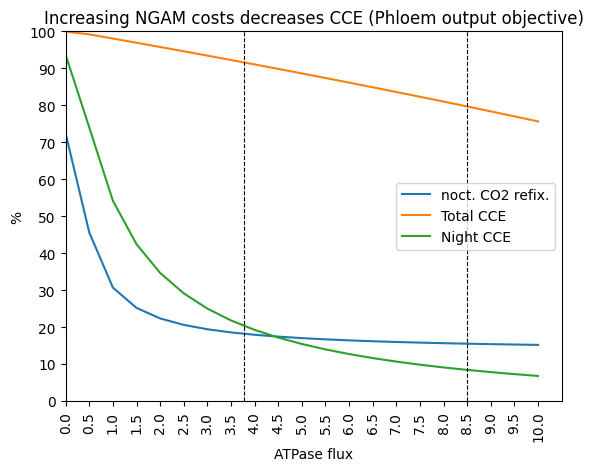

In [25]:
df = df_NGAM_phloem_scan

# Get the x-values from the plot
x_values = df.columns.astype(float)

# Find the x-value closest to set ATPase fluxes in models
ATPase_1 = 3.7651 #my value for NGAM (ATPase flux) from light intensity
ATPase_2 = 8.5 # Shameer et al., 2018 values for NGAM (ATPase flux)
closest_x1 = ATPase_1*2
closest_x2 = ATPase_2*2


# Plot the data
plt.plot(df.T["noct. CO2 coeff."]*100, label="noct. CO2 refix.")
plt.plot(df.T["CCE"]*100, label="Total CCE")
plt.plot(df.T["nighttime CCE"]*100, label="Night CCE")


# Add labels and title
plt.xlabel("ATPase flux")
plt.ylabel("%")
plt.title("Increasing NGAM costs decreases CCE (Phloem output objective)")

# Rotate x-axis labels
plt.xticks(rotation=90)

# Set y-axis limits and y-axis tick marks
plt.ylim(0, 100)
plt.yticks(range(0, 101, 10))

plt.xlim(0, len(x_values))


# Add a vertical line at mine and Shameer et al., 2018's ATPase flux value
plt.axvline(x=closest_x1, linestyle='--', color = 'black', linewidth=0.8)
plt.axvline(x=closest_x2, linestyle='--', color = 'black', linewidth=0.8)



plt.legend()

# Show the plot
plt.show()


## increasing Photon influx to test light-limitation

In [26]:
model = diel_model.copy()

df_light_scan, light_scan_sols = parameter_scan_CO2(model, output_string+"_total", "Photon_tx_00", 0, 1000, 50, pFBA=True, CO2_refixation_allowed=True, verbose=True, scan_ub_and_lb=True)

Scanning process: Photon_tx_00 

------- Scan iteration: 1      Scan value: 0 (Photon_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration is infeasible!
------- Scan iteration: 2      Scan value: 50 (Photon_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0188115
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.041092
producing HCO3-:	RXN0_5224_c_12	0.041092
producing CO2:	CO2_pc_12	0.259385
consuming CO2:	ISOCITDEH_RXN_c_12	-0.202902
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.005337
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001813
producing CO2:	CO2_mc_12	0.870397
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.309749
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.041092
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.000778
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.003627
producing CO2:	RXN_9650_p_12	0.003627
producing CO2:	2.3.1.180_RXN_p_12	0.003627
producing CO2:	RXN_9654_p_12	0.003627
consuming CO2:	R

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 3      Scan value: 100 (Photon_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0553177
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.120836
producing HCO3-:	RXN0_5224_c_12	0.120836
producing CO2:	CO2_pc_12	0.358595
consuming CO2:	ISOCITDEH_RXN_c_12	-0.222857
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.015696
producing CO2:	GLUTDECARBOX_RXN_c_12	0.00533
producing CO2:	CO2_mc_12	0.869798
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.318029
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.120836
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.002287
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.010665
producing CO2:	RXN_9650_p_12	0.010665
producing CO2:	2.3.1.180_RXN_p_12	0.010665
producing CO2:	RXN_9654_p_12	0.010665
consuming CO2:	RXN0_5224_p_12	0.074652
producing HCO3-:	RXN0_5224_p_12	0.074652
consuming CO2:	CO2_pc_12	0.358595
producing CO2:	1.2.1.2_RXN_p_12	0.001767
consuming HCO3-:	ACETYL_COA_CA

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 4      Scan value: 150 (Photon_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0918239
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.200581
producing HCO3-:	RXN0_5224_c_12	0.200581
producing CO2:	CO2_pc_12	0.454272
consuming CO2:	ISOCITDEH_RXN_c_12	-0.242813
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.026054
producing CO2:	GLUTDECARBOX_RXN_c_12	0.008848
producing CO2:	CO2_mc_12	0.872733
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.326309
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.200581
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.003797
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.017703
producing CO2:	RXN_9650_p_12	0.017703
producing CO2:	2.3.1.180_RXN_p_12	0.017703
producing CO2:	RXN_9654_p_12	0.017703
consuming CO2:	RXN0_5224_p_12	0.123918
producing HCO3-:	RXN0_5224_p_12	0.123918
consuming CO2:	CO2_pc_12	0.454272
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.123918
produci

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 5      Scan value: 200 (Photon_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 6      Scan value: 250 (Photon_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1648121
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.339358
producing HCO3-:	RXN0_5224_c_12	0.339358
producing CO2:	CO2_pc_12	0.649094
consuming CO2:	ISOCITDEH_RXN_c_12	-0.271233
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.046763
producing CO2:	GLUTDECARBOX_RXN_c_12	0.015881
producing CO2:	CO2_mc_12	0.892759
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.339758
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.339358
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.006815
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.031774
producing CO2:	RXN_9650_p_12	0.031774
producing CO2:	2.3.1.180_RXN_p_12	0.031774
producing CO2:	RXN_9654_p_12	0.031774
consuming CO2:	RXN0_5224_p_12	0.222417
producing HCO3-:	RXN0_5224_p_12	0.222417
consuming CO2:	CO2_pc_12	0.649094
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.222417
produci

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 7      Scan value: 300 (Photon_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.2012981
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.392424
producing HCO3-:	RXN0_5224_c_12	0.392424
producing CO2:	CO2_pc_12	0.746484
consuming CO2:	ISOCITDEH_RXN_c_12	-0.282786
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.057115
producing CO2:	GLUTDECARBOX_RXN_c_12	0.019397
producing CO2:	CO2_mc_12	0.909542
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.344421
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.392424
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.008324
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.038808
producing CO2:	RXN_9650_p_12	0.038808
producing CO2:	2.3.1.180_RXN_p_12	0.038808
producing CO2:	RXN_9654_p_12	0.038808
consuming CO2:	RXN0_5224_p_12	0.271655
producing HCO3-:	RXN0_5224_p_12	0.271655
consuming CO2:	CO2_pc_12	0.746484
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.271655
produci

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 8      Scan value: 350 (Photon_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.2377841
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.44549
producing HCO3-:	RXN0_5224_c_12	0.44549
producing CO2:	CO2_pc_12	0.843873
consuming CO2:	ISOCITDEH_RXN_c_12	-0.29434
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.067468
producing CO2:	GLUTDECARBOX_RXN_c_12	0.022913
producing CO2:	CO2_mc_12	0.926325
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.349085
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.44549
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.009833
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.045842
producing CO2:	RXN_9650_p_12	0.045842
producing CO2:	2.3.1.180_RXN_p_12	0.045842
producing CO2:	RXN_9654_p_12	0.045842
consuming CO2:	RXN0_5224_p_12	0.320894
producing HCO3-:	RXN0_5224_p_12	0.320894
consuming CO2:	CO2_pc_12	0.843873
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.320894
producing C

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 9      Scan value: 400 (Photon_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.2742635
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.476727
producing HCO3-:	RXN0_5224_c_12	0.476727
producing CO2:	CO2_pc_12	0.93704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.30588
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.077818
producing CO2:	GLUTDECARBOX_RXN_c_12	0.026428
producing CO2:	CO2_mc_12	0.945817
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.353741
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.476727
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.011341
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.052875
producing CO2:	RXN_9650_p_12	0.052875
producing CO2:	2.3.1.180_RXN_p_12	0.052875
producing CO2:	RXN_9654_p_12	0.052875
consuming CO2:	RXN0_5224_p_12	0.370123
producing HCO3-:	RXN0_5224_p_12	0.370123
consuming CO2:	CO2_pc_12	0.93704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.370123
producing 

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 10      Scan value: 450 (Photon_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.3106881
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.468196
producing HCO3-:	RXN0_5224_c_12	0.468196
producing CO2:	CO2_pc_12	1.033707
consuming CO2:	ISOCITDEH_RXN_c_12	-0.290944
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.088153
producing CO2:	GLUTDECARBOX_RXN_c_12	0.029938
producing CO2:	CO2_mc_12	0.967973
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.345161
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.468196
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.012847
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.059897
producing CO2:	RXN_9650_p_12	0.059897
producing CO2:	2.3.1.180_RXN_p_12	0.059897
producing CO2:	RXN_9654_p_12	0.059897
consuming CO2:	RXN0_5224_p_12	0.419279
producing HCO3-:	RXN0_5224_p_12	0.419279
consuming CO2:	CO2_pc_12	1.033707
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.419279
produc

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 11      Scan value: 500 (Photon_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.3471128
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.459665
producing HCO3-:	RXN0_5224_c_12	0.459665
producing CO2:	CO2_pc_12	1.130375
consuming CO2:	ISOCITDEH_RXN_c_12	-0.276008
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.098488
producing CO2:	GLUTDECARBOX_RXN_c_12	0.033448
producing CO2:	CO2_mc_12	0.99013
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.336581
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.459665
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.014353
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.066919
producing CO2:	RXN_9650_p_12	0.066919
producing CO2:	2.3.1.180_RXN_p_12	0.066919
producing CO2:	RXN_9654_p_12	0.066919
consuming CO2:	RXN0_5224_p_12	0.468435
producing HCO3-:	RXN0_5224_p_12	0.468435
consuming CO2:	CO2_pc_12	1.130375
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.468435
produci

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 12      Scan value: 550 (Photon_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.3835374
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.451134
producing HCO3-:	RXN0_5224_c_12	0.451134
producing CO2:	CO2_pc_12	1.227042
consuming CO2:	ISOCITDEH_RXN_c_12	-0.261072
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.108823
producing CO2:	GLUTDECARBOX_RXN_c_12	0.036958
producing CO2:	CO2_mc_12	1.012287
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.328001
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.451134
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.01586
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.073941
producing CO2:	RXN_9650_p_12	0.073941
producing CO2:	2.3.1.180_RXN_p_12	0.073941
producing CO2:	RXN_9654_p_12	0.073941
consuming CO2:	RXN0_5224_p_12	0.51759
producing HCO3-:	RXN0_5224_p_12	0.51759
consuming CO2:	CO2_pc_12	1.227042
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.51759
producing 

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 13      Scan value: 600 (Photon_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.4199621
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.442602
producing HCO3-:	RXN0_5224_c_12	0.442602
producing CO2:	CO2_pc_12	1.32371
consuming CO2:	ISOCITDEH_RXN_c_12	-0.246135
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.119158
producing CO2:	GLUTDECARBOX_RXN_c_12	0.040467
producing CO2:	CO2_mc_12	1.034443
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.319422
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.442602
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.017366
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.080964
producing CO2:	RXN_9650_p_12	0.080964
producing CO2:	2.3.1.180_RXN_p_12	0.080964
producing CO2:	RXN_9654_p_12	0.080964
consuming CO2:	RXN0_5224_p_12	0.566746
producing HCO3-:	RXN0_5224_p_12	0.566746
consuming CO2:	CO2_pc_12	1.32371
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.566746
producin

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 14      Scan value: 650 (Photon_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.4563868
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.434071
producing HCO3-:	RXN0_5224_c_12	0.434071
producing CO2:	CO2_pc_12	1.420377
consuming CO2:	ISOCITDEH_RXN_c_12	-0.231199
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.129493
producing CO2:	GLUTDECARBOX_RXN_c_12	0.043977
producing CO2:	CO2_mc_12	1.0566
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.310842
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.434071
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.018872
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.087986
producing CO2:	RXN_9650_p_12	0.087986
producing CO2:	2.3.1.180_RXN_p_12	0.087986
producing CO2:	RXN_9654_p_12	0.087986
consuming CO2:	RXN0_5224_p_12	0.615902
producing HCO3-:	RXN0_5224_p_12	0.615902
consuming CO2:	CO2_pc_12	1.420377
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.615902
producin

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 15      Scan value: 700 (Photon_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.4928114
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.42554
producing HCO3-:	RXN0_5224_c_12	0.42554
producing CO2:	CO2_pc_12	1.517044
consuming CO2:	ISOCITDEH_RXN_c_12	-0.216263
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.139828
producing CO2:	GLUTDECARBOX_RXN_c_12	0.047487
producing CO2:	CO2_mc_12	1.078757
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.302262
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.42554
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.020378
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.095008
producing CO2:	RXN_9650_p_12	0.095008
producing CO2:	2.3.1.180_RXN_p_12	0.095008
producing CO2:	RXN_9654_p_12	0.095008
consuming CO2:	RXN0_5224_p_12	0.665057
producing HCO3-:	RXN0_5224_p_12	0.665057
consuming CO2:	CO2_pc_12	1.517044
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.665057
producing

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 16      Scan value: 750 (Photon_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.5292361
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.417009
producing HCO3-:	RXN0_5224_c_12	0.417009
producing CO2:	CO2_pc_12	1.613712
consuming CO2:	ISOCITDEH_RXN_c_12	-0.201327
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.150163
producing CO2:	GLUTDECARBOX_RXN_c_12	0.050997
producing CO2:	CO2_mc_12	1.100913
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.293682
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.417009
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.021884
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.10203
producing CO2:	RXN_9650_p_12	0.10203
producing CO2:	2.3.1.180_RXN_p_12	0.10203
producing CO2:	RXN_9654_p_12	0.10203
consuming CO2:	RXN0_5224_p_12	0.714213
producing HCO3-:	RXN0_5224_p_12	0.714213
consuming CO2:	CO2_pc_12	1.613712
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.714213
producing 

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 17      Scan value: 800 (Photon_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.5656607
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.408478
producing HCO3-:	RXN0_5224_c_12	0.408478
producing CO2:	CO2_pc_12	1.710379
consuming CO2:	ISOCITDEH_RXN_c_12	-0.18639
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.160498
producing CO2:	GLUTDECARBOX_RXN_c_12	0.054507
producing CO2:	CO2_mc_12	1.12307
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.285102
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.408478
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.023391
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.109053
producing CO2:	RXN_9650_p_12	0.109053
producing CO2:	2.3.1.180_RXN_p_12	0.109053
producing CO2:	RXN_9654_p_12	0.109053
consuming CO2:	RXN0_5224_p_12	0.763369
producing HCO3-:	RXN0_5224_p_12	0.763369
consuming CO2:	CO2_pc_12	1.710379
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.763369
producin

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 18      Scan value: 850 (Photon_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.6020854
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.399947
producing HCO3-:	RXN0_5224_c_12	0.399947
producing CO2:	CO2_pc_12	1.807047
consuming CO2:	ISOCITDEH_RXN_c_12	-0.171454
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.170833
producing CO2:	GLUTDECARBOX_RXN_c_12	0.058017
producing CO2:	CO2_mc_12	1.145226
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.276522
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.399947
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.024897
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.116075
producing CO2:	RXN_9650_p_12	0.116075
producing CO2:	2.3.1.180_RXN_p_12	0.116075
producing CO2:	RXN_9654_p_12	0.116075
consuming CO2:	RXN0_5224_p_12	0.812524
producing HCO3-:	RXN0_5224_p_12	0.812524
consuming CO2:	CO2_pc_12	1.807047
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.812524
produc

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 19      Scan value: 900 (Photon_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.6384829
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.391422
producing HCO3-:	RXN0_5224_c_12	0.391422
producing CO2:	CO2_pc_12	1.903642
consuming CO2:	ISOCITDEH_RXN_c_12	-0.156529
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.18116
producing CO2:	GLUTDECARBOX_RXN_c_12	0.061524
producing CO2:	CO2_mc_12	1.167366
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.267949
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.391422
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.026402
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.123092
producing CO2:	RXN_9650_p_12	0.123092
producing CO2:	2.3.1.180_RXN_p_12	0.123092
producing CO2:	RXN_9654_p_12	0.123092
consuming CO2:	RXN0_5224_p_12	0.861643
producing HCO3-:	RXN0_5224_p_12	0.861643
consuming CO2:	CO2_pc_12	1.903642
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.861643
produci

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 20      Scan value: 950 (Photon_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.6748736
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.382899
producing HCO3-:	RXN0_5224_c_12	0.382899
producing CO2:	CO2_pc_12	2.000219
consuming CO2:	ISOCITDEH_RXN_c_12	-0.141607
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.191486
producing CO2:	GLUTDECARBOX_RXN_c_12	0.065031
producing CO2:	CO2_mc_12	1.189502
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.259377
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.382899
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.027907
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.130108
producing CO2:	RXN_9650_p_12	0.130108
producing CO2:	2.3.1.180_RXN_p_12	0.130108
producing CO2:	RXN_9654_p_12	0.130108
consuming CO2:	RXN0_5224_p_12	0.910753
producing HCO3-:	RXN0_5224_p_12	0.910753
consuming CO2:	CO2_pc_12	2.000219
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.910753
produc

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


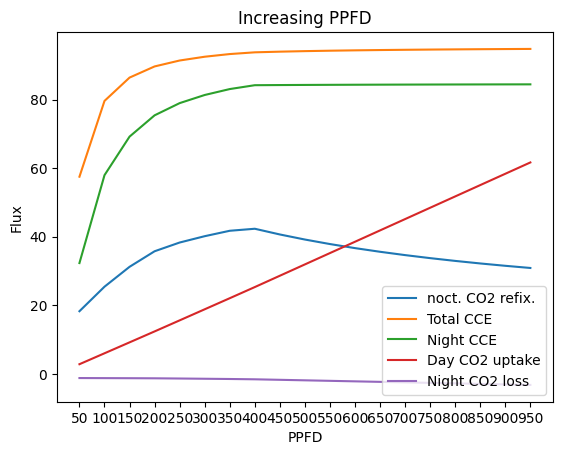

In [27]:
df = df_light_scan


# Plot the data
plt.plot(df.T["noct. CO2 coeff."]*100, label="noct. CO2 refix.")
plt.plot(df.T["CCE"]*100, label="Total CCE")
plt.plot(df.T["nighttime CCE"]*100, label="Night CCE")
plt.plot(df.T["CO2_tx_00"], label="Day CO2 uptake")
plt.plot(df.T["CO2_tx_12"], label="Night CO2 loss")


# Add labels and title
plt.xlabel("PPFD")
plt.ylabel("Flux")
plt.title("Increasing PPFD")


plt.legend()

# Show the plot
plt.show()

## limiting CO2 uptake rates

### get literature data for Arabidopsis

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
# dataframe to display information for Arabidopsis CO2 assimilation rates
# Create a dictionary with sample data
data = {
    'Publication': ["Donahue $\it{et\ al.}$ (1997)","Sun $\it{et\ al.}$ (1999)",  "Poulson $\it{et\ al.}$ (2002)", "Schlüter $\it{et\ al.}$ (2003)","Lake (2004)","Toquin & Périlleux (2004)","Ivanov $\it{et\ al.}$ (2012)"],
    'reported A$_{area}$': [5,8, 9, 5, 7.5,5,   7],
    'PPFD': [200, 200, 200, 200,  200, 200, 200],
}

# Create the dataframe
df = pd.DataFrame(data)


df


,Publication,reported A$_{area}$,PPFD
0,Donahue $\it{et\ al.}$ (1997),5.0,200
1,Sun $\it{et\ al.}$ (1999),8.0,200
2,Poulson $\it{et\ al.}$ (2002),9.0,200
3,Schlüter $\it{et\ al.}$ (2003),5.0,200
4,Lake (2004),7.5,200
5,Toquin & Périlleux (2004),5.0,200
6,Ivanov $\it{et\ al.}$ (2012),7.0,200


Average value: 6.643


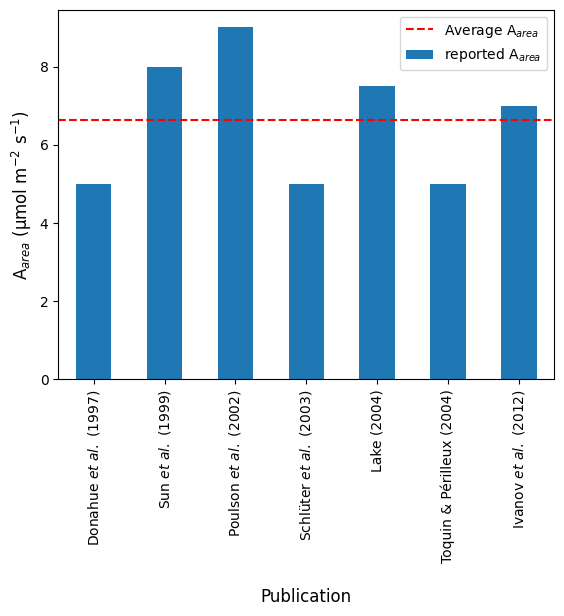

In [47]:
df.plot(kind='bar', x='Publication', y='reported A$_{area}$', rot=90)  # Rotate the x-axis labels to be vertical
plt.xlabel('Publication', labelpad=18, fontsize=12)  # Adjust the labelpad value to increase or decrease the distance
plt.ylabel('A$_{area}$ (\u00B5mol m$^{-2}$ s$^{-1}$)', fontsize=12)
# plt.title('CO$_{2}$ assimilation rates measured in Arabidopsis')

# Calculate the average and median values
average_value = df['reported A$_{area}$'].mean()
print("Average value:", round(average_value,3))
median_value = df['reported A$_{area}$'].median()

# Plot the average value
plt.axhline(average_value, color='red', linestyle='--', label='Average A$_{area}$' )

# Plot the median value in a different color
# plt.axhline(median_value, color='blue', linestyle='--', label='Median')

plt.legend()
plt.savefig("Ch1_published_A.png", dpi=300, bbox_inches='tight')
plt.show()


### scan over CO2 daytime uptake constraint (direct = CAM-cycling; indirect = C3)

In [30]:
# scan over upper limit on objective reaction (=indirect CO2 uptake limitation)

df_A1, sol_A1 = parameter_scan_CO2(diel_model, output_string+"_total", output_string+"_total", 0, 0.14, 0.005, pFBA=True, 
                    CO2_refixation_allowed=True, verbose=True, iterations=50)

Scanning process: AraCore_Biomass_tx_total 

------- Scan iteration: 1      Scan value: 0.0 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0
----- Cytosol -----
producing CO2:	CO2_pc_12	0.209172
consuming CO2:	ISOCITDEH_RXN_c_12	-0.192619
producing CO2:	CO2_mc_12	0.869795
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.305482
----- Plastid -----
consuming CO2:	CO2_pc_12	0.209172
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.209172
----- Mitochondrion -----
producing CO2:	ISOCITDEH_RXN_m_12	0.418344
producing CO2:	PYRUVDEH_RXN_m_12	0.225725
producing CO2:	2OXOGLUTARATEDEH_RXN_m_12	0.225725
consuming CO2:	CO2_mc_12	0.869795
----- Peroxisome -----

CO2 produced: 1.38445
CO2 consumed: -0.19262
CO2 exchange: -1.19183

nocturnal CO2 refixation coeffient: 0.13913


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 2      Scan value: 0.005 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.005
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.004906
producing HCO3-:	RXN0_5224_c_12	0.004906
producing CO2:	CO2_pc_12	0.222415
consuming CO2:	ISOCITDEH_RXN_c_12	-0.1932
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.001419
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000482
producing CO2:	CO2_mc_12	0.87385
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.305772
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.004906
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.000964
producing CO2:	RXN_9650_p_12	0.000964
producing CO2:	2.3.1.180_RXN_p_12	0.000964
producing CO2:	RXN_9654_p_12	0.000964
consuming CO2:	RXN0_5224_p_12	0.006748
producing HCO3-:	RXN0_5224_p_12	0.006748
consuming CO2:	CO2_pc_12	0.222415
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.006748
producing CO2:	PYRUVDEH_RXN_p_12	0.008161
producing CO2:	RXN_965

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 3      Scan value: 0.01 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.01
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.009812
producing HCO3-:	RXN0_5224_c_12	0.009812
producing CO2:	CO2_pc_12	0.235658
consuming CO2:	ISOCITDEH_RXN_c_12	-0.193781
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.002837
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000964
producing CO2:	CO2_mc_12	0.877906
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.306063
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.009812
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.001928
producing CO2:	RXN_9650_p_12	0.001928
producing CO2:	2.3.1.180_RXN_p_12	0.001928
producing CO2:	RXN_9654_p_12	0.001928
consuming CO2:	RXN0_5224_p_12	0.013495
producing HCO3-:	RXN0_5224_p_12	0.013495
consuming CO2:	CO2_pc_12	0.235658
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.013495
producing CO2:	PYRUVDEH_RXN_p_12	0.016322
producing CO2:	RXN_96

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 4      Scan value: 0.015 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.015
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.014718
producing HCO3-:	RXN0_5224_c_12	0.014718
producing CO2:	CO2_pc_12	0.248901
consuming CO2:	ISOCITDEH_RXN_c_12	-0.194362
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.004256
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001445
producing CO2:	CO2_mc_12	0.881961
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.306353
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.014718
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.002892
producing CO2:	RXN_9650_p_12	0.002892
producing CO2:	2.3.1.180_RXN_p_12	0.002892
producing CO2:	RXN_9654_p_12	0.002892
consuming CO2:	RXN0_5224_p_12	0.020243
producing HCO3-:	RXN0_5224_p_12	0.020243
consuming CO2:	CO2_pc_12	0.248901
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.020243
producing CO2:	PYRUVDEH_RXN_p_12	0.024482
producing CO2:	RXN_

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 5      Scan value: 0.02 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.02
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.019624
producing HCO3-:	RXN0_5224_c_12	0.019624
producing CO2:	CO2_pc_12	0.262143
consuming CO2:	ISOCITDEH_RXN_c_12	-0.194943
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.005675
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001927
producing CO2:	CO2_mc_12	0.886016
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.306644
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.019624
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.003856
producing CO2:	RXN_9650_p_12	0.003856
producing CO2:	2.3.1.180_RXN_p_12	0.003856
producing CO2:	RXN_9654_p_12	0.003856
consuming CO2:	RXN0_5224_p_12	0.02699
producing HCO3-:	RXN0_5224_p_12	0.02699
consuming CO2:	CO2_pc_12	0.262143
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.02699
producing CO2:	PYRUVDEH_RXN_p_12	0.032643
producing CO2:	RXN_9653_

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 6      Scan value: 0.025 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.025
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.026045
producing HCO3-:	RXN0_5224_c_12	0.026045
producing CO2:	CO2_pc_12	0.275386
consuming CO2:	ISOCITDEH_RXN_c_12	-0.196158
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.007093
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002409
producing CO2:	CO2_mc_12	0.888803
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.307251
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.026045
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.00482
producing CO2:	RXN_9650_p_12	0.00482
producing CO2:	2.3.1.180_RXN_p_12	0.00482
producing CO2:	RXN_9654_p_12	0.00482
consuming CO2:	RXN0_5224_p_12	0.033738
producing HCO3-:	RXN0_5224_p_12	0.033738
consuming CO2:	CO2_pc_12	0.275386
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.033738
producing CO2:	PYRUVDEH_RXN_p_12	0.040804
producing CO2:	RXN_9653

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 7      Scan value: 0.03 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.03
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.065532
producing HCO3-:	RXN0_5224_c_12	0.065532
producing CO2:	CO2_pc_12	0.288629
consuming CO2:	ISOCITDEH_RXN_c_12	-0.206041
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.008512
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002891
producing CO2:	CO2_mc_12	0.874255
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.312193
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.065532
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.005784
producing CO2:	RXN_9650_p_12	0.005784
producing CO2:	2.3.1.180_RXN_p_12	0.005784
producing CO2:	RXN_9654_p_12	0.005784
consuming CO2:	RXN0_5224_p_12	0.040486
producing HCO3-:	RXN0_5224_p_12	0.040486
consuming CO2:	CO2_pc_12	0.288629
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.040486
producing CO2:	PYRUVDEH_RXN_p_12	0.048965
producing CO2:	RXN_96

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 8      Scan value: 0.035 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.035
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.076454
producing HCO3-:	RXN0_5224_c_12	0.076454
producing CO2:	CO2_pc_12	0.301872
consuming CO2:	ISOCITDEH_RXN_c_12	-0.20902
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.009931
producing CO2:	GLUTDECARBOX_RXN_c_12	0.003373
producing CO2:	CO2_mc_12	0.873515
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.313338
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.076454
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.006748
producing CO2:	RXN_9650_p_12	0.006748
producing CO2:	2.3.1.180_RXN_p_12	0.006748
producing CO2:	RXN_9654_p_12	0.006748
consuming CO2:	RXN0_5224_p_12	0.047233
producing HCO3-:	RXN0_5224_p_12	0.047233
consuming CO2:	CO2_pc_12	0.301872
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.047233
producing CO2:	PYRUVDEH_RXN_p_12	0.057125
producing CO2:	RXN_9

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 9      Scan value: 0.04 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.04
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.087376
producing HCO3-:	RXN0_5224_c_12	0.087376
producing CO2:	CO2_pc_12	0.315115
consuming CO2:	ISOCITDEH_RXN_c_12	-0.211363
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.011349
producing CO2:	GLUTDECARBOX_RXN_c_12	0.003854
producing CO2:	CO2_mc_12	0.874046
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.31446
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.087376
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.007712
producing CO2:	RXN_9650_p_12	0.007712
producing CO2:	2.3.1.180_RXN_p_12	0.007712
producing CO2:	RXN_9654_p_12	0.007712
consuming CO2:	RXN0_5224_p_12	0.053981
producing HCO3-:	RXN0_5224_p_12	0.053981
consuming CO2:	CO2_pc_12	0.315115
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.053981
producing CO2:	PYRUVDEH_RXN_p_12	0.065286
producing CO2:	RXN_965

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 10      Scan value: 0.045 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.045
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.098298
producing HCO3-:	RXN0_5224_c_12	0.098298
producing CO2:	CO2_pc_12	0.328357
consuming CO2:	ISOCITDEH_RXN_c_12	-0.213706
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.012768
producing CO2:	GLUTDECARBOX_RXN_c_12	0.004336
producing CO2:	CO2_mc_12	0.874578
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.315582
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.098298
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.008675
producing CO2:	RXN_9650_p_12	0.008675
producing CO2:	2.3.1.180_RXN_p_12	0.008675
producing CO2:	RXN_9654_p_12	0.008675
consuming CO2:	RXN0_5224_p_12	0.060728
producing HCO3-:	RXN0_5224_p_12	0.060728
consuming CO2:	CO2_pc_12	0.328357
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.060728
producing CO2:	PYRUVDEH_RXN_p_12	0.073447
producing CO2:	RXN

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 11      Scan value: 0.05 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.05
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.10922
producing HCO3-:	RXN0_5224_c_12	0.10922
producing CO2:	CO2_pc_12	0.3416
consuming CO2:	ISOCITDEH_RXN_c_12	-0.216049
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.014187
producing CO2:	GLUTDECARBOX_RXN_c_12	0.004818
producing CO2:	CO2_mc_12	0.875109
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.316704
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.10922
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.009639
producing CO2:	RXN_9650_p_12	0.009639
producing CO2:	2.3.1.180_RXN_p_12	0.009639
producing CO2:	RXN_9654_p_12	0.009639
consuming CO2:	RXN0_5224_p_12	0.067476
producing HCO3-:	RXN0_5224_p_12	0.067476
consuming CO2:	CO2_pc_12	0.3416
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.067476
producing CO2:	PYRUVDEH_RXN_p_12	0.081608
producing CO2:	RXN_9653_p_1

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 12      Scan value: 0.055 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.055
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.120142
producing HCO3-:	RXN0_5224_c_12	0.120142
producing CO2:	CO2_pc_12	0.354843
consuming CO2:	ISOCITDEH_RXN_c_12	-0.218392
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.015605
producing CO2:	GLUTDECARBOX_RXN_c_12	0.0053
producing CO2:	CO2_mc_12	0.87564
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.317827
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.120142
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.010603
producing CO2:	RXN_9650_p_12	0.010603
producing CO2:	2.3.1.180_RXN_p_12	0.010603
producing CO2:	RXN_9654_p_12	0.010603
consuming CO2:	RXN0_5224_p_12	0.074223
producing HCO3-:	RXN0_5224_p_12	0.074223
consuming CO2:	CO2_pc_12	0.354843
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.074223
producing CO2:	PYRUVDEH_RXN_p_12	0.089769
producing CO2:	RXN_96

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 13      Scan value: 0.06 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.06
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.131064
producing HCO3-:	RXN0_5224_c_12	0.131064
producing CO2:	CO2_pc_12	0.368086
consuming CO2:	ISOCITDEH_RXN_c_12	-0.220735
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.017024
producing CO2:	GLUTDECARBOX_RXN_c_12	0.005782
producing CO2:	CO2_mc_12	0.876172
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.318949
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.131064
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.011567
producing CO2:	RXN_9650_p_12	0.011567
producing CO2:	2.3.1.180_RXN_p_12	0.011567
producing CO2:	RXN_9654_p_12	0.011567
consuming CO2:	RXN0_5224_p_12	0.080971
producing HCO3-:	RXN0_5224_p_12	0.080971
consuming CO2:	CO2_pc_12	0.368086
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.080971
producing CO2:	PYRUVDEH_RXN_p_12	0.097929
producing CO2:	RXN_9

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 14      Scan value: 0.065 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.065
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.141987
producing HCO3-:	RXN0_5224_c_12	0.141987
producing CO2:	CO2_pc_12	0.381328
consuming CO2:	ISOCITDEH_RXN_c_12	-0.223078
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.018443
producing CO2:	GLUTDECARBOX_RXN_c_12	0.006263
producing CO2:	CO2_mc_12	0.876703
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.320071
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.141987
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.012531
producing CO2:	RXN_9650_p_12	0.012531
producing CO2:	2.3.1.180_RXN_p_12	0.012531
producing CO2:	RXN_9654_p_12	0.012531
consuming CO2:	RXN0_5224_p_12	0.087719
producing HCO3-:	RXN0_5224_p_12	0.087719
consuming CO2:	CO2_pc_12	0.381328
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.087719
producing CO2:	PYRUVDEH_RXN_p_12	0.10609
producing CO2:	RXN_

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 15      Scan value: 0.07 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.07
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.152909
producing HCO3-:	RXN0_5224_c_12	0.152909
producing CO2:	CO2_pc_12	0.394571
consuming CO2:	ISOCITDEH_RXN_c_12	-0.225421
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.019861
producing CO2:	GLUTDECARBOX_RXN_c_12	0.006745
producing CO2:	CO2_mc_12	0.877235
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.321193
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.152909
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.013495
producing CO2:	RXN_9650_p_12	0.013495
producing CO2:	2.3.1.180_RXN_p_12	0.013495
producing CO2:	RXN_9654_p_12	0.013495
consuming CO2:	RXN0_5224_p_12	0.094466
producing HCO3-:	RXN0_5224_p_12	0.094466
consuming CO2:	CO2_pc_12	0.394571
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.094466
producing CO2:	PYRUVDEH_RXN_p_12	0.114251
producing CO2:	RXN_9

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 16      Scan value: 0.075 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.075
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.163831
producing HCO3-:	RXN0_5224_c_12	0.163831
producing CO2:	CO2_pc_12	0.407814
consuming CO2:	ISOCITDEH_RXN_c_12	-0.227764
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.02128
producing CO2:	GLUTDECARBOX_RXN_c_12	0.007227
producing CO2:	CO2_mc_12	0.877766
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.322316
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.163831
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.014459
producing CO2:	RXN_9650_p_12	0.014459
producing CO2:	2.3.1.180_RXN_p_12	0.014459
producing CO2:	RXN_9654_p_12	0.014459
consuming CO2:	RXN0_5224_p_12	0.101214
producing HCO3-:	RXN0_5224_p_12	0.101214
consuming CO2:	CO2_pc_12	0.407814
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.101214
producing CO2:	PYRUVDEH_RXN_p_12	0.122412
producing CO2:	RXN_

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 17      Scan value: 0.08 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.08
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.174753
producing HCO3-:	RXN0_5224_c_12	0.174753
producing CO2:	CO2_pc_12	0.421057
consuming CO2:	ISOCITDEH_RXN_c_12	-0.230107
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.022699
producing CO2:	GLUTDECARBOX_RXN_c_12	0.007709
producing CO2:	CO2_mc_12	0.878297
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.323438
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.174753
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.015423
producing CO2:	RXN_9650_p_12	0.015423
producing CO2:	2.3.1.180_RXN_p_12	0.015423
producing CO2:	RXN_9654_p_12	0.015423
consuming CO2:	RXN0_5224_p_12	0.107961
producing HCO3-:	RXN0_5224_p_12	0.107961
consuming CO2:	CO2_pc_12	0.421057
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.107961
producing CO2:	PYRUVDEH_RXN_p_12	0.130572
producing CO2:	RXN_9

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 18      Scan value: 0.085 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.085
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.185675
producing HCO3-:	RXN0_5224_c_12	0.185675
producing CO2:	CO2_pc_12	0.4343
consuming CO2:	ISOCITDEH_RXN_c_12	-0.23245
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.024118
producing CO2:	GLUTDECARBOX_RXN_c_12	0.008191
producing CO2:	CO2_mc_12	0.878829
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.32456
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.185675
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.016387
producing CO2:	RXN_9650_p_12	0.016387
producing CO2:	2.3.1.180_RXN_p_12	0.016387
producing CO2:	RXN_9654_p_12	0.016387
consuming CO2:	RXN0_5224_p_12	0.114709
producing HCO3-:	RXN0_5224_p_12	0.114709
consuming CO2:	CO2_pc_12	0.4343
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.114709
producing CO2:	PYRUVDEH_RXN_p_12	0.138733
producing CO2:	RXN_9653_

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 19      Scan value: 0.09 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.09
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.196597
producing HCO3-:	RXN0_5224_c_12	0.196597
producing CO2:	CO2_pc_12	0.447542
consuming CO2:	ISOCITDEH_RXN_c_12	-0.234793
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.025536
producing CO2:	GLUTDECARBOX_RXN_c_12	0.008672
producing CO2:	CO2_mc_12	0.87936
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.325682
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.196597
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.017351
producing CO2:	RXN_9650_p_12	0.017351
producing CO2:	2.3.1.180_RXN_p_12	0.017351
producing CO2:	RXN_9654_p_12	0.017351
consuming CO2:	RXN0_5224_p_12	0.121457
producing HCO3-:	RXN0_5224_p_12	0.121457
consuming CO2:	CO2_pc_12	0.447542
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.121457
producing CO2:	PYRUVDEH_RXN_p_12	0.146894
producing CO2:	RXN_96

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 20      Scan value: 0.095 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.095
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.207519
producing HCO3-:	RXN0_5224_c_12	0.207519
producing CO2:	CO2_pc_12	0.460785
consuming CO2:	ISOCITDEH_RXN_c_12	-0.237136
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.026955
producing CO2:	GLUTDECARBOX_RXN_c_12	0.009154
producing CO2:	CO2_mc_12	0.879892
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.326805
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.207519
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.018315
producing CO2:	RXN_9650_p_12	0.018315
producing CO2:	2.3.1.180_RXN_p_12	0.018315
producing CO2:	RXN_9654_p_12	0.018315
consuming CO2:	RXN0_5224_p_12	0.128204
producing HCO3-:	RXN0_5224_p_12	0.128204
consuming CO2:	CO2_pc_12	0.460785
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.128204
producing CO2:	PYRUVDEH_RXN_p_12	0.155055
producing CO2:	RXN

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 21      Scan value: 0.1 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.218441
producing HCO3-:	RXN0_5224_c_12	0.218441
producing CO2:	CO2_pc_12	0.474028
consuming CO2:	ISOCITDEH_RXN_c_12	-0.239479
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.028374
producing CO2:	GLUTDECARBOX_RXN_c_12	0.009636
producing CO2:	CO2_mc_12	0.880423
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.327927
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.218441
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.019279
producing CO2:	RXN_9650_p_12	0.019279
producing CO2:	2.3.1.180_RXN_p_12	0.019279
producing CO2:	RXN_9654_p_12	0.019279
consuming CO2:	RXN0_5224_p_12	0.134952
producing HCO3-:	RXN0_5224_p_12	0.134952
consuming CO2:	CO2_pc_12	0.474028
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.134952
producing CO2:	PYRUVDEH_RXN_p_12	0.163216
producing CO2:	RXN_965

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 22      Scan value: 0.105 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.105
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.229363
producing HCO3-:	RXN0_5224_c_12	0.229363
producing CO2:	CO2_pc_12	0.487271
consuming CO2:	ISOCITDEH_RXN_c_12	-0.241822
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.029792
producing CO2:	GLUTDECARBOX_RXN_c_12	0.010118
producing CO2:	CO2_mc_12	0.880954
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.329049
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.229363
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.020243
producing CO2:	RXN_9650_p_12	0.020243
producing CO2:	2.3.1.180_RXN_p_12	0.020243
producing CO2:	RXN_9654_p_12	0.020243
consuming CO2:	RXN0_5224_p_12	0.141699
producing HCO3-:	RXN0_5224_p_12	0.141699
consuming CO2:	CO2_pc_12	0.487271
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.141699
producing CO2:	PYRUVDEH_RXN_p_12	0.171376
producing CO2:	RXN

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 23      Scan value: 0.11 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.11
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.240285
producing HCO3-:	RXN0_5224_c_12	0.240285
producing CO2:	CO2_pc_12	0.500514
consuming CO2:	ISOCITDEH_RXN_c_12	-0.244165
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.031211
producing CO2:	GLUTDECARBOX_RXN_c_12	0.0106
producing CO2:	CO2_mc_12	0.881486
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.330171
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.240285
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.021207
producing CO2:	RXN_9650_p_12	0.021207
producing CO2:	2.3.1.180_RXN_p_12	0.021207
producing CO2:	RXN_9654_p_12	0.021207
consuming CO2:	RXN0_5224_p_12	0.148447
producing HCO3-:	RXN0_5224_p_12	0.148447
consuming CO2:	CO2_pc_12	0.500514
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.148447
producing CO2:	PYRUVDEH_RXN_p_12	0.179537
producing CO2:	RXN_965

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 24      Scan value: 0.115 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.115
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.245666
producing HCO3-:	RXN0_5224_c_12	0.245666
producing CO2:	CO2_pc_12	0.513756
consuming CO2:	ISOCITDEH_RXN_c_12	-0.246337
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.03263
producing CO2:	GLUTDECARBOX_RXN_c_12	0.011081
producing CO2:	CO2_mc_12	0.882359
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.331208
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.245666
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.022171
producing CO2:	RXN_9650_p_12	0.022171
producing CO2:	2.3.1.180_RXN_p_12	0.022171
producing CO2:	RXN_9654_p_12	0.022171
consuming CO2:	RXN0_5224_p_12	0.155194
producing HCO3-:	RXN0_5224_p_12	0.155194
consuming CO2:	CO2_pc_12	0.513756
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.155194
producing CO2:	PYRUVDEH_RXN_p_12	0.187698
producing CO2:	RXN_

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 25      Scan value: 0.12 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.12
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.256347
producing HCO3-:	RXN0_5224_c_12	0.256347
producing CO2:	CO2_pc_12	0.526999
consuming CO2:	ISOCITDEH_RXN_c_12	-0.248672
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.034048
producing CO2:	GLUTDECARBOX_RXN_c_12	0.011563
producing CO2:	CO2_mc_12	0.882905
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.332327
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.256347
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.023135
producing CO2:	RXN_9650_p_12	0.023135
producing CO2:	2.3.1.180_RXN_p_12	0.023135
producing CO2:	RXN_9654_p_12	0.023135
consuming CO2:	RXN0_5224_p_12	0.161942
producing HCO3-:	RXN0_5224_p_12	0.161942
consuming CO2:	CO2_pc_12	0.526999
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.161942
producing CO2:	PYRUVDEH_RXN_p_12	0.195859
producing CO2:	RXN_9

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 26      Scan value: 0.125 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.125
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.267028
producing HCO3-:	RXN0_5224_c_12	0.267028
producing CO2:	CO2_pc_12	0.540242
consuming CO2:	ISOCITDEH_RXN_c_12	-0.251008
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.035467
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012045
producing CO2:	CO2_mc_12	0.883451
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.333445
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.267028
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.024099
producing CO2:	RXN_9650_p_12	0.024099
producing CO2:	2.3.1.180_RXN_p_12	0.024099
producing CO2:	RXN_9654_p_12	0.024099
consuming CO2:	RXN0_5224_p_12	0.16869
producing HCO3-:	RXN0_5224_p_12	0.16869
consuming CO2:	CO2_pc_12	0.540242
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.16869
producing CO2:	PYRUVDEH_RXN_p_12	0.204019
producing CO2:	RXN_96

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 27      Scan value: 0.13 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
p

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 28      Scan value: 0.135 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 29      Scan value: 0.14 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
p

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


In [31]:
# scan over upper limit on CO2 uptake, without any CAM constraints

df_B1, sol_B1 = parameter_scan_CO2(diel_model, output_string+"_total", "CO2_tx"+day_tag, 0, 15.1, 0.2, pFBA=True, 
                    CO2_refixation_allowed=True, verbose=True, iterations=50)

Scanning process: CO2_tx_00 

------- Scan iteration: 1      Scan value: 0.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.20274
producing HCO3-:	RXN0_5224_c_12	1.20274
producing CO2:	CO2_pc_12	0.209172
consuming CO2:	ISOCITDEH_RXN_c_12	-0.418344
producing CO2:	CO2_mc_12	0.993568
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.418344
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.20274
----- Plastid -----
consuming CO2:	CO2_pc_12	0.209172
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.209172
----- Mitochondrion -----
producing CO2:	ISOCITDEH_RXN_m_12	0.418344
producing CO2:	PYRUVDEH_RXN_m_12	0.575224
consuming CO2:	CO2_mc_12	0.993568
----- Peroxisome -----

CO2 produced: 1.62108
CO2 consumed: -1.62108
CO2 exchange: -0.0

nocturnal CO2 refixation coeffient: 1.0
CO2_tx_00 = 0


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 2      Scan value: 0.2 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0023082
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.210821
producing HCO3-:	RXN0_5224_c_12	1.210821
producing CO2:	CO2_pc_12	0.21476
consuming CO2:	ISOCITDEH_RXN_c_12	-0.417526
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.000655
producing CO2:	GLUTDECARBOX_RXN_c_12	5.6e-05
producing CO2:	CO2_mc_12	0.994954
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.417828
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.210821
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	9.5e-05
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.000148
producing CO2:	RXN_9652_p_12	0.000445
producing CO2:	RXN_9650_p_12	0.000445
producing CO2:	2.3.1.180_RXN_p_12	0.000445
producing CO2:	RXN_9654_p_12	0.000445
consuming CO2:	RXN0_5224_p_12	0.003115
producing HCO3-:	RXN0_5224_p_12	0.003115
consuming CO2:	CO2_pc_12	0.21476
producing CO2:	1.2.1.2_RXN_

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 3      Scan value: 0.4 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0046165
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.218902
producing HCO3-:	RXN0_5224_c_12	1.218902
producing CO2:	CO2_pc_12	0.220347
consuming CO2:	ISOCITDEH_RXN_c_12	-0.416708
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.00131
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000111
producing CO2:	CO2_mc_12	0.99634
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.417312
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.218902
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.000191
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.000296
producing CO2:	RXN_9652_p_12	0.00089
producing CO2:	RXN_9650_p_12	0.00089
producing CO2:	2.3.1.180_RXN_p_12	0.00089
producing CO2:	RXN_9654_p_12	0.00089
consuming CO2:	RXN0_5224_p_12	0.00623
producing HCO3-:	RXN0_5224_p_12	0.00623
consuming CO2:	CO2_pc_12	0.220347
producing CO2:	1.2.1.2_RXN_p_12

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 4      Scan value: 0.6000000000000001 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0069247
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.226983
producing HCO3-:	RXN0_5224_c_12	1.226983
producing CO2:	CO2_pc_12	0.225935
consuming CO2:	ISOCITDEH_RXN_c_12	-0.41589
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.001965
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000167
producing CO2:	CO2_mc_12	0.997725
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.416795
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.226983
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.000286
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.000444
producing CO2:	RXN_9652_p_12	0.001335
producing CO2:	RXN_9650_p_12	0.001335
producing CO2:	2.3.1.180_RXN_p_12	0.001335
producing CO2:	RXN_9654_p_12	0.001335
consuming CO2:	RXN0_5224_p_12	0.009345
producing HCO3-:	RXN0_5224_p_12	0.009345
consuming CO2:	CO2_pc_12	0.225935
producing

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 5      Scan value: 0.8 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0092329
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.235064
producing HCO3-:	RXN0_5224_c_12	1.235064
producing CO2:	CO2_pc_12	0.231522
consuming CO2:	ISOCITDEH_RXN_c_12	-0.415072
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.00262
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000222
producing CO2:	CO2_mc_12	0.999111
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.416279
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.235064
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.000382
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.000592
producing CO2:	RXN_9652_p_12	0.00178
producing CO2:	RXN_9650_p_12	0.00178
producing CO2:	2.3.1.180_RXN_p_12	0.00178
producing CO2:	RXN_9654_p_12	0.00178
consuming CO2:	RXN0_5224_p_12	0.01246
producing HCO3-:	RXN0_5224_p_12	0.01246
consuming CO2:	CO2_pc_12	0.231522
producing CO2:	1.2.1.2_RXN_p_1

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 6      Scan value: 1.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0115412
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.243145
producing HCO3-:	RXN0_5224_c_12	1.243145
producing CO2:	CO2_pc_12	0.236741
consuming CO2:	ISOCITDEH_RXN_c_12	-0.414254
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.003275
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000278
producing CO2:	CO2_mc_12	1.000865
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.415763
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.243145
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.000477
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.00074
producing CO2:	RXN_9652_p_12	0.002225
producing CO2:	RXN_9650_p_12	0.002225
producing CO2:	2.3.1.180_RXN_p_12	0.002225
producing CO2:	RXN_9654_p_12	0.002225
consuming CO2:	RXN0_5224_p_12	0.015575
producing HCO3-:	RXN0_5224_p_12	0.015575
consuming CO2:	CO2_pc_12	0.236741
consuming HCO3-:	ACETYL_

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 7      Scan value: 1.2000000000000002 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0138494
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.251226
producing HCO3-:	RXN0_5224_c_12	1.251226
producing CO2:	CO2_pc_12	0.242255
consuming CO2:	ISOCITDEH_RXN_c_12	-0.413436
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.00393
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000334
producing CO2:	CO2_mc_12	1.002325
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.415246
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.251226
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.000573
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.000888
producing CO2:	RXN_9652_p_12	0.00267
producing CO2:	RXN_9650_p_12	0.00267
producing CO2:	2.3.1.180_RXN_p_12	0.00267
producing CO2:	RXN_9654_p_12	0.00267
consuming CO2:	RXN0_5224_p_12	0.01869
producing HCO3-:	RXN0_5224_p_12	0.01869
consuming CO2:	CO2_pc_12	0.242255
consuming HCO3-

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 8      Scan value: 1.4000000000000001 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0161576
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.259307
producing HCO3-:	RXN0_5224_c_12	1.259307
producing CO2:	CO2_pc_12	0.248285
consuming CO2:	ISOCITDEH_RXN_c_12	-0.412618
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.004584
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000389
producing CO2:	CO2_mc_12	1.003268
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.41473
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.259307
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.000668
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.001036
producing CO2:	RXN_9652_p_12	0.003115
producing CO2:	RXN_9650_p_12	0.003115
producing CO2:	2.3.1.180_RXN_p_12	0.003115
producing CO2:	RXN_9654_p_12	0.003115
consuming CO2:	RXN0_5224_p_12	0.021805
producing HCO3-:	RXN0_5224_p_12	0.021805
consuming CO2:	CO2_pc_12	0.248285
producing

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 9      Scan value: 1.6 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0184659
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.267388
producing HCO3-:	RXN0_5224_c_12	1.267388
producing CO2:	CO2_pc_12	0.253872
consuming CO2:	ISOCITDEH_RXN_c_12	-0.4118
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.005239
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000445
producing CO2:	CO2_mc_12	1.004654
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.414214
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.267388
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.000764
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.001184
producing CO2:	RXN_9652_p_12	0.00356
producing CO2:	RXN_9650_p_12	0.00356
producing CO2:	2.3.1.180_RXN_p_12	0.00356
producing CO2:	RXN_9654_p_12	0.00356
consuming CO2:	RXN0_5224_p_12	0.02492
producing HCO3-:	RXN0_5224_p_12	0.02492
consuming CO2:	CO2_pc_12	0.253872
producing CO2:	1.2.1.2_RXN_p_12

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 10      Scan value: 1.8 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0207741
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.275469
producing HCO3-:	RXN0_5224_c_12	1.275469
producing CO2:	CO2_pc_12	0.25946
consuming CO2:	ISOCITDEH_RXN_c_12	-0.410982
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.005894
producing CO2:	GLUTDECARBOX_RXN_c_12	0.0005
producing CO2:	CO2_mc_12	1.00604
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.413697
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.275469
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.000859
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.001332
producing CO2:	RXN_9652_p_12	0.004005
producing CO2:	RXN_9650_p_12	0.004005
producing CO2:	2.3.1.180_RXN_p_12	0.004005
producing CO2:	RXN_9654_p_12	0.004005
consuming CO2:	RXN0_5224_p_12	0.028035
producing HCO3-:	RXN0_5224_p_12	0.028035
consuming CO2:	CO2_pc_12	0.25946
producing CO2:	1.2.1.2_RXN_

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 11      Scan value: 2.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0230823
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.28355
producing HCO3-:	RXN0_5224_c_12	1.28355
producing CO2:	CO2_pc_12	0.265047
consuming CO2:	ISOCITDEH_RXN_c_12	-0.410164
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.006549
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000556
producing CO2:	CO2_mc_12	1.007425
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.413181
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.28355
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.000954
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.00148
producing CO2:	RXN_9652_p_12	0.00445
producing CO2:	RXN_9650_p_12	0.00445
producing CO2:	2.3.1.180_RXN_p_12	0.00445
producing CO2:	RXN_9654_p_12	0.00445
consuming CO2:	RXN0_5224_p_12	0.03115
producing HCO3-:	RXN0_5224_p_12	0.03115
consuming CO2:	CO2_pc_12	0.265047
producing CO2:	1.2.1.2_RXN_p_12	

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 12      Scan value: 2.2 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0253906
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.291631
producing HCO3-:	RXN0_5224_c_12	1.291631
producing CO2:	CO2_pc_12	0.270635
consuming CO2:	ISOCITDEH_RXN_c_12	-0.409346
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.007204
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000612
producing CO2:	CO2_mc_12	1.008811
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.412665
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.291631
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.00105
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.001628
producing CO2:	RXN_9652_p_12	0.004895
producing CO2:	RXN_9650_p_12	0.004895
producing CO2:	2.3.1.180_RXN_p_12	0.004895
producing CO2:	RXN_9654_p_12	0.004895
consuming CO2:	RXN0_5224_p_12	0.034265
producing HCO3-:	RXN0_5224_p_12	0.034265
consuming CO2:	CO2_pc_12	0.270635
producing CO2:	1.2.1.2_

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 13      Scan value: 2.4000000000000004 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0276988
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.299712
producing HCO3-:	RXN0_5224_c_12	1.299712
producing CO2:	CO2_pc_12	0.276222
consuming CO2:	ISOCITDEH_RXN_c_12	-0.408528
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.007859
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000667
producing CO2:	CO2_mc_12	1.010197
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.412148
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.299712
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.001145
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.001776
producing CO2:	RXN_9652_p_12	0.00534
producing CO2:	RXN_9650_p_12	0.00534
producing CO2:	2.3.1.180_RXN_p_12	0.00534
producing CO2:	RXN_9654_p_12	0.00534
consuming CO2:	RXN0_5224_p_12	0.03738
producing HCO3-:	RXN0_5224_p_12	0.03738
consuming CO2:	CO2_pc_12	0.276222
producing CO2

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 14      Scan value: 2.6 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.030007
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.307792
producing HCO3-:	RXN0_5224_c_12	1.307792
producing CO2:	CO2_pc_12	0.28181
consuming CO2:	ISOCITDEH_RXN_c_12	-0.40771
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.008514
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000723
producing CO2:	CO2_mc_12	1.011583
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.411632
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.307792
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.001241
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.001924
producing CO2:	RXN_9652_p_12	0.005785
producing CO2:	RXN_9650_p_12	0.005785
producing CO2:	2.3.1.180_RXN_p_12	0.005785
producing CO2:	RXN_9654_p_12	0.005785
consuming CO2:	RXN0_5224_p_12	0.040495
producing HCO3-:	RXN0_5224_p_12	0.040495
consuming CO2:	CO2_pc_12	0.28181
producing CO2:	1.2.1.2_RXN

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 15      Scan value: 2.8000000000000003 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0323152
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.315873
producing HCO3-:	RXN0_5224_c_12	1.315873
producing CO2:	CO2_pc_12	0.287397
consuming CO2:	ISOCITDEH_RXN_c_12	-0.406892
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.009169
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000778
producing CO2:	CO2_mc_12	1.012968
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.411116
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.315873
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.001336
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.002072
producing CO2:	RXN_9652_p_12	0.00623
producing CO2:	RXN_9650_p_12	0.00623
producing CO2:	2.3.1.180_RXN_p_12	0.00623
producing CO2:	RXN_9654_p_12	0.00623
consuming CO2:	RXN0_5224_p_12	0.04361
producing HCO3-:	RXN0_5224_p_12	0.04361
consuming CO2:	CO2_pc_12	0.287397
producing CO2

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 16      Scan value: 3.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0346235
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.323954
producing HCO3-:	RXN0_5224_c_12	1.323954
producing CO2:	CO2_pc_12	0.291879
consuming CO2:	ISOCITDEH_RXN_c_12	-0.406074
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.009824
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000834
producing CO2:	CO2_mc_12	1.01546
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.410599
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.323954
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.001432
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.00222
producing CO2:	RXN_9652_p_12	0.006675
producing CO2:	RXN_9650_p_12	0.006675
producing CO2:	2.3.1.180_RXN_p_12	0.006675
producing CO2:	RXN_9654_p_12	0.006675
consuming CO2:	RXN0_5224_p_12	0.046725
producing HCO3-:	RXN0_5224_p_12	0.046725
consuming CO2:	CO2_pc_12	0.291879
consuming HCO3-:	ACETYL_

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 17      Scan value: 3.2 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0369317
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.332035
producing HCO3-:	RXN0_5224_c_12	1.332035
producing CO2:	CO2_pc_12	0.298572
consuming CO2:	ISOCITDEH_RXN_c_12	-0.405256
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.010479
producing CO2:	GLUTDECARBOX_RXN_c_12	0.00089
producing CO2:	CO2_mc_12	1.01574
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.410083
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.332035
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.001527
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.002368
producing CO2:	RXN_9652_p_12	0.00712
producing CO2:	RXN_9650_p_12	0.00712
producing CO2:	2.3.1.180_RXN_p_12	0.00712
producing CO2:	RXN_9654_p_12	0.00712
consuming CO2:	RXN0_5224_p_12	0.04984
producing HCO3-:	RXN0_5224_p_12	0.04984
consuming CO2:	CO2_pc_12	0.298572
producing CO2:	1.2.1.2_RXN_p_1

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 18      Scan value: 3.4000000000000004 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0392399
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.340116
producing HCO3-:	RXN0_5224_c_12	1.340116
producing CO2:	CO2_pc_12	0.30416
consuming CO2:	ISOCITDEH_RXN_c_12	-0.404438
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.011134
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000945
producing CO2:	CO2_mc_12	1.017126
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.409567
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.340116
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.001623
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.002516
producing CO2:	RXN_9652_p_12	0.007565
producing CO2:	RXN_9650_p_12	0.007565
producing CO2:	2.3.1.180_RXN_p_12	0.007565
producing CO2:	RXN_9654_p_12	0.007565
consuming CO2:	RXN0_5224_p_12	0.052955
producing HCO3-:	RXN0_5224_p_12	0.052955
consuming CO2:	CO2_pc_12	0.30416
producing

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 19      Scan value: 3.6 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0415482
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.348197
producing HCO3-:	RXN0_5224_c_12	1.348197
producing CO2:	CO2_pc_12	0.309747
consuming CO2:	ISOCITDEH_RXN_c_12	-0.40362
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.011789
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001001
producing CO2:	CO2_mc_12	1.018511
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.40905
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.348197
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.001718
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.002664
producing CO2:	RXN_9652_p_12	0.00801
producing CO2:	RXN_9650_p_12	0.00801
producing CO2:	2.3.1.180_RXN_p_12	0.00801
producing CO2:	RXN_9654_p_12	0.00801
consuming CO2:	RXN0_5224_p_12	0.05607
producing HCO3-:	RXN0_5224_p_12	0.05607
consuming CO2:	CO2_pc_12	0.309747
producing CO2:	1.2.1.2_RXN_p_1

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 20      Scan value: 3.8000000000000003 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0438564
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.356278
producing HCO3-:	RXN0_5224_c_12	1.356278
producing CO2:	CO2_pc_12	0.315335
consuming CO2:	ISOCITDEH_RXN_c_12	-0.402802
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.012444
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001056
producing CO2:	CO2_mc_12	1.019897
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.408534
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.356278
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.001814
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.002812
producing CO2:	RXN_9652_p_12	0.008455
producing CO2:	RXN_9650_p_12	0.008455
producing CO2:	2.3.1.180_RXN_p_12	0.008455
producing CO2:	RXN_9654_p_12	0.008455
consuming CO2:	RXN0_5224_p_12	0.059185
producing HCO3-:	RXN0_5224_p_12	0.059185
consuming CO2:	CO2_pc_12	0.315335
produci

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 21      Scan value: 4.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0461646
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.364359
producing HCO3-:	RXN0_5224_c_12	1.364359
producing CO2:	CO2_pc_12	0.319448
consuming CO2:	ISOCITDEH_RXN_c_12	-0.401984
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.013099
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001112
producing CO2:	CO2_mc_12	1.022758
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.408018
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.364359
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.001909
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.00296
producing CO2:	RXN_9652_p_12	0.0089
producing CO2:	RXN_9650_p_12	0.0089
producing CO2:	2.3.1.180_RXN_p_12	0.0089
producing CO2:	RXN_9654_p_12	0.0089
consuming CO2:	RXN0_5224_p_12	0.0623
producing HCO3-:	RXN0_5224_p_12	0.0623
consuming CO2:	CO2_pc_12	0.319448
consuming HCO3-:	ACETYL_COA_CARBOXY

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 22      Scan value: 4.2 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0484729
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.37244
producing HCO3-:	RXN0_5224_c_12	1.37244
producing CO2:	CO2_pc_12	0.324961
consuming CO2:	ISOCITDEH_RXN_c_12	-0.401166
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.013753
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001168
producing CO2:	CO2_mc_12	1.024217
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.407501
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.37244
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.002004
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.003108
producing CO2:	RXN_9652_p_12	0.009345
producing CO2:	RXN_9650_p_12	0.009345
producing CO2:	2.3.1.180_RXN_p_12	0.009345
producing CO2:	RXN_9654_p_12	0.009345
consuming CO2:	RXN0_5224_p_12	0.065415
producing HCO3-:	RXN0_5224_p_12	0.065415
consuming CO2:	CO2_pc_12	0.324961
consuming HCO3-:	ACETYL_C

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 23      Scan value: 4.4 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0507811
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.380521
producing HCO3-:	RXN0_5224_c_12	1.380521
producing CO2:	CO2_pc_12	0.332098
consuming CO2:	ISOCITDEH_RXN_c_12	-0.400347
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.014408
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001223
producing CO2:	CO2_mc_12	1.024054
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.406985
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.380521
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.0021
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.003256
producing CO2:	RXN_9652_p_12	0.00979
producing CO2:	RXN_9650_p_12	0.00979
producing CO2:	2.3.1.180_RXN_p_12	0.00979
producing CO2:	RXN_9654_p_12	0.00979
consuming CO2:	RXN0_5224_p_12	0.06853
producing HCO3-:	RXN0_5224_p_12	0.06853
consuming CO2:	CO2_pc_12	0.332098
producing CO2:	1.2.1.2_RXN_p_1

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 24      Scan value: 4.6000000000000005 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0530893
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.388602
producing HCO3-:	RXN0_5224_c_12	1.388602
producing CO2:	CO2_pc_12	0.337685
consuming CO2:	ISOCITDEH_RXN_c_12	-0.399529
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.015063
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001279
producing CO2:	CO2_mc_12	1.02544
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.406468
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.388602
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.002195
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.003404
producing CO2:	RXN_9652_p_12	0.010235
producing CO2:	RXN_9650_p_12	0.010235
producing CO2:	2.3.1.180_RXN_p_12	0.010235
producing CO2:	RXN_9654_p_12	0.010235
consuming CO2:	RXN0_5224_p_12	0.071645
producing HCO3-:	RXN0_5224_p_12	0.071645
consuming CO2:	CO2_pc_12	0.337685
producin

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 25      Scan value: 4.800000000000001 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0553976
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.396683
producing HCO3-:	RXN0_5224_c_12	1.396683
producing CO2:	CO2_pc_12	0.343273
consuming CO2:	ISOCITDEH_RXN_c_12	-0.398711
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.015718
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001335
producing CO2:	CO2_mc_12	1.026826
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.405952
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.396683
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.002291
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.003552
producing CO2:	RXN_9652_p_12	0.01068
producing CO2:	RXN_9650_p_12	0.01068
producing CO2:	2.3.1.180_RXN_p_12	0.01068
producing CO2:	RXN_9654_p_12	0.01068
consuming CO2:	RXN0_5224_p_12	0.07476
producing HCO3-:	RXN0_5224_p_12	0.07476
consuming CO2:	CO2_pc_12	0.343273
producing CO2:

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 26      Scan value: 5.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0577058
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.404764
producing HCO3-:	RXN0_5224_c_12	1.404764
producing CO2:	CO2_pc_12	0.347017
consuming CO2:	ISOCITDEH_RXN_c_12	-0.397893
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.016373
producing CO2:	GLUTDECARBOX_RXN_c_12	0.00139
producing CO2:	CO2_mc_12	1.030055
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.405436
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.404764
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.002386
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.0037
producing CO2:	RXN_9652_p_12	0.011125
producing CO2:	RXN_9650_p_12	0.011125
producing CO2:	2.3.1.180_RXN_p_12	0.011125
producing CO2:	RXN_9654_p_12	0.011125
consuming CO2:	RXN0_5224_p_12	0.077875
producing HCO3-:	RXN0_5224_p_12	0.077875
consuming CO2:	CO2_pc_12	0.347017
consuming HCO3-:	ACETYL_C

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 27      Scan value: 5.2 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.060014
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.412845
producing HCO3-:	RXN0_5224_c_12	1.412845
producing CO2:	CO2_pc_12	0.35253
consuming CO2:	ISOCITDEH_RXN_c_12	-0.397075
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.017028
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001446
producing CO2:	CO2_mc_12	1.031515
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.404919
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.412845
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.002482
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.003848
producing CO2:	RXN_9652_p_12	0.01157
producing CO2:	RXN_9650_p_12	0.01157
producing CO2:	2.3.1.180_RXN_p_12	0.01157
producing CO2:	RXN_9654_p_12	0.01157
consuming CO2:	RXN0_5224_p_12	0.08099
producing HCO3-:	RXN0_5224_p_12	0.08099
consuming CO2:	CO2_pc_12	0.35253
consuming HCO3-:	ACETYL_COA_CAR

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 28      Scan value: 5.4 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0623223
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.420926
producing HCO3-:	RXN0_5224_c_12	1.420926
producing CO2:	CO2_pc_12	0.360035
consuming CO2:	ISOCITDEH_RXN_c_12	-0.396257
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.017683
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001501
producing CO2:	CO2_mc_12	1.030983
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.404403
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.420926
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.002577
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.003996
producing CO2:	RXN_9652_p_12	0.012015
producing CO2:	RXN_9650_p_12	0.012015
producing CO2:	2.3.1.180_RXN_p_12	0.012015
producing CO2:	RXN_9654_p_12	0.012015
consuming CO2:	RXN0_5224_p_12	0.084105
producing HCO3-:	RXN0_5224_p_12	0.084105
consuming CO2:	CO2_pc_12	0.360035
producing CO2:	1.2.1.2

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 29      Scan value: 5.6000000000000005 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0646305
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.429007
producing HCO3-:	RXN0_5224_c_12	1.429007
producing CO2:	CO2_pc_12	0.365623
consuming CO2:	ISOCITDEH_RXN_c_12	-0.395439
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.018338
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001557
producing CO2:	CO2_mc_12	1.032369
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.403887
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.429007
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.002673
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.004143
producing CO2:	RXN_9652_p_12	0.01246
producing CO2:	RXN_9650_p_12	0.01246
producing CO2:	2.3.1.180_RXN_p_12	0.01246
producing CO2:	RXN_9654_p_12	0.01246
consuming CO2:	RXN0_5224_p_12	0.08722
producing HCO3-:	RXN0_5224_p_12	0.08722
consuming CO2:	CO2_pc_12	0.365623
producing CO2

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 30      Scan value: 5.800000000000001 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0669387
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.437087
producing HCO3-:	RXN0_5224_c_12	1.437087
producing CO2:	CO2_pc_12	0.369072
consuming CO2:	ISOCITDEH_RXN_c_12	-0.394621
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.018993
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001613
producing CO2:	CO2_mc_12	1.035893
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.40337
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.437087
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.002768
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.004291
producing CO2:	RXN_9652_p_12	0.012905
producing CO2:	RXN_9650_p_12	0.012905
producing CO2:	2.3.1.180_RXN_p_12	0.012905
producing CO2:	RXN_9654_p_12	0.012905
consuming CO2:	RXN0_5224_p_12	0.090335
producing HCO3-:	RXN0_5224_p_12	0.090335
consuming CO2:	CO2_pc_12	0.369072
consuming

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 31      Scan value: 6.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.069247
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.445168
producing HCO3-:	RXN0_5224_c_12	1.445168
producing CO2:	CO2_pc_12	0.376798
consuming CO2:	ISOCITDEH_RXN_c_12	-0.393803
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.019648
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001668
producing CO2:	CO2_mc_12	1.03514
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.402854
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.445168
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.002863
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.004439
producing CO2:	RXN_9652_p_12	0.01335
producing CO2:	RXN_9650_p_12	0.01335
producing CO2:	2.3.1.180_RXN_p_12	0.01335
producing CO2:	RXN_9654_p_12	0.01335
consuming CO2:	RXN0_5224_p_12	0.09345
producing HCO3-:	RXN0_5224_p_12	0.09345
consuming CO2:	CO2_pc_12	0.376798
producing CO2:	1.2.1.2_RXN_p_1

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 32      Scan value: 6.2 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0715552
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.453249
producing HCO3-:	RXN0_5224_c_12	1.453249
producing CO2:	CO2_pc_12	0.380099
consuming CO2:	ISOCITDEH_RXN_c_12	-0.392985
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.020303
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001724
producing CO2:	CO2_mc_12	1.038812
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.402338
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.453249
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.002959
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.004587
producing CO2:	RXN_9652_p_12	0.013795
producing CO2:	RXN_9650_p_12	0.013795
producing CO2:	2.3.1.180_RXN_p_12	0.013795
producing CO2:	RXN_9654_p_12	0.013795
consuming CO2:	RXN0_5224_p_12	0.096565
producing HCO3-:	RXN0_5224_p_12	0.096565
consuming CO2:	CO2_pc_12	0.380099
consuming HCO3-:	ACETY

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 33      Scan value: 6.4 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0738634
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.46133
producing HCO3-:	RXN0_5224_c_12	1.46133
producing CO2:	CO2_pc_12	0.387973
consuming CO2:	ISOCITDEH_RXN_c_12	-0.392167
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.020958
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001779
producing CO2:	CO2_mc_12	1.037912
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.401821
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.46133
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.003054
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.004735
producing CO2:	RXN_9652_p_12	0.01424
producing CO2:	RXN_9650_p_12	0.01424
producing CO2:	2.3.1.180_RXN_p_12	0.01424
producing CO2:	RXN_9654_p_12	0.01424
consuming CO2:	RXN0_5224_p_12	0.09968
producing HCO3-:	RXN0_5224_p_12	0.09968
consuming CO2:	CO2_pc_12	0.387973
producing CO2:	1.2.1.2_RXN_p_12

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 34      Scan value: 6.6000000000000005 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0761717
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.469411
producing HCO3-:	RXN0_5224_c_12	1.469411
producing CO2:	CO2_pc_12	0.39356
consuming CO2:	ISOCITDEH_RXN_c_12	-0.391349
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.021613
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001835
producing CO2:	CO2_mc_12	1.039298
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.401305
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.469411
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.00315
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.004883
producing CO2:	RXN_9652_p_12	0.014685
producing CO2:	RXN_9650_p_12	0.014685
producing CO2:	2.3.1.180_RXN_p_12	0.014685
producing CO2:	RXN_9654_p_12	0.014685
consuming CO2:	RXN0_5224_p_12	0.102795
producing HCO3-:	RXN0_5224_p_12	0.102795
consuming CO2:	CO2_pc_12	0.39356
producing 

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 35      Scan value: 6.800000000000001 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0784799
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.477492
producing HCO3-:	RXN0_5224_c_12	1.477492
producing CO2:	CO2_pc_12	0.399148
consuming CO2:	ISOCITDEH_RXN_c_12	-0.390531
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.022268
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001891
producing CO2:	CO2_mc_12	1.040683
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.400789
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.477492
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.003245
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.005031
producing CO2:	RXN_9652_p_12	0.01513
producing CO2:	RXN_9650_p_12	0.01513
producing CO2:	2.3.1.180_RXN_p_12	0.01513
producing CO2:	RXN_9654_p_12	0.01513
consuming CO2:	RXN0_5224_p_12	0.10591
producing HCO3-:	RXN0_5224_p_12	0.10591
consuming CO2:	CO2_pc_12	0.399148
producing CO2:

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 36      Scan value: 7.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0807881
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.485573
producing HCO3-:	RXN0_5224_c_12	1.485573
producing CO2:	CO2_pc_12	0.404735
consuming CO2:	ISOCITDEH_RXN_c_12	-0.389713
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.022922
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001946
producing CO2:	CO2_mc_12	1.042069
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.400272
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.485573
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.003341
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.005179
producing CO2:	RXN_9652_p_12	0.015575
producing CO2:	RXN_9650_p_12	0.015575
producing CO2:	2.3.1.180_RXN_p_12	0.015575
producing CO2:	RXN_9654_p_12	0.015575
consuming CO2:	RXN0_5224_p_12	0.109025
producing HCO3-:	RXN0_5224_p_12	0.109025
consuming CO2:	CO2_pc_12	0.404735
producing CO2:	1.2.1.2

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 37      Scan value: 7.2 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0830963
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.493654
producing HCO3-:	RXN0_5224_c_12	1.493654
producing CO2:	CO2_pc_12	0.410323
consuming CO2:	ISOCITDEH_RXN_c_12	-0.388895
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.023577
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002002
producing CO2:	CO2_mc_12	1.043455
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.399756
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.493654
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.003436
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.005327
producing CO2:	RXN_9652_p_12	0.01602
producing CO2:	RXN_9650_p_12	0.01602
producing CO2:	2.3.1.180_RXN_p_12	0.01602
producing CO2:	RXN_9654_p_12	0.01602
consuming CO2:	RXN0_5224_p_12	0.11214
producing HCO3-:	RXN0_5224_p_12	0.11214
consuming CO2:	CO2_pc_12	0.410323
producing CO2:	1.2.1.2_RXN_p

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 38      Scan value: 7.4 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0854046
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.501735
producing HCO3-:	RXN0_5224_c_12	1.501735
producing CO2:	CO2_pc_12	0.41591
consuming CO2:	ISOCITDEH_RXN_c_12	-0.388077
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.024232
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002057
producing CO2:	CO2_mc_12	1.044841
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.39924
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.501735
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.003532
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.005475
producing CO2:	RXN_9652_p_12	0.016465
producing CO2:	RXN_9650_p_12	0.016465
producing CO2:	2.3.1.180_RXN_p_12	0.016465
producing CO2:	RXN_9654_p_12	0.016465
consuming CO2:	RXN0_5224_p_12	0.115255
producing HCO3-:	RXN0_5224_p_12	0.115255
consuming CO2:	CO2_pc_12	0.41591
producing CO2:	1.2.1.2_RX

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 39      Scan value: 7.6000000000000005 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0877128
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.509816
producing HCO3-:	RXN0_5224_c_12	1.509816
producing CO2:	CO2_pc_12	0.421498
consuming CO2:	ISOCITDEH_RXN_c_12	-0.387259
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.024887
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002113
producing CO2:	CO2_mc_12	1.046226
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.398723
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.509816
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.003627
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.005623
producing CO2:	RXN_9652_p_12	0.01691
producing CO2:	RXN_9650_p_12	0.01691
producing CO2:	2.3.1.180_RXN_p_12	0.01691
producing CO2:	RXN_9654_p_12	0.01691
consuming CO2:	RXN0_5224_p_12	0.11837
producing HCO3-:	RXN0_5224_p_12	0.11837
consuming CO2:	CO2_pc_12	0.421498
producing CO2

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 40      Scan value: 7.800000000000001 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.090021
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.517897
producing HCO3-:	RXN0_5224_c_12	1.517897
producing CO2:	CO2_pc_12	0.427085
consuming CO2:	ISOCITDEH_RXN_c_12	-0.386441
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.025542
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002169
producing CO2:	CO2_mc_12	1.047612
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.398207
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.517897
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.003722
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.005771
producing CO2:	RXN_9652_p_12	0.017355
producing CO2:	RXN_9650_p_12	0.017355
producing CO2:	2.3.1.180_RXN_p_12	0.017355
producing CO2:	RXN_9654_p_12	0.017355
consuming CO2:	RXN0_5224_p_12	0.121485
producing HCO3-:	RXN0_5224_p_12	0.121485
consuming CO2:	CO2_pc_12	0.427085
producing

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 41      Scan value: 8.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0923293
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.522677
producing HCO3-:	RXN0_5224_c_12	1.522677
producing CO2:	CO2_pc_12	0.423352
consuming CO2:	ISOCITDEH_RXN_c_12	-0.387157
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.026197
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002224
producing CO2:	CO2_mc_12	1.056927
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.401134
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.522677
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.005919
producing CO2:	RXN_9652_p_12	0.0178
producing CO2:	RXN_9650_p_12	0.0178
producing CO2:	2.3.1.180_RXN_p_12	0.0178
producing CO2:	RXN_9654_p_12	0.0178
consuming CO2:	RXN0_5224_p_12	0.1246
producing HCO3-:	RXN0_5224_p_12	0.1246
consuming CO2:	CO2_pc_12	0.423352
producing CO2:	1.2.1.2_RXN_p_12	0.001416
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.1

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 42      Scan value: 8.200000000000001 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0946375
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.529259
producing HCO3-:	RXN0_5224_c_12	1.529259
producing CO2:	CO2_pc_12	0.423657
consuming CO2:	ISOCITDEH_RXN_c_12	-0.386377
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.026852
producing CO2:	GLUTDECARBOX_RXN_c_12	0.00228
producing CO2:	CO2_mc_12	1.062144
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.400703
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.529259
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.006067
producing CO2:	RXN_9652_p_12	0.018245
producing CO2:	RXN_9650_p_12	0.018245
producing CO2:	2.3.1.180_RXN_p_12	0.018245
producing CO2:	RXN_9654_p_12	0.018245
consuming CO2:	RXN0_5224_p_12	0.127715
producing HCO3-:	RXN0_5224_p_12	0.127715
consuming CO2:	CO2_pc_12	0.423657
producing CO2:	1.2.1.2_RXN_p_12	0.001451
consuming HCO3-:	ACETYL_COA_CARB

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 43      Scan value: 8.4 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0969457
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.537223
producing HCO3-:	RXN0_5224_c_12	1.537223
producing CO2:	CO2_pc_12	0.428889
consuming CO2:	ISOCITDEH_RXN_c_12	-0.385597
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.027507
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002335
producing CO2:	CO2_mc_12	1.063816
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.400273
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.537223
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.006215
producing CO2:	RXN_9652_p_12	0.01869
producing CO2:	RXN_9650_p_12	0.01869
producing CO2:	2.3.1.180_RXN_p_12	0.01869
producing CO2:	RXN_9654_p_12	0.01869
consuming CO2:	RXN0_5224_p_12	0.13083
producing HCO3-:	RXN0_5224_p_12	0.13083
consuming CO2:	CO2_pc_12	0.428889
producing CO2:	1.2.1.2_RXN_p_12	0.001486
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 44      Scan value: 8.6 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.099254
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.545187
producing HCO3-:	RXN0_5224_c_12	1.545187
producing CO2:	CO2_pc_12	0.432598
consuming CO2:	ISOCITDEH_RXN_c_12	-0.384818
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.028162
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002391
producing CO2:	CO2_mc_12	1.067011
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.399843
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.545187
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.006363
producing CO2:	RXN_9652_p_12	0.019135
producing CO2:	RXN_9650_p_12	0.019135
producing CO2:	2.3.1.180_RXN_p_12	0.019135
producing CO2:	RXN_9654_p_12	0.019135
consuming CO2:	RXN0_5224_p_12	0.133945
producing HCO3-:	RXN0_5224_p_12	0.133945
consuming CO2:	CO2_pc_12	0.432598
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.133945
producing CO2:	PYRUVDEH_

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 45      Scan value: 8.8 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1015622
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.553151
producing HCO3-:	RXN0_5224_c_12	1.553151
producing CO2:	CO2_pc_12	0.437794
consuming CO2:	ISOCITDEH_RXN_c_12	-0.384038
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.028817
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002447
producing CO2:	CO2_mc_12	1.068719
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.399412
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.553151
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.006511
producing CO2:	RXN_9652_p_12	0.01958
producing CO2:	RXN_9650_p_12	0.01958
producing CO2:	2.3.1.180_RXN_p_12	0.01958
producing CO2:	RXN_9654_p_12	0.01958
consuming CO2:	RXN0_5224_p_12	0.13706
producing HCO3-:	RXN0_5224_p_12	0.13706
consuming CO2:	CO2_pc_12	0.437794
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.13706
producing CO2:	PYRUVDEH_RXN_p_

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 46      Scan value: 9.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1038704
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.561115
producing HCO3-:	RXN0_5224_c_12	1.561115
producing CO2:	CO2_pc_12	0.444583
consuming CO2:	ISOCITDEH_RXN_c_12	-0.383258
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.029472
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002502
producing CO2:	CO2_mc_12	1.068834
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.398982
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.561115
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.006659
producing CO2:	RXN_9652_p_12	0.020025
producing CO2:	RXN_9650_p_12	0.020025
producing CO2:	2.3.1.180_RXN_p_12	0.020025
producing CO2:	RXN_9654_p_12	0.020025
consuming CO2:	RXN0_5224_p_12	0.140175
producing HCO3-:	RXN0_5224_p_12	0.140175
consuming CO2:	CO2_pc_12	0.444583
producing CO2:	1.2.1.2_RXN_p_12	0.001593
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 47      Scan value: 9.200000000000001 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1061787
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.569079
producing HCO3-:	RXN0_5224_c_12	1.569079
producing CO2:	CO2_pc_12	0.449814
consuming CO2:	ISOCITDEH_RXN_c_12	-0.382478
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.030127
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002558
producing CO2:	CO2_mc_12	1.070507
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.398552
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.569079
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.006807
producing CO2:	RXN_9652_p_12	0.02047
producing CO2:	RXN_9650_p_12	0.02047
producing CO2:	2.3.1.180_RXN_p_12	0.02047
producing CO2:	RXN_9654_p_12	0.02047
consuming CO2:	RXN0_5224_p_12	0.14329
producing HCO3-:	RXN0_5224_p_12	0.14329
consuming CO2:	CO2_pc_12	0.449814
producing CO2:	1.2.1.2_RXN_p_12	0.001628
consuming HCO3-:	ACETYL_COA_CARBOXYLT

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 48      Scan value: 9.4 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1084869
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.577042
producing HCO3-:	RXN0_5224_c_12	1.577042
producing CO2:	CO2_pc_12	0.455045
consuming CO2:	ISOCITDEH_RXN_c_12	-0.381699
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.030782
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002613
producing CO2:	CO2_mc_12	1.072179
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.398122
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.577042
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.006955
producing CO2:	RXN_9652_p_12	0.020915
producing CO2:	RXN_9650_p_12	0.020915
producing CO2:	2.3.1.180_RXN_p_12	0.020915
producing CO2:	RXN_9654_p_12	0.020915
consuming CO2:	RXN0_5224_p_12	0.146405
producing HCO3-:	RXN0_5224_p_12	0.146405
consuming CO2:	CO2_pc_12	0.455045
producing CO2:	1.2.1.2_RXN_p_12	0.001663
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 49      Scan value: 9.600000000000001 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1107951
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.585006
producing HCO3-:	RXN0_5224_c_12	1.585006
producing CO2:	CO2_pc_12	0.460277
consuming CO2:	ISOCITDEH_RXN_c_12	-0.380919
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.031437
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002669
producing CO2:	CO2_mc_12	1.073852
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.397691
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.585006
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.007103
producing CO2:	RXN_9652_p_12	0.02136
producing CO2:	RXN_9650_p_12	0.02136
producing CO2:	2.3.1.180_RXN_p_12	0.02136
producing CO2:	RXN_9654_p_12	0.02136
consuming CO2:	RXN0_5224_p_12	0.14952
producing HCO3-:	RXN0_5224_p_12	0.14952
consuming CO2:	CO2_pc_12	0.460277
producing CO2:	1.2.1.2_RXN_p_12	0.001699
consuming HCO3-:	ACETYL_COA_CARBOXYLT

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 50      Scan value: 9.8 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1131034
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.59297
producing HCO3-:	RXN0_5224_c_12	1.59297
producing CO2:	CO2_pc_12	0.465508
consuming CO2:	ISOCITDEH_RXN_c_12	-0.380139
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.032091
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002725
producing CO2:	CO2_mc_12	1.075524
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.397261
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.59297
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.007251
producing CO2:	RXN_9652_p_12	0.021805
producing CO2:	RXN_9650_p_12	0.021805
producing CO2:	2.3.1.180_RXN_p_12	0.021805
producing CO2:	RXN_9654_p_12	0.021805
consuming CO2:	RXN0_5224_p_12	0.152635
producing HCO3-:	RXN0_5224_p_12	0.152635
consuming CO2:	CO2_pc_12	0.465508
producing CO2:	1.2.1.2_RXN_p_12	0.001734
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 51      Scan value: 10.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1154116
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.600934
producing HCO3-:	RXN0_5224_c_12	1.600934
producing CO2:	CO2_pc_12	0.470739
consuming CO2:	ISOCITDEH_RXN_c_12	-0.37936
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.032746
producing CO2:	GLUTDECARBOX_RXN_c_12	0.00278
producing CO2:	CO2_mc_12	1.077197
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.396831
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.600934
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.007399
producing CO2:	RXN_9652_p_12	0.02225
producing CO2:	RXN_9650_p_12	0.02225
producing CO2:	2.3.1.180_RXN_p_12	0.02225
producing CO2:	RXN_9654_p_12	0.02225
consuming CO2:	RXN0_5224_p_12	0.15575
producing HCO3-:	RXN0_5224_p_12	0.15575
consuming CO2:	CO2_pc_12	0.470739
producing CO2:	1.2.1.2_RXN_p_12	0.00177
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 52      Scan value: 10.200000000000001 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1177198
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.608898
producing HCO3-:	RXN0_5224_c_12	1.608898
producing CO2:	CO2_pc_12	0.475971
consuming CO2:	ISOCITDEH_RXN_c_12	-0.37858
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.033401
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002836
producing CO2:	CO2_mc_12	1.07887
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.396401
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.608898
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.007547
producing CO2:	RXN_9652_p_12	0.022695
producing CO2:	RXN_9650_p_12	0.022695
producing CO2:	2.3.1.180_RXN_p_12	0.022695
producing CO2:	RXN_9654_p_12	0.022695
consuming CO2:	RXN0_5224_p_12	0.158865
producing HCO3-:	RXN0_5224_p_12	0.158865
consuming CO2:	CO2_pc_12	0.475971
producing CO2:	1.2.1.2_RXN_p_12	0.001805
consuming HCO3-:	ACETYL_COA_CARB

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 53      Scan value: 10.4 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1200281
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.616862
producing HCO3-:	RXN0_5224_c_12	1.616862
producing CO2:	CO2_pc_12	0.481202
consuming CO2:	ISOCITDEH_RXN_c_12	-0.3778
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.034056
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002891
producing CO2:	CO2_mc_12	1.080542
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.39597
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.616862
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.007695
producing CO2:	RXN_9652_p_12	0.02314
producing CO2:	RXN_9650_p_12	0.02314
producing CO2:	2.3.1.180_RXN_p_12	0.02314
producing CO2:	RXN_9654_p_12	0.02314
consuming CO2:	RXN0_5224_p_12	0.16198
producing HCO3-:	RXN0_5224_p_12	0.16198
consuming CO2:	CO2_pc_12	0.481202
producing CO2:	1.2.1.2_RXN_p_12	0.00184
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 54      Scan value: 10.600000000000001 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1223363
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.624826
producing HCO3-:	RXN0_5224_c_12	1.624826
producing CO2:	CO2_pc_12	0.486433
consuming CO2:	ISOCITDEH_RXN_c_12	-0.377021
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.034711
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002947
producing CO2:	CO2_mc_12	1.082215
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.39554
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.624826
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.007843
producing CO2:	RXN_9652_p_12	0.023585
producing CO2:	RXN_9650_p_12	0.023585
producing CO2:	2.3.1.180_RXN_p_12	0.023585
producing CO2:	RXN_9654_p_12	0.023585
consuming CO2:	RXN0_5224_p_12	0.165095
producing HCO3-:	RXN0_5224_p_12	0.165095
consuming CO2:	CO2_pc_12	0.486433
producing CO2:	1.2.1.2_RXN_p_12	0.001876
consuming HCO3-:	ACETYL_COA_CAR

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 55      Scan value: 10.8 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1236363
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.546384
producing HCO3-:	RXN0_5224_c_12	1.546384
producing CO2:	CO2_pc_12	0.541441
consuming CO2:	ISOCITDEH_RXN_c_12	-0.368894
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.03508
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002978
producing CO2:	CO2_mc_12	1.029129
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.388898
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.546384
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005112
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.007926
producing CO2:	RXN_9652_p_12	0.023836
producing CO2:	RXN_9650_p_12	0.023836
producing CO2:	2.3.1.180_RXN_p_12	0.023836
producing CO2:	RXN_9654_p_12	0.023836
consuming CO2:	RXN0_5224_p_12	0.174537
producing HCO3-:	RXN0_5224_p_12	0.174537
consuming CO2:	CO2_pc_12	0.541441
producing CO2:	1.2.1.2

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 56      Scan value: 11.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1243438
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.391978
producing HCO3-:	RXN0_5224_c_12	1.391978
producing CO2:	CO2_pc_12	0.551073
consuming CO2:	ISOCITDEH_RXN_c_12	-0.368611
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.035281
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002995
producing CO2:	CO2_mc_12	1.003421
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.388729
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.391978
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005142
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.007972
producing CO2:	RXN_9652_p_12	0.023972
producing CO2:	RXN_9650_p_12	0.023972
producing CO2:	2.3.1.180_RXN_p_12	0.023972
producing CO2:	RXN_9654_p_12	0.023972
consuming CO2:	RXN0_5224_p_12	0.167804
producing HCO3-:	RXN0_5224_p_12	0.167804
consuming CO2:	CO2_pc_12	0.551073
producing CO2:	1.2.1.

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 57      Scan value: 11.200000000000001 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1250514
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.222109
producing HCO3-:	RXN0_5224_c_12	1.222109
producing CO2:	CO2_pc_12	0.545244
consuming CO2:	ISOCITDEH_RXN_c_12	-0.368328
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.035482
producing CO2:	GLUTDECARBOX_RXN_c_12	0.003012
producing CO2:	CO2_mc_12	0.977714
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.388561
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.222109
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005171
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.008017
producing CO2:	RXN_9652_p_12	0.024108
producing CO2:	RXN_9650_p_12	0.024108
producing CO2:	2.3.1.180_RXN_p_12	0.024108
producing CO2:	RXN_9654_p_12	0.024108
consuming CO2:	RXN0_5224_p_12	0.176534
producing HCO3-:	RXN0_5224_p_12	0.176534
consuming CO2:	CO2_pc_12	0.545244
produci

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 58      Scan value: 11.4 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.125713
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.050462
producing HCO3-:	RXN0_5224_c_12	1.050462
producing CO2:	CO2_pc_12	0.538841
consuming CO2:	ISOCITDEH_RXN_c_12	-0.37588
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.035669
producing CO2:	GLUTDECARBOX_RXN_c_12	0.003028
producing CO2:	CO2_mc_12	0.958713
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.392311
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.050462
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005198
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.024236
producing CO2:	RXN_9650_p_12	0.024236
producing CO2:	2.3.1.180_RXN_p_12	0.024236
producing CO2:	RXN_9654_p_12	0.024236
consuming CO2:	RXN0_5224_p_12	0.169652
producing HCO3-:	RXN0_5224_p_12	0.169652
consuming CO2:	CO2_pc_12	0.538841
producing CO2:	1.2.1.2_RXN_p_12	0.001928
consuming HCO3-:	ACETYL_COA_CARB

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 59      Scan value: 11.600000000000001 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1263066
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.876166
producing HCO3-:	RXN0_5224_c_12	0.876166
producing CO2:	CO2_pc_12	0.540397
consuming CO2:	ISOCITDEH_RXN_c_12	-0.375679
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.035838
producing CO2:	GLUTDECARBOX_RXN_c_12	0.003043
producing CO2:	CO2_mc_12	0.931142
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.392188
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.876166
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005223
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02435
producing CO2:	RXN_9650_p_12	0.02435
producing CO2:	2.3.1.180_RXN_p_12	0.02435
producing CO2:	RXN_9654_p_12	0.02435
consuming CO2:	RXN0_5224_p_12	0.170453
producing HCO3-:	RXN0_5224_p_12	0.170453
consuming CO2:	CO2_pc_12	0.540397
producing CO2:	1.2.1.2_RXN_p_12	0.001937
consuming HCO3-:	ACE

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 60      Scan value: 11.8 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1269002
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.70187
producing HCO3-:	RXN0_5224_c_12	0.70187
producing CO2:	CO2_pc_12	0.541954
consuming CO2:	ISOCITDEH_RXN_c_12	-0.375479
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036006
producing CO2:	GLUTDECARBOX_RXN_c_12	0.003057
producing CO2:	CO2_mc_12	0.903571
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.392065
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.70187
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005247
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.024465
producing CO2:	RXN_9650_p_12	0.024465
producing CO2:	2.3.1.180_RXN_p_12	0.024465
producing CO2:	RXN_9654_p_12	0.024465
consuming CO2:	RXN0_5224_p_12	0.171254
producing HCO3-:	RXN0_5224_p_12	0.171254
consuming CO2:	CO2_pc_12	0.541954
producing CO2:	1.2.1.2_RXN_p_12	0.001946
consuming HCO3-:	ACETYL_COA_CARBO

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 61      Scan value: 12.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1274938
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.527574
producing HCO3-:	RXN0_5224_c_12	0.527574
producing CO2:	CO2_pc_12	0.543511
consuming CO2:	ISOCITDEH_RXN_c_12	-0.375278
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036175
producing CO2:	GLUTDECARBOX_RXN_c_12	0.003071
producing CO2:	CO2_mc_12	0.875999
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.391943
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.527574
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005272
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.024579
producing CO2:	RXN_9650_p_12	0.024579
producing CO2:	2.3.1.180_RXN_p_12	0.024579
producing CO2:	RXN_9654_p_12	0.024579
consuming CO2:	RXN0_5224_p_12	0.172055
producing HCO3-:	RXN0_5224_p_12	0.172055
consuming CO2:	CO2_pc_12	0.543511
producing CO2:	1.2.1.2_RXN_p_12	0.001955
consuming HCO3-:	ACETYL_COA_CA

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 62      Scan value: 12.200000000000001 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.12799
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.389879
producing HCO3-:	RXN0_5224_c_12	0.389879
producing CO2:	CO2_pc_12	0.549243
consuming CO2:	ISOCITDEH_RXN_c_12	-0.324678
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036315
producing CO2:	GLUTDECARBOX_RXN_c_12	0.003083
producing CO2:	CO2_mc_12	0.86519
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.36556
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.389879
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005293
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.024675
producing CO2:	RXN_9650_p_12	0.024675
producing CO2:	2.3.1.180_RXN_p_12	0.024675
producing CO2:	RXN_9654_p_12	0.024675
consuming CO2:	RXN0_5224_p_12	0.172725
producing HCO3-:	RXN0_5224_p_12	0.172725
consuming CO2:	CO2_pc_12	0.549243
producing CO2:	1.2.1.2_RXN_p_12	0.004089
consuming HCO3-:	ACE

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 63      Scan value: 12.4 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	P

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 64      Scan value: 12.600000000000001 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
pr

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 65      Scan value: 12.8 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	P

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 66      Scan value: 13.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	P

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 67      Scan value: 13.200000000000001 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
pr

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 68      Scan value: 13.4 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	P

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 69      Scan value: 13.600000000000001 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
pr

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 70      Scan value: 13.8 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	P

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 71      Scan value: 14.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	P

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 72      Scan value: 14.200000000000001 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
pr

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 73      Scan value: 14.4 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	P

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 74      Scan value: 14.600000000000001 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
pr

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 75      Scan value: 14.8 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	P

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 76      Scan value: 15.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	P

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


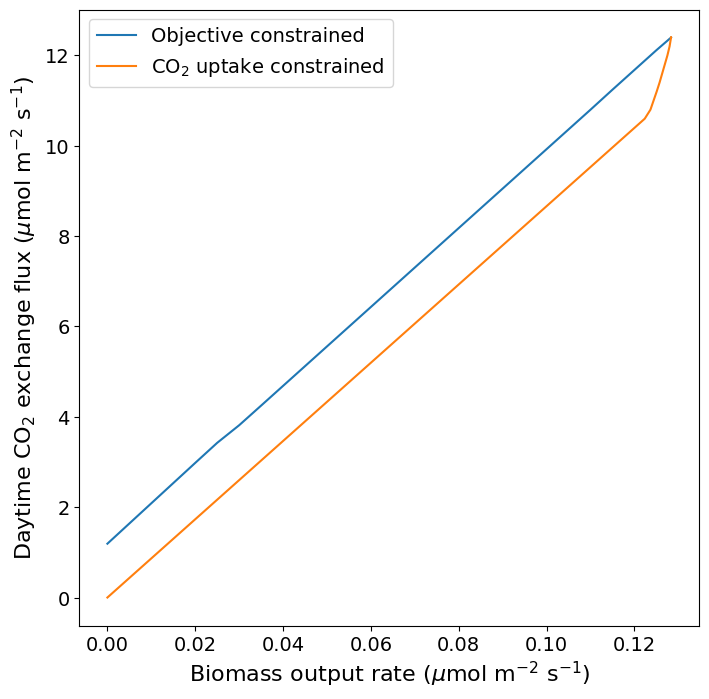

In [74]:
# Plot results of scanning over objective upper bound vs CO2 uptake upper bound
import matplotlib.pyplot as plt

# Create a larger figure
plt.figure(figsize=(8, 8))  # Width = 10 inches, Height = 8 inches

# Plot the results
plt.plot(df_A1.T[output_string+"_total"], df_A1.T["CO2_tx_00"], label="Objective constrained")
plt.plot(df_B1.T[output_string+"_total"], df_B1.T["CO2_tx_00"], label="CO$_2$ uptake constrained")

# Add labels and title with larger fonts
plt.xlabel("Biomass output rate ($\mu$mol m$^{-2}$ s$^{-1}$)", fontsize=16)
plt.ylabel("Daytime CO$_2$ exchange flux ($\mu$mol m$^{-2}$ s$^{-1}$)", fontsize=16)
# plt.title("Scanning Results", fontsize=18)

# Increase font size of tick marks
plt.tick_params(axis='both', which='major', labelsize=14)


# Add legend with larger font
plt.legend(fontsize=14)

# Save and show the plot
plt.savefig("Ch1_method_comp.png", dpi=300, bbox_inches='tight')
plt.show()

In [33]:
df_name_list = ["objective constrained", "CO2 constrained"]
df_list = [df_A1, df_B1]


In [83]:
df_B1

,15.0,14.8,14.6,14.4,14.2,14.0,13.8,13.6,13.4,13.2,...,1.8,1.6,1.4,1.2,1.0,0.8,0.6,0.4,0.2,0.0
reactions,,,,,,,,,,,,,,,,,,,,,
PRO_PROTON_vc_00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001292,0.001148,0.001005,0.000861,0.000718,0.000574,0.000431,0.000287,0.000144,0.000000
Ca_tx_00,0.084695,0.084695,0.084695,0.084695,0.084695,0.084695,0.084695,0.084695,0.084695,0.084695,...,0.013711,0.012187,0.010664,0.009141,0.007617,0.006094,0.004570,0.003047,0.001523,0.000000
H2O_xc_00,4.928536,4.928536,4.928536,4.928536,4.928536,4.928536,4.928536,4.928536,4.928536,4.928536,...,1.319069,1.238744,1.158418,1.078093,0.997768,0.917442,0.837117,0.756792,0.676466,0.596141
sCIT_biomass_00,-0.025382,-0.025382,-0.025382,-0.025382,-0.025382,-0.025382,-0.025382,-0.025382,-0.025382,-0.025382,...,-0.004109,-0.003652,-0.003196,-0.002739,-0.002283,-0.001826,-0.001370,-0.000913,-0.000457,0.000000
ACETYLGLUTKIN_RXN_p_00,0.031916,0.031916,0.031916,0.031916,0.031916,0.031916,0.031916,0.031916,0.031916,0.031916,...,0.003875,0.003444,0.003014,0.002583,0.002153,0.001722,0.001292,0.000861,0.000431,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
daytime CO2 uptake ub,15.000000,14.800000,14.600000,14.400000,14.200000,14.000000,13.800000,13.600000,13.400000,13.200000,...,1.800000,1.600000,1.400000,1.200000,1.000000,0.800000,0.600000,0.400000,0.200000,0.000000
scan process ub,15.000000,14.800000,14.600000,14.400000,14.200000,14.000000,13.800000,13.600000,13.400000,13.200000,...,1.800000,1.600000,1.400000,1.200000,1.000000,0.800000,0.600000,0.400000,0.200000,0.000000
total aa day,0.220097,0.220097,0.220097,0.220097,0.220097,0.220097,0.220097,0.220097,0.220097,0.220097,...,0.039479,0.035092,0.030706,0.026319,0.021933,0.017546,0.013160,0.008773,0.004387,0.000000


In [84]:
# Convert column names to integers if they are numeric and end in .0
df_B1.columns = [
    int(float(col)) if isinstance(col, str) and col.replace('.', '', 1).isdigit() and float(col).is_integer() else col
    for col in df_B1.columns
]

# Display the updated DataFrame
df_B1

,15,14.8,14.6,14.4,14.2,14,13.8,13.6,13.4,13.2,...,1.8,1.6,1.4,1.2,1,0.8,0.6,0.4,0.2,0
reactions,,,,,,,,,,,,,,,,,,,,,
PRO_PROTON_vc_00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001292,0.001148,0.001005,0.000861,0.000718,0.000574,0.000431,0.000287,0.000144,0.000000
Ca_tx_00,0.084695,0.084695,0.084695,0.084695,0.084695,0.084695,0.084695,0.084695,0.084695,0.084695,...,0.013711,0.012187,0.010664,0.009141,0.007617,0.006094,0.004570,0.003047,0.001523,0.000000
H2O_xc_00,4.928536,4.928536,4.928536,4.928536,4.928536,4.928536,4.928536,4.928536,4.928536,4.928536,...,1.319069,1.238744,1.158418,1.078093,0.997768,0.917442,0.837117,0.756792,0.676466,0.596141
sCIT_biomass_00,-0.025382,-0.025382,-0.025382,-0.025382,-0.025382,-0.025382,-0.025382,-0.025382,-0.025382,-0.025382,...,-0.004109,-0.003652,-0.003196,-0.002739,-0.002283,-0.001826,-0.001370,-0.000913,-0.000457,0.000000
ACETYLGLUTKIN_RXN_p_00,0.031916,0.031916,0.031916,0.031916,0.031916,0.031916,0.031916,0.031916,0.031916,0.031916,...,0.003875,0.003444,0.003014,0.002583,0.002153,0.001722,0.001292,0.000861,0.000431,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
daytime CO2 uptake ub,15.000000,14.800000,14.600000,14.400000,14.200000,14.000000,13.800000,13.600000,13.400000,13.200000,...,1.800000,1.600000,1.400000,1.200000,1.000000,0.800000,0.600000,0.400000,0.200000,0.000000
scan process ub,15.000000,14.800000,14.600000,14.400000,14.200000,14.000000,13.800000,13.600000,13.400000,13.200000,...,1.800000,1.600000,1.400000,1.200000,1.000000,0.800000,0.600000,0.400000,0.200000,0.000000
total aa day,0.220097,0.220097,0.220097,0.220097,0.220097,0.220097,0.220097,0.220097,0.220097,0.220097,...,0.039479,0.035092,0.030706,0.026319,0.021933,0.017546,0.013160,0.008773,0.004387,0.000000


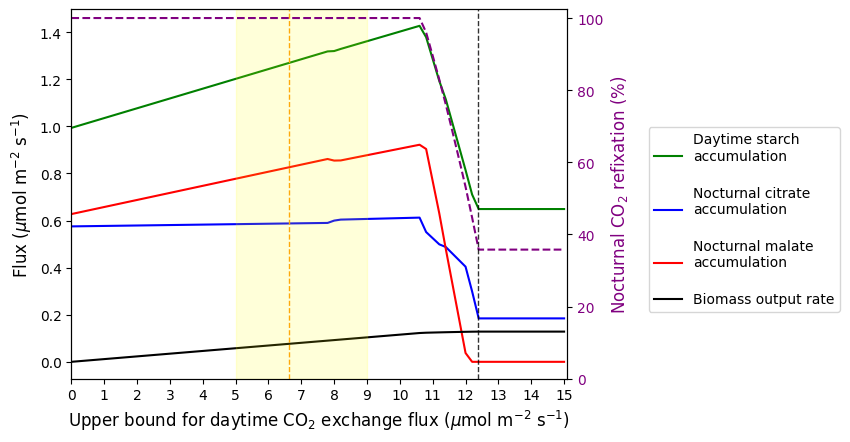

In [111]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# # Reverse the DataFrame
df_B1 = df_B1.iloc[:, ::-1]

# Plot the CO2 uptake
# ax1.plot(df_B1.columns, df_B1.T["noct. CO2 coeff."], label="nCO2R", color='black')
ax1.plot(df_B1.columns, df_B1.T["STARCH_p_linker_00_to_12"], label="Daytime starch \naccumulation\n", color='green')
ax1.plot(df_B1.columns, abs(df_B1.T["CIT_v_linker_12_to_00"]), label="Nocturnal citrate \naccumulation\n", color='blue')
ax1.plot(df_B1.columns, abs(df_B1.T["MAL_v_linker_12_to_00"]), label="Nocturnal malate \naccumulation\n", color='red')
ax1.plot(df_B1.columns, df_B1.T["AraCore_Biomass_tx_total"], label="Biomass output rate", color='black')
# ax1.plot(df_B1.columns, df_B1.T["CO2_tx_00"], label="Daytime CO2 uptake", color='orange')
# ax1.plot(df_B1.columns, df_B1.T["photon use"], label="Photon use", color='purple')



ax1.set_ylabel("Flux ($\mu$mol m$^{-2}$ s$^{-1}$)", fontsize = 12)
ax1.tick_params(axis='y', labelcolor='black')

ax1.set_xlabel("Upper bound for daytime CO$_2$ exchange flux ($\mu$mol m$^{-2}$ s$^{-1}$)", fontsize = 12)
ax1.tick_params(axis='x')
ax1.set_xlim(0, 15.1)
plt.legend(loc='upper left', bbox_to_anchor=(1.15, 0.7))

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Nocturnal CO$_2$ refixation (%)', color = 'purple', fontsize = 12)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor='purple')
ax2.plot(df_B1.columns, df_B1.T["noct. CO2 coeff."]*100, label="nCO2R", color='purple', linestyle='--')
ax2.set_ylim(0, 102.5)

# Add a shaded area for experimental CO2 uptake data (5-9 umol/m2/s)
plt.axvspan(5, 9, color='yellow', alpha=0.15)
# # Add a vertical line at x=6.634
plt.axvline(x=6.634, linestyle='--', color='orange', linewidth=1, alpha=0.95)

# # Add a vertical line at x=12.380 (previous CO2 uptake rate in model)
plt.axvline(x=12.380, linestyle='--', color='black', linewidth=1, alpha=0.8)


# Add title and legend
# plt.title("Reducing CO2 uptake rates shifts metabolic behaviour")
# plt.legend()
# Set x-axis ticks to show every integer value
plt.xticks(ticks=range(int(plt.xlim()[0]), int(plt.xlim()[1]) + 1))

# Show the plot
plt.savefig("Ch1_CO2_ub_scan.png", dpi=300, bbox_inches='tight')
plt.show()

#################################################################################
# reduce tick marks on x axis

## Create C3, CAM-cycling modelling scenario at set CO2 uptake rate

### C3 model (via indirect CO2 constraint)

In [35]:
### C3
# use loop to constrain objective flux until the CO2 uptake rate reaches the desired value
C3_model = diel_model.copy()

CO2_uptake = 6.643
#unconstrain the CO2 uptake
C3_model.reactions.get_by_id("CO2_tx"+day_tag).upper_bound = 1000
# constrain night-time CO2 uptake to 0, CO2 can only be lost at night
C3_model.reactions.get_by_id("CO2_tx"+night_tag).upper_bound = 0
C3_model.reactions.get_by_id("CO2_tx"+night_tag).lower_bound = -1000

#run estimateOutput function to determine output flux at unconstrained desired CO2 uptake rate, hence output at experimental CO2 uptake rate without inducing lots of carbon refixation
solution_C3, C3_model_opt, _ = estimateOutputFromNetCO2_Corinna_dev(C3_model,netCO2uptake=CO2_uptake,Output_ID=output_string+"_total",
                                      Vc_ID="RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p"+day_tag,
                                      CO2in_ID="CO2_tx"+day_tag,verbose=True, iterations=50, pFBA=True)
calculate_noct_CO2_refixation_coefficient(C3_model_opt, verbose=True, threshold = 0.00001, show_noflux = False)




Model can achieve desired CO2 rate, without discouraging CO2 refixation.
0.07666792062071259
First optimisation (unconstrained CO2 uptake): Model is feasible.
Starting CO2 uptake = 12.397209573805899
Starting output flux: AraCore_Biomass_tx_total = 0.12832604692659602


---- CO2 adjustment iteration 1 ----
CCE: 89.69
Factor: 0.5358
prev: 0.12832604692659602
now: 0.06876304902794929
Optimisation successful.
Vc flux = 8.591307579150202
Current CO2 uptake = 7.198474039670621
Target CO2 uptake = 6.643
Output_ID before: 0.12832604692659602
Output_ID after: 0.06876304902794929
CCE: 82.77
Sum of fluxes: 794.8827658091876


---- CO2 adjustment iteration 2 ----
CCE: 82.77
Factor: 0.9228
prev: 0.06876304902794929
now: 0.06345691214211402
Optimisation successful.
Vc flux = 8.03871665340437
Current CO2 uptake = 6.734968206169619
Target CO2 uptake = 6.643
Output_ID before: 0.06876304902794929
Output_ID after: 0.06345691214211402
CCE: 81.64
Sum of fluxes: 748.2870795454361


---- CO2 adjustment iter

0.26360495584536014

In [36]:
model_results_overview(C3_model_opt, solution_C3, output_string+"_total")

Photon uptake = 111.3289   % of allowed Photon uptake = 55.66
Output rate (AraCore_Biomass_tx_total) 0.0624		sum of fluxes: 739.0941
gas exchange = Day: 6.64352 Night: -1.23592
CCE: 0.8139668824945816
ATPase: 3.7651 3.7651
Rubisco Carbox./Oxygen. = 7.9297/2.6432

Linker fluxes 		 Day 	 Night
VAL_v_linker                         0.0       0.0

NITRATE_v_linker                     0.0             0.18977

CIT_v_linker                         0.0              0.0866

PHE_v_linker                      0.0037       0.0

STARCH_p_linker                  0.41067                 0.0

LYS_v_linker                       0.004       0.0

MET_v_linker                      0.0017       0.0

MAL_v_linker                         0.0                 0.0

CYS_v_linker                         0.0       0.0

4_AMINO_BUTYRATE_v_linker                 0.0             0.00451

L_ASPARTATE_v_linker                 0.0       0.0

L_ALPHA_ALANINE_v_linker                 0.0       0.0

FRU_v_linker            

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


In [37]:
model = C3_model_opt
model_name = "C3_indirect_opt"

for rxn in CO2_rxns:
    # print(model.reactions.get_by_id(rxn).id)
    # print(model.reactions.get_by_id(rxn).flux)
    
    CO2_rxns_dict[rxn].append(model.reactions.get_by_id(rxn).flux)

CO2_rxns_dict

NameError: name 'CO2_rxns' is not defined

### CAM cycling model via direct CO2 uptake constraint

In [ ]:
### CAM-cycling
# just optimise for maximum objective flux with CO2-uptake rate constraint in place, no constraint on CAM enzymes
CAM_cyc_model = diel_model.copy()

# constrain daytime CO2 uptake to 6 umol/m2/s
CO2_uptake = 6.643
CAM_cyc_model.reactions.get_by_id("CO2_tx"+day_tag).upper_bound = CO2_uptake

# constrain night-time CO2 uptake to 0, CO2 can only be lost at night
CAM_cyc_model.reactions.get_by_id("CO2_tx"+night_tag).upper_bound = 0
CAM_cyc_model.reactions.get_by_id("CO2_tx"+night_tag).lower_bound = -1000

print("CO2 daytime uptake: ", CAM_cyc_model.reactions.get_by_id("CO2_tx"+day_tag).bounds)
print("CO2 night-time uptake: ", CAM_cyc_model.reactions.get_by_id("CO2_tx"+night_tag).bounds)

solution_CAM_cyc, CAM_cyc_model_opt = optimise_model(CAM_cyc_model, output_string+"_total", pFBA=True)


CO2 daytime uptake:  (0.0, 6.643)
CO2 night-time uptake:  (-1000, 0)
Objective: AraCore_Biomass_tx_total


In [ ]:
model_results_overview(CAM_cyc_model_opt, solution_CAM_cyc, output_string+"_total")

Photon uptake = 139.1162   % of allowed Photon uptake = 69.56
Output rate (AraCore_Biomass_tx_total) 0.0767		sum of fluxes: 972.0621
gas exchange = Day: 6.643 Night: -0.0
CCE: 0.9999999999999998
ATPase: 3.7651 3.7651
Rubisco Carbox./Oxygen. = 9.7924/3.2641

Linker fluxes 		 Day 	 Night
VAL_v_linker                         0.0       0.0

NITRATE_v_linker                     0.0             0.23312

CIT_v_linker                         0.0             0.58775

PHE_v_linker                     0.00455       0.0

STARCH_p_linker                   1.2702                 0.0

LYS_v_linker                         0.0       0.0

MET_v_linker                     0.00208       0.0

MAL_v_linker                         0.0             0.82675

CYS_v_linker                         0.0       0.0

4_AMINO_BUTYRATE_v_linker                 0.0                 0.0

L_ASPARTATE_v_linker                 0.0       0.0

L_ALPHA_ALANINE_v_linker                 0.0       0.0

FRU_v_linker                  

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


In [ ]:
model = CAM_cyc_model_opt
model_name = "CO2_direct_opt"

for rxn in CO2_rxns:
    # print(model.reactions.get_by_id(rxn).id)
    # print(model.reactions.get_by_id(rxn).flux)
    
    CO2_rxns_dict[rxn].append(model.reactions.get_by_id(rxn).flux)

CO2_rxns_dict

{'CO2_tx_12': [-1.2611640158317665,
  -1.231073727194467,
  5.727518646779929e-14,
  -0.9662795678210342,
  -1.2359151744723074,
  -1.7878542041230546e-15,
  -0.9662795678208835,
  -0.9699647588612537,
  -1.2359151744723074,
  -1.7878542041230546e-15,
  -1.2359151744723074,
  -1.7878542041230546e-15,
  -0.9699647588612537,
  -1.2359151744723074,
  -1.7878542041230546e-15],
 'ISOCITDEH_RXN_m_12': [0.4183444444444444,
  0.4183444444444444,
  0.4183444444444444,
  0.3137467551111752,
  0.4183444444444444,
  0.4183444444444444,
  0.3137467551109986,
  0.3138146574275176,
  0.4183444444444444,
  0.4183444444444444,
  0.4183444444444444,
  0.4183444444444444,
  0.3138146574275176,
  0.4183444444444444,
  0.4183444444444444],
 'ISOCITDEH_RXN_c_12': [-0.2704828796178589,
  -0.22564845673769748,
  -0.39117308220067865,
  -0.3977921544811913,
  -0.22186412468583575,
  -0.39117308220067887,
  -0.3977921544811914,
  -0.39780549653594605,
  -0.22186412468583575,
  -0.39117308220067887,
  -0.2218641

solution_CAM_cyc (results 20/08/2024):

- not light-limited (60.6% photo use = 200 PPFD)
- citrate accumulation = 0.4485 night to day
- malate accumulation = 0.63122 night to day
- nocturnal CO2 refixation = 100%
- total carbon use efficiency = 100%

## constrain CO2-refixing behaviour by cumulatively turning of nocturnal CO2-fixing enzyme

In [ ]:
# reference model, CAM allowed
solution_CAM_cyc, CAM_cyc_model_opt = optimise_model(CAM_cyc_model, output_string+"_total", pFBA=True)
print("objective flux:", CAM_cyc_model_opt.reactions.AraCore_Biomass_tx_total.flux)

calculate_noct_CO2_refixation_coefficient(CAM_cyc_model_opt, verbose=True, threshold = 0.00001, show_noflux = False)

print("sum of fluxes:", calculate_sum_of_all_fluxes(solution_CAM_cyc))
print("photon use:", CAM_cyc_model_opt.reactions.Photon_tx_00.flux)

Objective: AraCore_Biomass_tx_total


objective flux: 0.07666792062070978
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.471149
producing HCO3-:	RXN0_5224_c_12	1.471149
producing CO2:	CO2_pc_12	0.394762
consuming CO2:	ISOCITDEH_RXN_c_12	-0.391173
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.021753
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001847
producing CO2:	CO2_mc_12	1.039596
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.401194
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.471149
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.00317
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.004915
producing CO2:	RXN_9652_p_12	0.014781
producing CO2:	RXN_9650_p_12	0.014781
producing CO2:	2.3.1.180_RXN_p_12	0.014781
producing CO2:	RXN_9654_p_12	0.014781
consuming CO2:	RXN0_5224_p_12	0.103465
producing HCO3-:	RXN0_5224_p_12	0.103465
consuming CO2:	CO2_pc_12	0.394762
producing CO2:	1.2.1.2_RXN_p_12	0.002449
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.103465
producing CO2:	PYRUVDEH_RXN_p_12	0.11824

Main noct. CO2-fixing enzyme is:
- cytosolic CA (74.656%)
- cICDH (19.85%)
- plastidic CA (5.25%)

HCO3 fixing enzymes
    - PEPC c (93.43%)
    - Acetyl_CoA carboxyltransferase (6.57%)

objective flux: 0.07666792062071394

Objective: AraCore_Biomass_tx_total
objective flux: 0.07666792062071424
----- Cytosol -----
consuming CO2:	CO2_pc_12	-1.076759
consuming CO2:	ISOCITDEH_RXN_c_12	-0.392447
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.021753
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001847
producing CO2:	CO2_mc_12	1.039967
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.402468
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.00317
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.004915
producing CO2:	RXN_9652_p_12	0.014781
producing CO2:	RXN_9650_p_12	0.014781
producing CO2:	2.3.1.180_RXN_p_12	0.014781
producing CO2:	RXN_9654_p_12	0.014781
consuming CO2:	RXN0_5224_p_12	1.573711
producing HCO3-:	RXN0_5224_p_12	1.573711
producing CO2:	CO2_pc_12	-1.076759
producing CO2:	1.2.1.2_RXN_p_12	0.001176
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.103465
producing CO2:	PYRUVDEH_RXN_p_12	0.118245
producing CO2:	RXN_9653_p_12	0.014781
producing CO2:	RXN_9651_p_12	0.014781
consuming

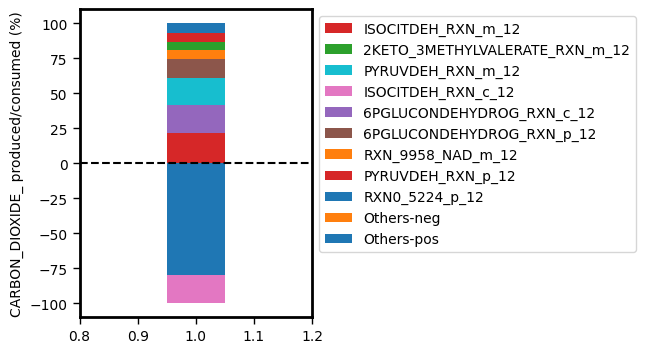

In [ ]:
# turn off cytosolic PEPC

CAM_lim_model_1 = CAM_cyc_model.copy()
CAM_lim_model_1.reactions.PEPCARBOX_RXN_c_12.bounds = (0, 0)

model = CAM_lim_model_1

solution_model, model_opt = optimise_model(model, output_string+"_total", pFBA=True)
print("objective flux:", model_opt.reactions.AraCore_Biomass_tx_total.flux)

calculate_noct_CO2_refixation_coefficient(model_opt, verbose=True, threshold = 0.00001, show_noflux = False)

generateMetaboliteBudget(model_opt, solution_model, show_plot=True, percentage=True, day_or_night_tag="_12", 
                         metabolite="CARBON_DIOXIDE_", threshold=0.05, colourDict=colourDict_CO2)

print("sum of fluxes:", calculate_sum_of_all_fluxes(solution_model))
print("photon use:", model_opt.reactions.Photon_tx_00.flux)

Main noct. CO2-fixing enzyme is:
- plastidic CA (79.846%)
- cICDH (19.9118%)

HCO3 fixing enzymes
    - PEPC p (93.425%)
    - Acetyl_CoA carboxyltransferase (6.57%)

objective flux: 0.07666792062071486

Objective: AraCore_Biomass_tx_total
objective flux: 0.06408360850736416
----- Cytosol -----
producing CO2:	CO2_pc_12	0.365231
consuming CO2:	ISOCITDEH_RXN_c_12	-0.398241
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.018183
producing CO2:	CO2_mc_12	1.105213
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.004108
producing CO2:	RXN_9652_p_12	0.012355
producing CO2:	RXN_9650_p_12	0.012355
producing CO2:	RXN_5682_p_12	0.00265
producing CO2:	2.3.1.180_RXN_p_12	0.012355
producing CO2:	RXN_9654_p_12	0.012355
consuming CO2:	RXN0_5224_p_12	0.086482
producing HCO3-:	RXN0_5224_p_12	0.086482
consuming CO2:	CO2_pc_12	0.365231
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.086482
producing CO2:	PYRUVDEH_RXN_p_12	0.098836
producing CO2:	RXN_9653_p_12	0.012355
producing CO2:	RXN_9651_p_12	0.012355
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.003985
producing CO2:	RXN_9648_p_12	0.012355
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.258622
producing CO2:	ACETOLACTSYN_RXN_p_12

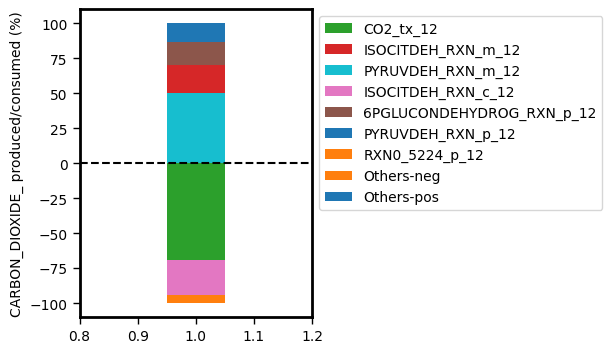

In [ ]:
# turn off cytosolic PEPC
# + turn off plastidic PEPC

model.reactions.PEPCARBOX_RXN_p_12.bounds = (0, 0)

solution_model, model_opt = optimise_model(model, output_string+"_total", pFBA=True)
print("objective flux:", model_opt.reactions.AraCore_Biomass_tx_total.flux)

calculate_noct_CO2_refixation_coefficient(model_opt, verbose=True, threshold = 0.00001, show_noflux = False)

generateMetaboliteBudget(model_opt, solution_model, show_plot=True, percentage=True, day_or_night_tag="_12", 
                         metabolite="CARBON_DIOXIDE_", threshold=0.05, colourDict=colourDict_CO2)

print("sum of fluxes:", calculate_sum_of_all_fluxes(solution_model))

Main noct. CO2-fixing enzyme is:
- CO2_tx (69.051%)
- cICDH (25.219%)
- p CA (5.4766%)

HCO3 fixing enzymes (0.08648)
    - Acetyl_CoA carboxyltransferase (100%)

objective flux: 0.06408360850736419

Objective: AraCore_Biomass_tx_total
objective flux:  0.06380943226094878
----- Cytosol -----
producing CO2:	CO2_pc_12	0.364563
consuming CO2:	CO2_xc_12	-0.199164
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.018105
producing CO2:	CO2_mc_12	0.930637
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.004091
producing CO2:	RXN_9652_p_12	0.012302
producing CO2:	RXN_9650_p_12	0.012302
producing CO2:	RXN_5682_p_12	0.002639
producing CO2:	2.3.1.180_RXN_p_12	0.012302
producing CO2:	RXN_9654_p_12	0.012302
consuming CO2:	RXN0_5224_p_12	0.086112
producing HCO3-:	RXN0_5224_p_12	0.086112
consuming CO2:	CO2_pc_12	0.364563
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.086112
producing CO2:	PYRUVDEH_RXN_p_12	0.098414
producing CO2:	RXN_9653_p_12	0.012302
producing CO2:	RXN_9651_p_12	0.012302
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.003967
producing CO2:	RXN_9648_p_12	0.012302
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.25841
producing CO2:	ACETOLACTSYN_RXN_p_12	0.00497

({'Others-pos': 7.360942107133725,
  'Others-neg': -0.24757398397487493,
  'CO2_tx_12': -69.523118594715,
  'PYRUVDEH_RXN_m_12': 38.19711448591031,
  'ISOCITDEH_RXN_x_12': -24.85587365354587,
  'ISOCITDEH_RXN_m_12': 19.747994096146538,
  '6PGLUCONDEHYDROG_RXN_p_12': 16.12494532087732,
  '6PGLUCONDEHYDROG_RXN_x_12': 12.427936826772937,
  'PYRUVDEH_RXN_p_12': 6.141067163159164,
  'RXN0_5224_p_12': -5.373433767764248},
                                value
 Others-pos                  7.360942
 Others-neg                 -0.247574
 CO2_tx_12                 -69.523119
 PYRUVDEH_RXN_m_12          38.197114
 ISOCITDEH_RXN_x_12        -24.855874
 ISOCITDEH_RXN_m_12         19.747994
 6PGLUCONDEHYDROG_RXN_p_12  16.124945
 6PGLUCONDEHYDROG_RXN_x_12  12.427937
 PYRUVDEH_RXN_p_12           6.141067
 RXN0_5224_p_12             -5.373434)

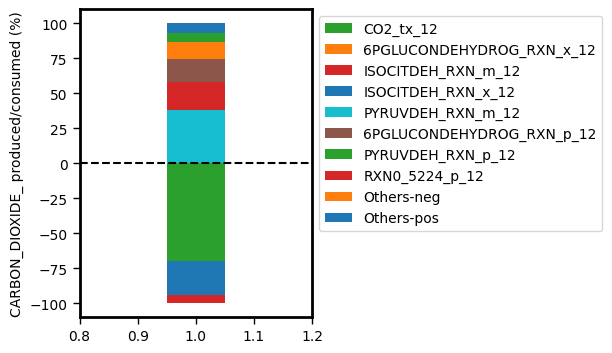

In [ ]:
# turn off cytosolic PEPC
# + turn off plastidic PEPC
# + turn off cytosolic ICDH

model.reactions.ISOCITDEH_RXN_c_12.bounds = (0, 1000)


solution_model, model_opt = optimise_model(model, output_string+"_total", pFBA=True)

print("objective flux: ", model_opt.reactions.AraCore_Biomass_tx_total.flux)

calculate_noct_CO2_refixation_coefficient(model_opt, verbose=True, threshold = 0.00001, show_noflux = False)

generateMetaboliteBudget(model_opt, solution_model, show_plot=True, percentage=True, day_or_night_tag="_12", 
                         metabolite="CARBON_DIOXIDE_", threshold=0.05, colourDict=colourDict_CO2)

Main noct. CO2-fixing enzyme is:
- CO2_tx (69.52%)
- x ICDH (24.855%)
- p CA (5.373%)

objective flux:  0.06380943226094879

Objective: AraCore_Biomass_tx_total
objective flux:  0.06332530281583294
----- Cytosol -----
producing CO2:	CO2_pc_12	0.562624
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.017968
producing CO2:	CO2_mc_12	0.575498
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.00406
producing CO2:	RXN_9652_p_12	0.012208
producing CO2:	RXN_9650_p_12	0.012208
producing CO2:	RXN_5682_p_12	0.002619
producing CO2:	2.3.1.180_RXN_p_12	0.012208
producing CO2:	RXN_9654_p_12	0.012208
consuming CO2:	RXN0_5224_p_12	0.085459
producing HCO3-:	RXN0_5224_p_12	0.085459
consuming CO2:	CO2_pc_12	0.562624
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.085459
producing CO2:	PYRUVDEH_RXN_p_12	0.097667
producing CO2:	RXN_9653_p_12	0.012208
producing CO2:	RXN_9651_p_12	0.012208
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.003937
producing CO2:	RXN_9648_p_12	0.012208
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.457276
producing CO2:	ACETOLACTSYN_RXN_p_12	0.00494
----- Mitochondrion -----
producin

({'Others-pos': 1.028211773641915,
  'Others-neg': -0.296776161503408,
  'CO2_tx_12': -87.13888292416001,
  'PYRUVDEH_RXN_m_12': 49.34799584038994,
  '6PGLUCONDEHYDROG_RXN_p_12': 34.46664243655332,
  'PYRUVDEH_RXN_p_12': 7.361526081901078,
  'RXN0_5224_p_12': -6.441335321663434,
  'ISOCITDEH_RXN_m_12': -6.1230055926731355,
  'UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12': 1.3542885458502996,
  'RXN_9651_p_12': 0.9201907602376346,
  'RXN_9648_p_12': 0.9201907602376346,
  'RXN_9650_p_12': 0.9201907602376346,
  'RXN_9653_p_12': 0.9201907602376346,
  'RXN_9652_p_12': 0.9201907602376346,
  '2.3.1.180_RXN_p_12': 0.9201907602376342,
  'RXN_9654_p_12': 0.9201907602376342},
                                             value
 Others-pos                               1.028212
 Others-neg                              -0.296776
 CO2_tx_12                              -87.138883
 PYRUVDEH_RXN_m_12                       49.347996
 6PGLUCONDEHYDROG_RXN_p_12               34.466642
 PYRUVDEH_RXN_p_12        

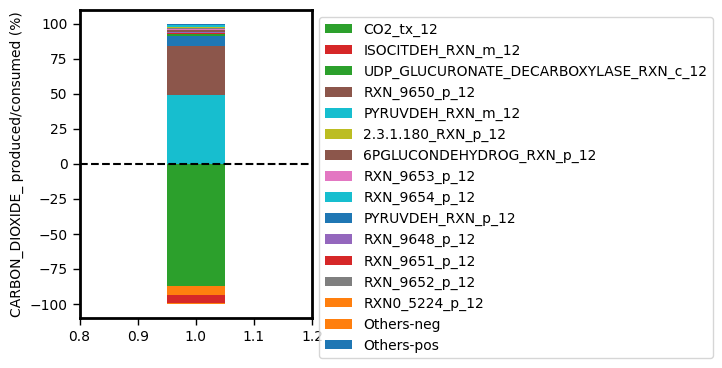

In [ ]:
# turn off cytosolic PEPC
# + turn off plastidic PEPC
# + turn of cytosolic ICDH
# + turn of peroxisomal ICDH

model.reactions.ISOCITDEH_RXN_x_12.bounds = (0, 1000)


solution_model, model_opt = optimise_model(model, output_string+"_total", pFBA=True)

print("objective flux: ", model_opt.reactions.AraCore_Biomass_tx_total.flux)

calculate_noct_CO2_refixation_coefficient(model_opt, verbose=True, threshold = 0.00001, show_noflux = False)

generateMetaboliteBudget(model_opt, solution_model, show_plot=True, percentage=True, day_or_night_tag="_12", 
                         metabolite="CARBON_DIOXIDE_", threshold=0.005, colourDict=colourDict_CO2)

Main noct. CO2-fixing enzyme is:
- CO2_tx (87.138%)
- p CA (6.44%)
- m ICDH (6.123%)

objective flux:  0.06332530281583279

Objective: AraCore_Biomass_tx_total
objective flux:  0.06323656698362952
----- Cytosol -----
producing CO2:	CO2_pc_12	0.562422
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.017942
producing CO2:	CO2_mc_12	0.583414
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.004054
producing CO2:	RXN_9652_p_12	0.012191
producing CO2:	RXN_9650_p_12	0.012191
producing CO2:	RXN_5682_p_12	0.002615
producing CO2:	2.3.1.180_RXN_p_12	0.012191
producing CO2:	RXN_9654_p_12	0.012191
consuming CO2:	RXN0_5224_p_12	0.085339
producing HCO3-:	RXN0_5224_p_12	0.085339
consuming CO2:	CO2_pc_12	0.562422
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.085339
producing CO2:	PYRUVDEH_RXN_p_12	0.09753
producing CO2:	RXN_9653_p_12	0.012191
producing CO2:	RXN_9651_p_12	0.012191
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.003932
producing CO2:	RXN_9648_p_12	0.012191
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.457222
producing CO2:	ACETOLACTSYN_RXN_p_12	0.004933
----- Mitochondrion -----
produci

({'Others-pos': 8.762270901854823,
  'Others-neg': -0.29470552603866995,
  'CO2_tx_12': -87.22861615946992,
  'PYRUVDEH_RXN_m_12': 43.577176467718665,
  '6PGLUCONDEHYDROG_RXN_p_12': 34.27010381402557,
  'PYRUVDEH_RXN_p_12': 7.310164015276148,
  'RXN0_5224_p_12': -6.39639351336658,
  'RXN0_5224_m_12': -6.0802848011247965,
  '2KETO_4METHYL_PENTANOATE_DEHYDROG_RXN_m_12': 6.0802848011247965},
                                                 value
 Others-pos                                   8.762271
 Others-neg                                  -0.294706
 CO2_tx_12                                  -87.228616
 PYRUVDEH_RXN_m_12                           43.577176
 6PGLUCONDEHYDROG_RXN_p_12                   34.270104
 PYRUVDEH_RXN_p_12                            7.310164
 RXN0_5224_p_12                              -6.396394
 RXN0_5224_m_12                              -6.080285
 2KETO_4METHYL_PENTANOATE_DEHYDROG_RXN_m_12   6.080285)

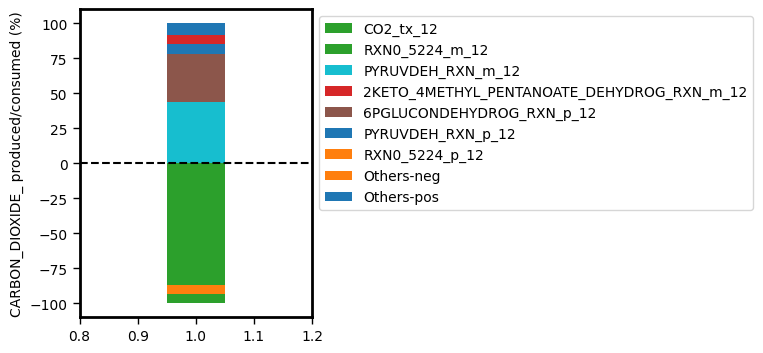

In [ ]:
# turn off cytosolic PEPC
# + turn off plastidic PEPC
# + turn off cytosolic ICDH
# + turn off peroxisomal ICDH
# + turn off mitochondrial ICDH

model.reactions.ISOCITDEH_RXN_m_12.bounds = (0, 1000)


solution_model, model_opt = optimise_model(model, output_string+"_total", pFBA=True)

print("objective flux: ", model_opt.reactions.AraCore_Biomass_tx_total.flux)

calculate_noct_CO2_refixation_coefficient(model_opt, verbose=True, threshold = 0.00001, show_noflux = False)

generateMetaboliteBudget(model_opt, solution_model, show_plot=True, percentage=True, day_or_night_tag="_12", 
                         metabolite="CARBON_DIOXIDE_", threshold=0.05, colourDict=colourDict_CO2)

Total: 0.16646017504422722


({'Others-pos': 3.9011434161204414e-13,
  'Others-neg': 0.0,
  'ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12': -51.266798358801466,
  'RXN0_5224_p_12': 51.266798358801076,
  'RXN0_5224_m_12': 48.73320164119853,
  'METHYLCROTONYL_COA_CARBOXYLASE_RXN_m_12': -48.73320164119853},
                                                 value
 Others-pos                               3.901143e-13
 Others-neg                               0.000000e+00
 ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12    -5.126680e+01
 RXN0_5224_p_12                           5.126680e+01
 RXN0_5224_m_12                           4.873320e+01
 METHYLCROTONYL_COA_CARBOXYLASE_RXN_m_12 -4.873320e+01)

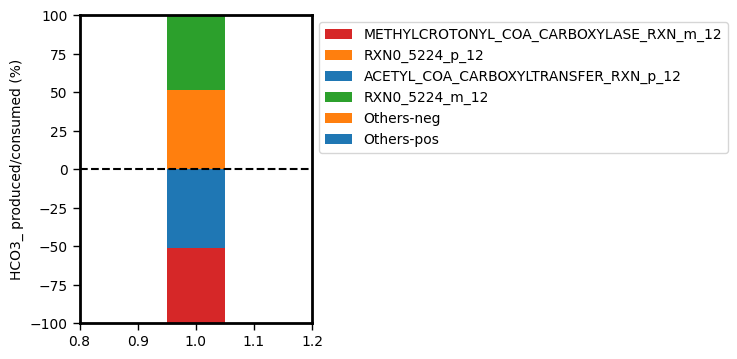

In [ ]:
generateMetaboliteBudget(model_opt, solution_model, show_plot=True, percentage=True, day_or_night_tag="_12", 
                         metabolite="HCO3_", threshold=0.05, colourDict=colourDict_CO2)

Main noct. CO2-fixing enzyme is:
- CO2_tx (87.228%)
- p CA (6.396%)
- m CA (6.080%)

HCO3-fixing enzymes (0.16646)
- Acetyl CoA carboxyltransferase p (51.266%)
- METHYLCROTONYL_COA_CARBOXYLASE_RXN_m (48.73%)

objective flux:  0.06323656698362949

In [ ]:
diel_model.reactions.METHYLCROTONYL_COA_CARBOXYLASE_RXN_m_12

Reaction identifier,METHYLCROTONYL_COA_CARBOXYLASE_RXN_m_12
Name,METHYLCROTONYL-COA-CARBOXYLASE-RXN:Methylcrotonyl-CoA carboxylase
Memory address,0x7f25aa7460b0
Stoichiometry,3_METHYL_CROTONYL_COA_m_12 + ATP_m_12 + HCO3_m_12 --> ADP_m_12 + PROTON_m_12 + Pi_m_12 + TRANS_3_METHYL_GLUTACONYL_COA_m_12 3-METHYL-CROTONYL-COA + ATP + HCO3 --> ADP + PROTON + Pi[m] + TRANS-3-METHYL-GLUTACONYL-COA
GPR,
Lower bound,0.0
Upper bound,1000.0


Objective: AraCore_Biomass_tx_total
objective flux:  0.06285814276825807
----- Cytosol -----
producing CO2:	CO2_pc_12	0.543937
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.017835
producing CO2:	CO2_mc_12	0.634795
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.012118
producing CO2:	RXN_9650_p_12	0.012118
producing CO2:	2.3.1.180_RXN_p_12	0.012118
producing CO2:	RXN_9654_p_12	0.012118
consuming CO2:	RXN0_5224_p_12	0.084828
producing HCO3-:	RXN0_5224_p_12	0.084828
consuming CO2:	CO2_pc_12	0.543937
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.084828
producing CO2:	PYRUVDEH_RXN_p_12	0.096946
producing CO2:	RXN_9653_p_12	0.012118
producing CO2:	RXN_9651_p_12	0.012118
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.003908
producing CO2:	RXN_9648_p_12	0.012118
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.450899
----- Mitochondrion -----
producing CO2:	1.2.1.2_RXN_m_12	0.002008
producing CO2:	PYRUVDEH_RXN_m_12	0.632787
consuming CO2:	CO2_mc_12	0.634795
----- Peroxisome -----


({'Others-pos': 8.143703311888423,
  'Others-neg': -0.3040794075548731,
  'CO2_tx_12': -93.09607302196835,
  'PYRUVDEH_RXN_m_12': 49.23248210283491,
  '6PGLUCONDEHYDROG_RXN_p_12': 35.08113164758892,
  'PYRUVDEH_RXN_p_12': 7.542682937687772,
  'RXN0_5224_p_12': -6.5998475704768},
                                value
 Others-pos                  8.143703
 Others-neg                 -0.304079
 CO2_tx_12                 -93.096073
 PYRUVDEH_RXN_m_12          49.232482
 6PGLUCONDEHYDROG_RXN_p_12  35.081132
 PYRUVDEH_RXN_p_12           7.542683
 RXN0_5224_p_12             -6.599848)

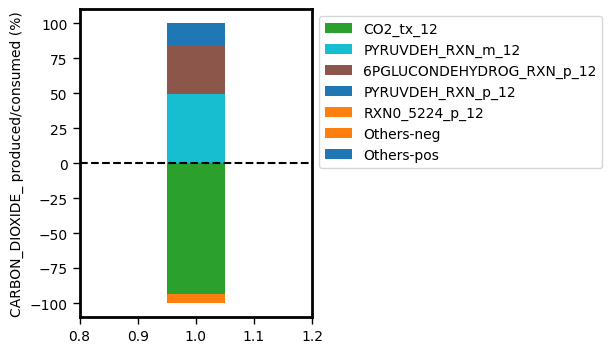

In [ ]:
# turn off cytosolic PEPC
# + turn off plastidic PEPC
# + turn off cytosolic ICDH
# + turn off peroxisomal ICDH
# + turn off mitochondrial ICDH
# + turn off mitochondrial Methylcrotonyl CoA carboxylase

model.reactions.METHYLCROTONYL_COA_CARBOXYLASE_RXN_m_12.bounds = (0, 0)


solution_model, model_opt = optimise_model(model, output_string+"_total", pFBA=True)

print("objective flux: ", model_opt.reactions.AraCore_Biomass_tx_total.flux)

calculate_noct_CO2_refixation_coefficient(model_opt, verbose=True, threshold = 0.00001, show_noflux = False)

generateMetaboliteBudget(model_opt, solution_model, show_plot=True, percentage=True, day_or_night_tag="_12", 
                         metabolite="CARBON_DIOXIDE_", threshold=0.05, colourDict=colourDict_CO2)

Total: 0.08482811249473415


({'Others-pos': 0,
  'Others-neg': 0.0,
  'ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12': -100.00000000000001,
  'RXN0_5224_p_12': 100.00000000000001},
                                       value
 Others-pos                              0.0
 Others-neg                              0.0
 ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12 -100.0
 RXN0_5224_p_12                        100.0)

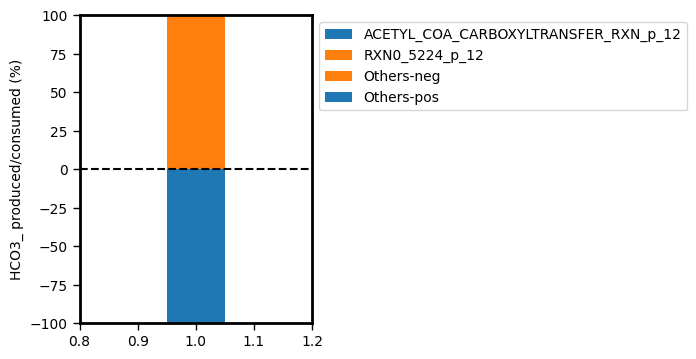

In [ ]:
generateMetaboliteBudget(model_opt, solution_model, show_plot=True, percentage=True, day_or_night_tag="_12", 
                         metabolite="HCO3_", threshold=0.05, colourDict=colourDict_CO2)

Main noct. CO2-fixing enzyme is:
- CO2_tx (93.096%)
- p CA (6.59%)

HCO3-fixing enzymes (0.084828)
- Acetyl CoA carboxyltransferase p (100%)

objective flux:  0.06285814276825805

In [ ]:
# reference model, CAM allowed
solution_CAM_cyc, CAM_cyc_model_opt = optimise_model(CAM_cyc_model, output_string+"_total", pFBA=True)
calculate_noct_CO2_refixation_coefficient(CAM_cyc_model_opt, verbose=True, threshold = 0.00001, show_noflux = False)

# constraining PEPC_c flux to 0
CO2_limit_model1 = CAM_cyc_model.copy()
CO2_limit_model1.reactions.get_by_id("PEPCARBOX_RXN_c"+night_tag).bounds = (0,0)
solution_CO2_limit1, CO2_limit_model1_opt = optimise_model(CO2_limit_model1, output_string+"_total", pFBA=True)
calculate_noct_CO2_refixation_coefficient(CO2_limit_model1_opt, verbose=True, threshold = 0.00001, show_noflux = False)

df_D1, sol_D1 = parameter_scan_CO2(CO2_limit_model1_opt, output_string+"_total", "CO2_tx"+day_tag, 0, 17, 0.5, pFBA=True, 
                    CO2_refixation_allowed=True, verbose=True, iterations=50)

# also constraining PEPC_p flux to 0
CO2_limit_model2 = CO2_limit_model1.copy()
CO2_limit_model2.reactions.get_by_id("PEPCARBOX_RXN_p"+night_tag).bounds = (0,0)
solution_CO2_limit2, CO2_limit_model2_opt = optimise_model(CO2_limit_model2, output_string+"_total", pFBA=True)
calculate_noct_CO2_refixation_coefficient(CO2_limit_model2_opt, verbose=True, threshold = 0.00001, show_noflux = False)

df_E1, sol_E1 = parameter_scan_CO2(CO2_limit_model2_opt, output_string+"_total", "CO2_tx"+day_tag, 0, 17, 0.5, pFBA=True, 
                    CO2_refixation_allowed=True, verbose=True, iterations=50)

# also constraining ICDH_c flux to 0
CO2_limit_model3 = CO2_limit_model2.copy()
CO2_limit_model3.reactions.get_by_id("ISOCITDEH_RXN_c"+night_tag).bounds = (0,0)
solution_CO2_limit3, CO2_limit_model3_opt = optimise_model(CO2_limit_model3, output_string+"_total", pFBA=True)
calculate_noct_CO2_refixation_coefficient(CO2_limit_model3_opt, verbose=True, threshold = 0.00001, show_noflux = False)

df_F1, sol_F1 = parameter_scan_CO2(CO2_limit_model3_opt, output_string+"_total", "CO2_tx"+day_tag, 0, 17, 0.5, pFBA=True, 
                    CO2_refixation_allowed=True, verbose=True, iterations=50)




Objective: AraCore_Biomass_tx_total
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	1.471149
producing HCO3-:	RXN0_5224_c_12	1.471149
producing CO2:	CO2_pc_12	0.394762
consuming CO2:	ISOCITDEH_RXN_c_12	-0.391173
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.021753
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001847
producing CO2:	CO2_mc_12	1.039596
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.401194
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.471149
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.00317
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.004915
producing CO2:	RXN_9652_p_12	0.014781
producing CO2:	RXN_9650_p_12	0.014781
producing CO2:	2.3.1.180_RXN_p_12	0.014781
producing CO2:	RXN_9654_p_12	0.014781
consuming CO2:	RXN0_5224_p_12	0.103465
producing HCO3-:	RXN0_5224_p_12	0.103465
consuming CO2:	CO2_pc_12	0.394762
producing CO2:	1.2.1.2_RXN_p_12	0.002449
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.103465
producing CO2:	PYRUVDEH_RXN_p_12	0.11824

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 2      Scan value: 0.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0057706
----- Cytosol -----
consuming CO2:	CO2_pc_12	-0.99983
consuming CO2:	ISOCITDEH_RXN_c_12	-0.416395
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.001637
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000139
producing CO2:	CO2_mc_12	0.99706
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.417149
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.000239
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.00037
producing CO2:	RXN_9652_p_12	0.001112
producing CO2:	RXN_9650_p_12	0.001112
producing CO2:	2.3.1.180_RXN_p_12	0.001112
producing CO2:	RXN_9654_p_12	0.001112
consuming CO2:	RXN0_5224_p_12	1.230662
producing HCO3-:	RXN0_5224_p_12	1.230662
producing CO2:	CO2_pc_12	-0.99983
producing CO2:	1.2.1.2_RXN_p_12	8.8e-05
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.007787
producing CO2:	PYRUVDEH_RXN_p_12	0.0089
produci

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 3      Scan value: 1.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0115412
----- Cytosol -----
consuming CO2:	CO2_pc_12	-1.006091
consuming CO2:	ISOCITDEH_RXN_c_12	-0.414446
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.003275
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000278
producing CO2:	CO2_mc_12	1.000553
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.415954
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.000477
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.00074
producing CO2:	RXN_9652_p_12	0.002225
producing CO2:	RXN_9650_p_12	0.002225
producing CO2:	2.3.1.180_RXN_p_12	0.002225
producing CO2:	RXN_9654_p_12	0.002225
consuming CO2:	RXN0_5224_p_12	1.258584
producing HCO3-:	RXN0_5224_p_12	1.258584
producing CO2:	CO2_pc_12	-1.006091
producing CO2:	1.2.1.2_RXN_p_12	0.000177
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.015575
producing CO2:	PYRUVDEH_RXN_p_12	0.0178
pro

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 4      Scan value: 1.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0173117
----- Cytosol -----
consuming CO2:	CO2_pc_12	-1.012353
consuming CO2:	ISOCITDEH_RXN_c_12	-0.412497
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.004912
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000417
producing CO2:	CO2_mc_12	1.004045
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.414759
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.000716
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.00111
producing CO2:	RXN_9652_p_12	0.003337
producing CO2:	RXN_9650_p_12	0.003337
producing CO2:	2.3.1.180_RXN_p_12	0.003337
producing CO2:	RXN_9654_p_12	0.003337
consuming CO2:	RXN0_5224_p_12	1.286506
producing HCO3-:	RXN0_5224_p_12	1.286506
producing CO2:	CO2_pc_12	-1.012353
producing CO2:	1.2.1.2_RXN_p_12	0.000265
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.023362
producing CO2:	PYRUVDEH_RXN_p_12	0.0267
pro

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 5      Scan value: 2.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0230823
----- Cytosol -----
consuming CO2:	CO2_pc_12	-1.018614
consuming CO2:	ISOCITDEH_RXN_c_12	-0.410547
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.006549
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000556
producing CO2:	CO2_mc_12	1.007537
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.413564
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.000954
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.00148
producing CO2:	RXN_9652_p_12	0.00445
producing CO2:	RXN_9650_p_12	0.00445
producing CO2:	2.3.1.180_RXN_p_12	0.00445
producing CO2:	RXN_9654_p_12	0.00445
consuming CO2:	RXN0_5224_p_12	1.314428
producing HCO3-:	RXN0_5224_p_12	1.314428
producing CO2:	CO2_pc_12	-1.018614
producing CO2:	1.2.1.2_RXN_p_12	0.000354
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.03115
producing CO2:	PYRUVDEH_RXN_p_12	0.0356
producin

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 6      Scan value: 2.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0288529
----- Cytosol -----
consuming CO2:	CO2_pc_12	-1.024876
consuming CO2:	ISOCITDEH_RXN_c_12	-0.408598
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.008187
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000695
producing CO2:	CO2_mc_12	1.01103
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.412369
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.001193
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.00185
producing CO2:	RXN_9652_p_12	0.005562
producing CO2:	RXN_9650_p_12	0.005562
producing CO2:	2.3.1.180_RXN_p_12	0.005562
producing CO2:	RXN_9654_p_12	0.005562
consuming CO2:	RXN0_5224_p_12	1.34235
producing HCO3-:	RXN0_5224_p_12	1.34235
producing CO2:	CO2_pc_12	-1.024876
producing CO2:	1.2.1.2_RXN_p_12	0.000442
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.038937
producing CO2:	PYRUVDEH_RXN_p_12	0.0445
produc

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 7      Scan value: 3.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0346235
----- Cytosol -----
consuming CO2:	CO2_pc_12	-1.031137
consuming CO2:	ISOCITDEH_RXN_c_12	-0.406649
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.009824
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000834
producing CO2:	CO2_mc_12	1.014522
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.411174
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.001432
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.00222
producing CO2:	RXN_9652_p_12	0.006675
producing CO2:	RXN_9650_p_12	0.006675
producing CO2:	2.3.1.180_RXN_p_12	0.006675
producing CO2:	RXN_9654_p_12	0.006675
consuming CO2:	RXN0_5224_p_12	1.370272
producing HCO3-:	RXN0_5224_p_12	1.370272
producing CO2:	CO2_pc_12	-1.031137
producing CO2:	1.2.1.2_RXN_p_12	0.000531
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.046725
producing CO2:	PYRUVDEH_RXN_p_12	0.0534
pro

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 8      Scan value: 3.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0403941
----- Cytosol -----
consuming CO2:	CO2_pc_12	-1.037399
consuming CO2:	ISOCITDEH_RXN_c_12	-0.4047
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.011461
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000973
producing CO2:	CO2_mc_12	1.018014
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.409979
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.00167
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.00259
producing CO2:	RXN_9652_p_12	0.007787
producing CO2:	RXN_9650_p_12	0.007787
producing CO2:	2.3.1.180_RXN_p_12	0.007787
producing CO2:	RXN_9654_p_12	0.007787
consuming CO2:	RXN0_5224_p_12	1.398194
producing HCO3-:	RXN0_5224_p_12	1.398194
producing CO2:	CO2_pc_12	-1.037399
producing CO2:	1.2.1.2_RXN_p_12	0.000619
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.054512
producing CO2:	PYRUVDEH_RXN_p_12	0.0623
produc

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 9      Scan value: 4.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0461646
----- Cytosol -----
consuming CO2:	CO2_pc_12	-1.04366
consuming CO2:	ISOCITDEH_RXN_c_12	-0.402751
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.013099
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001112
producing CO2:	CO2_mc_12	1.021507
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.408785
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.001909
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.00296
producing CO2:	RXN_9652_p_12	0.0089
producing CO2:	RXN_9650_p_12	0.0089
producing CO2:	2.3.1.180_RXN_p_12	0.0089
producing CO2:	RXN_9654_p_12	0.0089
consuming CO2:	RXN0_5224_p_12	1.426116
producing HCO3-:	RXN0_5224_p_12	1.426116
producing CO2:	CO2_pc_12	-1.04366
producing CO2:	1.2.1.2_RXN_p_12	0.000708
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.0623
producing CO2:	PYRUVDEH_RXN_p_12	0.0712
producing CO2:	

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 10      Scan value: 4.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0519352
----- Cytosol -----
consuming CO2:	CO2_pc_12	-1.049922
consuming CO2:	ISOCITDEH_RXN_c_12	-0.400801
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.014736
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001251
producing CO2:	CO2_mc_12	1.024999
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.40759
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.002148
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.00333
producing CO2:	RXN_9652_p_12	0.010012
producing CO2:	RXN_9650_p_12	0.010012
producing CO2:	2.3.1.180_RXN_p_12	0.010012
producing CO2:	RXN_9654_p_12	0.010012
consuming CO2:	RXN0_5224_p_12	1.454038
producing HCO3-:	RXN0_5224_p_12	1.454038
producing CO2:	CO2_pc_12	-1.049922
producing CO2:	1.2.1.2_RXN_p_12	0.000796
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.070087
producing CO2:	PYRUVDEH_RXN_p_12	0.0801
pro

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 11      Scan value: 5.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0577058
----- Cytosol -----
consuming CO2:	CO2_pc_12	-1.056183
consuming CO2:	ISOCITDEH_RXN_c_12	-0.398852
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.016373
producing CO2:	GLUTDECARBOX_RXN_c_12	0.00139
producing CO2:	CO2_mc_12	1.028491
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.406395
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.002386
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.0037
producing CO2:	RXN_9652_p_12	0.011125
producing CO2:	RXN_9650_p_12	0.011125
producing CO2:	2.3.1.180_RXN_p_12	0.011125
producing CO2:	RXN_9654_p_12	0.011125
consuming CO2:	RXN0_5224_p_12	1.48196
producing HCO3-:	RXN0_5224_p_12	1.48196
producing CO2:	CO2_pc_12	-1.056183
producing CO2:	1.2.1.2_RXN_p_12	0.000885
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.077875
producing CO2:	PYRUVDEH_RXN_p_12	0.089
produci

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 12      Scan value: 5.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0634764
----- Cytosol -----
consuming CO2:	CO2_pc_12	-1.062445
consuming CO2:	ISOCITDEH_RXN_c_12	-0.396903
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.01801
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001529
producing CO2:	CO2_mc_12	1.031984
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.4052
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.002625
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.00407
producing CO2:	RXN_9652_p_12	0.012237
producing CO2:	RXN_9650_p_12	0.012237
producing CO2:	2.3.1.180_RXN_p_12	0.012237
producing CO2:	RXN_9654_p_12	0.012237
consuming CO2:	RXN0_5224_p_12	1.509881
producing HCO3-:	RXN0_5224_p_12	1.509881
producing CO2:	CO2_pc_12	-1.062445
producing CO2:	1.2.1.2_RXN_p_12	0.000973
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.085662
producing CO2:	PYRUVDEH_RXN_p_12	0.0979
produ

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 13      Scan value: 6.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.069247
----- Cytosol -----
consuming CO2:	CO2_pc_12	-1.068706
consuming CO2:	ISOCITDEH_RXN_c_12	-0.394954
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.019648
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001668
producing CO2:	CO2_mc_12	1.035476
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.404005
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.002863
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.004439
producing CO2:	RXN_9652_p_12	0.01335
producing CO2:	RXN_9650_p_12	0.01335
producing CO2:	2.3.1.180_RXN_p_12	0.01335
producing CO2:	RXN_9654_p_12	0.01335
consuming CO2:	RXN0_5224_p_12	1.537803
producing HCO3-:	RXN0_5224_p_12	1.537803
producing CO2:	CO2_pc_12	-1.068706
producing CO2:	1.2.1.2_RXN_p_12	0.001062
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.09345
producing CO2:	PYRUVDEH_RXN_p_12	0.1068
produci

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 14      Scan value: 6.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0750175
----- Cytosol -----
consuming CO2:	CO2_pc_12	-1.074968
consuming CO2:	ISOCITDEH_RXN_c_12	-0.393004
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.021285
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001807
producing CO2:	CO2_mc_12	1.038968
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.40281
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.003102
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.004809
producing CO2:	RXN_9652_p_12	0.014462
producing CO2:	RXN_9650_p_12	0.014462
producing CO2:	2.3.1.180_RXN_p_12	0.014462
producing CO2:	RXN_9654_p_12	0.014462
consuming CO2:	RXN0_5224_p_12	1.565725
producing HCO3-:	RXN0_5224_p_12	1.565725
producing CO2:	CO2_pc_12	-1.074968
producing CO2:	1.2.1.2_RXN_p_12	0.00115
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.101237
producing CO2:	PYRUVDEH_RXN_p_12	0.1157
pro

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 15      Scan value: 7.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0807881
----- Cytosol -----
consuming CO2:	CO2_pc_12	-1.081229
consuming CO2:	ISOCITDEH_RXN_c_12	-0.391055
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.022922
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001946
producing CO2:	CO2_mc_12	1.042461
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.401615
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.003341
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.005179
producing CO2:	RXN_9652_p_12	0.015575
producing CO2:	RXN_9650_p_12	0.015575
producing CO2:	2.3.1.180_RXN_p_12	0.015575
producing CO2:	RXN_9654_p_12	0.015575
consuming CO2:	RXN0_5224_p_12	1.593647
producing HCO3-:	RXN0_5224_p_12	1.593647
producing CO2:	CO2_pc_12	-1.081229
producing CO2:	1.2.1.2_RXN_p_12	0.001239
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.109025
producing CO2:	PYRUVDEH_RXN_p_12	0.1246
p

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 16      Scan value: 7.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0865587
----- Cytosol -----
consuming CO2:	CO2_pc_12	-1.087491
consuming CO2:	ISOCITDEH_RXN_c_12	-0.389106
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.02456
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002085
producing CO2:	CO2_mc_12	1.045953
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.40042
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.003579
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.005549
producing CO2:	RXN_9652_p_12	0.016687
producing CO2:	RXN_9650_p_12	0.016687
producing CO2:	2.3.1.180_RXN_p_12	0.016687
producing CO2:	RXN_9654_p_12	0.016687
consuming CO2:	RXN0_5224_p_12	1.621569
producing HCO3-:	RXN0_5224_p_12	1.621569
producing CO2:	CO2_pc_12	-1.087491
producing CO2:	1.2.1.2_RXN_p_12	0.001327
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.116812
producing CO2:	PYRUVDEH_RXN_p_12	0.1335
pro

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 17      Scan value: 8.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0923293
----- Cytosol -----
consuming CO2:	CO2_pc_12	-1.099325
consuming CO2:	ISOCITDEH_RXN_c_12	-0.387157
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.026197
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002224
producing CO2:	CO2_mc_12	1.056927
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.401134
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.005919
producing CO2:	RXN_9652_p_12	0.0178
producing CO2:	RXN_9650_p_12	0.0178
producing CO2:	2.3.1.180_RXN_p_12	0.0178
producing CO2:	RXN_9654_p_12	0.0178
consuming CO2:	RXN0_5224_p_12	1.647277
producing HCO3-:	RXN0_5224_p_12	1.647277
producing CO2:	CO2_pc_12	-1.099325
producing CO2:	1.2.1.2_RXN_p_12	0.001416
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.1246
producing CO2:	PYRUVDEH_RXN_p_12	0.1424
producing CO2:	RXN_9653_p_12	0.0178
producing CO2:	RXN_9651_p_12	0.0178
con

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 18      Scan value: 8.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0980999
----- Cytosol -----
consuming CO2:	CO2_pc_12	-1.109701
consuming CO2:	ISOCITDEH_RXN_c_12	-0.385207
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.027834
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002363
producing CO2:	CO2_mc_12	1.064653
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.400058
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.006289
producing CO2:	RXN_9652_p_12	0.018912
producing CO2:	RXN_9650_p_12	0.018912
producing CO2:	2.3.1.180_RXN_p_12	0.018912
producing CO2:	RXN_9654_p_12	0.018912
consuming CO2:	RXN0_5224_p_12	1.673592
producing HCO3-:	RXN0_5224_p_12	1.673592
producing CO2:	CO2_pc_12	-1.109701
producing CO2:	1.2.1.2_RXN_p_12	0.001504
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.132387
producing CO2:	PYRUVDEH_RXN_p_12	0.1513
producing CO2:	RXN_9653_p_12	0.018912
producing CO2:	RXN_9651_p_1

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 19      Scan value: 9.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1038704
----- Cytosol -----
consuming CO2:	CO2_pc_12	-1.116532
consuming CO2:	ISOCITDEH_RXN_c_12	-0.383258
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.029472
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002502
producing CO2:	CO2_mc_12	1.068834
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.398982
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.006659
producing CO2:	RXN_9652_p_12	0.020025
producing CO2:	RXN_9650_p_12	0.020025
producing CO2:	2.3.1.180_RXN_p_12	0.020025
producing CO2:	RXN_9654_p_12	0.020025
consuming CO2:	RXN0_5224_p_12	1.70129
producing HCO3-:	RXN0_5224_p_12	1.70129
producing CO2:	CO2_pc_12	-1.116532
producing CO2:	1.2.1.2_RXN_p_12	0.001593
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.140175
producing CO2:	PYRUVDEH_RXN_p_12	0.1602
producing CO2:	RXN_9653_p_12	0.020025
producing CO2:	RXN_9651_p_12	

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 20      Scan value: 9.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.109641
----- Cytosol -----
consuming CO2:	CO2_pc_12	-1.123363
consuming CO2:	ISOCITDEH_RXN_c_12	-0.381309
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.031109
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002641
producing CO2:	CO2_mc_12	1.073016
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.397906
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.007029
producing CO2:	RXN_9652_p_12	0.021137
producing CO2:	RXN_9650_p_12	0.021137
producing CO2:	2.3.1.180_RXN_p_12	0.021137
producing CO2:	RXN_9654_p_12	0.021137
consuming CO2:	RXN0_5224_p_12	1.728987
producing HCO3-:	RXN0_5224_p_12	1.728987
producing CO2:	CO2_pc_12	-1.123363
producing CO2:	1.2.1.2_RXN_p_12	0.001681
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.147962
producing CO2:	PYRUVDEH_RXN_p_12	0.1691
producing CO2:	RXN_9653_p_12	0.021137
producing CO2:	RXN_9651_p_12

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 21      Scan value: 10.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1154116
----- Cytosol -----
consuming CO2:	CO2_pc_12	-1.130195
consuming CO2:	ISOCITDEH_RXN_c_12	-0.37936
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.032746
producing CO2:	GLUTDECARBOX_RXN_c_12	0.00278
producing CO2:	CO2_mc_12	1.077197
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.396831
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.007399
producing CO2:	RXN_9652_p_12	0.02225
producing CO2:	RXN_9650_p_12	0.02225
producing CO2:	2.3.1.180_RXN_p_12	0.02225
producing CO2:	RXN_9654_p_12	0.02225
consuming CO2:	RXN0_5224_p_12	1.756684
producing HCO3-:	RXN0_5224_p_12	1.756684
producing CO2:	CO2_pc_12	-1.130195
producing CO2:	1.2.1.2_RXN_p_12	0.00177
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.15575
producing CO2:	PYRUVDEH_RXN_p_12	0.178
producing CO2:	RXN_9653_p_12	0.02225
producing CO2:	RXN_9651_p_12	0.02225

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 22      Scan value: 10.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1211822
----- Cytosol -----
consuming CO2:	CO2_pc_12	-1.137026
consuming CO2:	ISOCITDEH_RXN_c_12	-0.37741
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.034384
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002919
producing CO2:	CO2_mc_12	1.081378
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.395755
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.007769
producing CO2:	RXN_9652_p_12	0.023362
producing CO2:	RXN_9650_p_12	0.023362
producing CO2:	2.3.1.180_RXN_p_12	0.023362
producing CO2:	RXN_9654_p_12	0.023362
consuming CO2:	RXN0_5224_p_12	1.784381
producing HCO3-:	RXN0_5224_p_12	1.784381
producing CO2:	CO2_pc_12	-1.137026
producing CO2:	1.2.1.2_RXN_p_12	0.001858
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.163537
producing CO2:	PYRUVDEH_RXN_p_12	0.1869
producing CO2:	RXN_9653_p_12	0.023362
producing CO2:	RXN_9651_p_1

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 23      Scan value: 11.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1243438
----- Cytosol -----
consuming CO2:	CO2_pc_12	-0.840905
consuming CO2:	ISOCITDEH_RXN_c_12	-0.368611
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.035281
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002995
producing CO2:	CO2_mc_12	1.003421
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.388729
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005142
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.007972
producing CO2:	RXN_9652_p_12	0.023972
producing CO2:	RXN_9650_p_12	0.023972
producing CO2:	2.3.1.180_RXN_p_12	0.023972
producing CO2:	RXN_9654_p_12	0.023972
consuming CO2:	RXN0_5224_p_12	1.559782
producing HCO3-:	RXN0_5224_p_12	1.559782
producing CO2:	CO2_pc_12	-0.840905
producing CO2:	1.2.1.2_RXN_p_12	0.001907
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.167804
producing CO2:	PYRUVDEH_RXN_p_12	0.20294

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 24      Scan value: 11.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1260098
----- Cytosol -----
consuming CO2:	CO2_pc_12	-0.423695
consuming CO2:	ISOCITDEH_RXN_c_12	-0.37578
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.035753
producing CO2:	GLUTDECARBOX_RXN_c_12	0.003036
producing CO2:	CO2_mc_12	0.944928
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.39225
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005211
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.024293
producing CO2:	RXN_9650_p_12	0.024293
producing CO2:	2.3.1.180_RXN_p_12	0.024293
producing CO2:	RXN_9654_p_12	0.024293
consuming CO2:	RXN0_5224_p_12	1.133366
producing HCO3-:	RXN0_5224_p_12	1.133366
producing CO2:	CO2_pc_12	-0.423695
producing CO2:	1.2.1.2_RXN_p_12	0.001932
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.170052
producing CO2:	PYRUVDEH_RXN_p_12	0.205668
producing CO2:	RXN_9653_p_12	0.024293
producing CO

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 25      Scan value: 12.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1274938
----- Cytosol -----
producing CO2:	CO2_pc_12	0.015937
consuming CO2:	ISOCITDEH_RXN_c_12	-0.375278
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036175
producing CO2:	GLUTDECARBOX_RXN_c_12	0.003071
producing CO2:	CO2_mc_12	0.875999
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.391943
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005272
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.024579
producing CO2:	RXN_9650_p_12	0.024579
producing CO2:	2.3.1.180_RXN_p_12	0.024579
producing CO2:	RXN_9654_p_12	0.024579
consuming CO2:	RXN0_5224_p_12	0.699629
producing HCO3-:	RXN0_5224_p_12	0.699629
consuming CO2:	CO2_pc_12	0.015937
producing CO2:	1.2.1.2_RXN_p_12	0.001955
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.172055
producing CO2:	PYRUVDEH_RXN_p_12	0.20809
producing CO2:	RXN_9653_p_12	0.024579
producing CO2

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 26      Scan value: 12.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
producing CO2:	CO2_pc_12	0.272271
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.452612
producing HCO3-:	RXN0_5224_p_12	0.452612
consuming CO2:	CO2_pc_12	0.272271
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	PYRUVDEH_RXN_p_12	0.209448
producing CO2:	RXN_9653_p_12	0.02474
producing CO2:	RXN_7800_p_12	0.01153
producing CO2:	RXN_9651_p

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 27      Scan value: 13.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration is infeasible!
------- Scan iteration: 28      Scan value: 13.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
producing CO2:	CO2_pc_12	0.272271
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.452612
producing HCO3-:	RXN0_5224_p_12	0.452612
consuming CO2:	CO2_pc_12	0.272271
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
prod

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 29      Scan value: 14.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
producing CO2:	CO2_pc_12	0.272271
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.452612
producing HCO3-:	RXN0_5224_p_12	0.452612
consuming CO2:	CO2_pc_12	0.272271
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	PYRUVDEH_RXN_p_12	0.209448
producing CO2:	RXN_9653_p_12	0.02474
producing CO2:	RXN_7800_p_12	0.01153
producing CO2:	RXN_9651_p

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 30      Scan value: 14.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
producing CO2:	CO2_pc_12	0.272271
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.452612
producing HCO3-:	RXN0_5224_p_12	0.452612
consuming CO2:	CO2_pc_12	0.272271
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	PYRUVDEH_RXN_p_12	0.209448
producing CO2:	RXN_9653_p_12	0.02474
producing CO2:	RXN_7800_p_12	0.01153
producing CO2:	RXN_9651_p

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 31      Scan value: 15.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
producing CO2:	CO2_pc_12	0.272271
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.452612
producing HCO3-:	RXN0_5224_p_12	0.452612
consuming CO2:	CO2_pc_12	0.272271
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	PYRUVDEH_RXN_p_12	0.209448
producing CO2:	RXN_9653_p_12	0.02474
producing CO2:	RXN_7800_p_12	0.01153
producing CO2:	RXN_9651_p

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 32      Scan value: 15.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
producing CO2:	CO2_pc_12	0.272271
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.452612
producing HCO3-:	RXN0_5224_p_12	0.452612
consuming CO2:	CO2_pc_12	0.272271
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	PYRUVDEH_RXN_p_12	0.209448
producing CO2:	RXN_9653_p_12	0.02474
producing CO2:	RXN_7800_p_12	0.01153
producing CO2:	RXN_9651_p

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 33      Scan value: 16.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
producing CO2:	CO2_pc_12	0.272271
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.452612
producing HCO3-:	RXN0_5224_p_12	0.452612
consuming CO2:	CO2_pc_12	0.272271
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	PYRUVDEH_RXN_p_12	0.209448
producing CO2:	RXN_9653_p_12	0.02474
producing CO2:	RXN_7800_p_12	0.01153
producing CO2:	RXN_9651_p

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 34      Scan value: 16.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
producing CO2:	CO2_pc_12	0.272271
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.452612
producing HCO3-:	RXN0_5224_p_12	0.452612
consuming CO2:	CO2_pc_12	0.272271
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	PYRUVDEH_RXN_p_12	0.209448
producing CO2:	RXN_9653_p_12	0.02474
producing CO2:	RXN_7800_p_12	0.01153
producing CO2:	RXN_9651_p

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


Objective: AraCore_Biomass_tx_total
----- Cytosol -----
producing CO2:	CO2_pc_12	0.365231
consuming CO2:	ISOCITDEH_RXN_c_12	-0.398241
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.018183
producing CO2:	CO2_mc_12	1.105213
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.004108
producing CO2:	RXN_9652_p_12	0.012355
producing CO2:	RXN_9650_p_12	0.012355
producing CO2:	RXN_5682_p_12	0.00265
producing CO2:	2.3.1.180_RXN_p_12	0.012355
producing CO2:	RXN_9654_p_12	0.012355
consuming CO2:	RXN0_5224_p_12	0.086482
producing HCO3-:	RXN0_5224_p_12	0.086482
consuming CO2:	CO2_pc_12	0.365231
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.086482
producing CO2:	PYRUVDEH_RXN_p_12	0.098836
producing CO2:	RXN_9653_p_12	0.012355
producing CO2:	RXN_9651_p_12	0.012355
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.003985
producing CO2:	RXN_9648_p_12	0.012355
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.258622
producing CO2:	ACETOLACTSYN_RXN_p_12	0.004999
----- Mitochondrion -----


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 4      Scan value: 1.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0059856
----- Cytosol -----
producing CO2:	CO2_pc_12	0.22394
consuming CO2:	ISOCITDEH_RXN_c_12	-0.416467
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.001698
producing CO2:	CO2_mc_12	1.172199
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.000384
producing CO2:	RXN_9652_p_12	0.001154
producing CO2:	RXN_9650_p_12	0.001154
producing CO2:	RXN_5682_p_12	0.000248
producing CO2:	2.3.1.180_RXN_p_12	0.001154
producing CO2:	RXN_9654_p_12	0.001154
consuming CO2:	RXN0_5224_p_12	0.008078
producing HCO3-:	RXN0_5224_p_12	0.008078
consuming CO2:	CO2_pc_12	0.22394
producing CO2:	1.2.1.2_RXN_p_12	0.000191
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.008078
producing CO2:	PYRUVDEH_RXN_p_12	0.009232
producing CO2:	RXN_9653_p_12	0.001154
producing CO2:	RXN_9651_p_12	0.001154
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.000372


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 5      Scan value: 2.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0116338
----- Cytosol -----
producing CO2:	CO2_pc_12	0.237875
consuming CO2:	ISOCITDEH_RXN_c_12	-0.414695
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.003301
producing CO2:	CO2_mc_12	1.165488
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.000746
producing CO2:	RXN_9652_p_12	0.002243
producing CO2:	RXN_9650_p_12	0.002243
producing CO2:	RXN_5682_p_12	0.000481
producing CO2:	2.3.1.180_RXN_p_12	0.002243
producing CO2:	RXN_9654_p_12	0.002243
consuming CO2:	RXN0_5224_p_12	0.0157
producing HCO3-:	RXN0_5224_p_12	0.0157
consuming CO2:	CO2_pc_12	0.237875
producing CO2:	1.2.1.2_RXN_p_12	0.000372
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.0157
producing CO2:	PYRUVDEH_RXN_p_12	0.017943
producing CO2:	RXN_9653_p_12	0.002243
producing CO2:	RXN_9651_p_12	0.002243
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.000723
prod

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 6      Scan value: 2.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0172821
----- Cytosol -----
producing CO2:	CO2_pc_12	0.25181
consuming CO2:	ISOCITDEH_RXN_c_12	-0.412923
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.004904
producing CO2:	CO2_mc_12	1.158776
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.001108
producing CO2:	RXN_9652_p_12	0.003332
producing CO2:	RXN_9650_p_12	0.003332
producing CO2:	RXN_5682_p_12	0.000715
producing CO2:	2.3.1.180_RXN_p_12	0.003332
producing CO2:	RXN_9654_p_12	0.003332
consuming CO2:	RXN0_5224_p_12	0.023322
producing HCO3-:	RXN0_5224_p_12	0.023322
consuming CO2:	CO2_pc_12	0.25181
producing CO2:	1.2.1.2_RXN_p_12	0.000552
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.023322
producing CO2:	PYRUVDEH_RXN_p_12	0.026654
producing CO2:	RXN_9653_p_12	0.003332
producing CO2:	RXN_9651_p_12	0.003332
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.001075


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 7      Scan value: 3.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0229304
----- Cytosol -----
producing CO2:	CO2_pc_12	0.265013
consuming CO2:	ISOCITDEH_RXN_c_12	-0.411151
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.006506
producing CO2:	CO2_mc_12	1.152798
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.00147
producing CO2:	RXN_9652_p_12	0.004421
producing CO2:	RXN_9650_p_12	0.004421
producing CO2:	RXN_5682_p_12	0.000948
producing CO2:	2.3.1.180_RXN_p_12	0.004421
producing CO2:	RXN_9654_p_12	0.004421
consuming CO2:	RXN0_5224_p_12	0.030945
producing HCO3-:	RXN0_5224_p_12	0.030945
consuming CO2:	CO2_pc_12	0.265013
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.030945
producing CO2:	PYRUVDEH_RXN_p_12	0.035366
producing CO2:	RXN_9653_p_12	0.004421
producing CO2:	RXN_9651_p_12	0.004421
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.001426
producing CO2:	RXN_9648_p_12	0.004421
pr

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 8      Scan value: 3.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0285786
----- Cytosol -----
producing CO2:	CO2_pc_12	0.278768
consuming CO2:	ISOCITDEH_RXN_c_12	-0.409379
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.008109
producing CO2:	CO2_mc_12	1.146267
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.001832
producing CO2:	RXN_9652_p_12	0.00551
producing CO2:	RXN_9650_p_12	0.00551
producing CO2:	RXN_5682_p_12	0.001182
producing CO2:	2.3.1.180_RXN_p_12	0.00551
producing CO2:	RXN_9654_p_12	0.00551
consuming CO2:	RXN0_5224_p_12	0.038567
producing HCO3-:	RXN0_5224_p_12	0.038567
consuming CO2:	CO2_pc_12	0.278768
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.038567
producing CO2:	PYRUVDEH_RXN_p_12	0.044077
producing CO2:	RXN_9653_p_12	0.00551
producing CO2:	RXN_9651_p_12	0.00551
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.001777
producing CO2:	RXN_9648_p_12	0.00551
producin

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 9      Scan value: 4.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0342269
----- Cytosol -----
producing CO2:	CO2_pc_12	0.292523
consuming CO2:	ISOCITDEH_RXN_c_12	-0.407607
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.009711
producing CO2:	CO2_mc_12	1.139736
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.002194
producing CO2:	RXN_9652_p_12	0.006599
producing CO2:	RXN_9650_p_12	0.006599
producing CO2:	RXN_5682_p_12	0.001415
producing CO2:	2.3.1.180_RXN_p_12	0.006599
producing CO2:	RXN_9654_p_12	0.006599
consuming CO2:	RXN0_5224_p_12	0.04619
producing HCO3-:	RXN0_5224_p_12	0.04619
consuming CO2:	CO2_pc_12	0.292523
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.04619
producing CO2:	PYRUVDEH_RXN_p_12	0.052788
producing CO2:	RXN_9653_p_12	0.006599
producing CO2:	RXN_9651_p_12	0.006599
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.002128
producing CO2:	RXN_9648_p_12	0.006599
prod

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 10      Scan value: 4.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0398752
----- Cytosol -----
producing CO2:	CO2_pc_12	0.306278
consuming CO2:	ISOCITDEH_RXN_c_12	-0.405836
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.011314
producing CO2:	CO2_mc_12	1.133205
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.002556
producing CO2:	RXN_9652_p_12	0.007687
producing CO2:	RXN_9650_p_12	0.007687
producing CO2:	RXN_5682_p_12	0.001649
producing CO2:	2.3.1.180_RXN_p_12	0.007687
producing CO2:	RXN_9654_p_12	0.007687
consuming CO2:	RXN0_5224_p_12	0.053812
producing HCO3-:	RXN0_5224_p_12	0.053812
consuming CO2:	CO2_pc_12	0.306278
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.053812
producing CO2:	PYRUVDEH_RXN_p_12	0.0615
producing CO2:	RXN_9653_p_12	0.007687
producing CO2:	RXN_9651_p_12	0.007687
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.002479
producing CO2:	RXN_9648_p_12	0.007687
pr

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 11      Scan value: 5.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0455234
----- Cytosol -----
producing CO2:	CO2_pc_12	0.320033
consuming CO2:	ISOCITDEH_RXN_c_12	-0.404064
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.012917
producing CO2:	CO2_mc_12	1.126674
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.002919
producing CO2:	RXN_9652_p_12	0.008776
producing CO2:	RXN_9650_p_12	0.008776
producing CO2:	RXN_5682_p_12	0.001882
producing CO2:	2.3.1.180_RXN_p_12	0.008776
producing CO2:	RXN_9654_p_12	0.008776
consuming CO2:	RXN0_5224_p_12	0.061435
producing HCO3-:	RXN0_5224_p_12	0.061435
consuming CO2:	CO2_pc_12	0.320033
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.061435
producing CO2:	PYRUVDEH_RXN_p_12	0.070211
producing CO2:	RXN_9653_p_12	0.008776
producing CO2:	RXN_9651_p_12	0.008776
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.002831
producing CO2:	RXN_9648_p_12	0.008776


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 12      Scan value: 5.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0511717
----- Cytosol -----
producing CO2:	CO2_pc_12	0.333787
consuming CO2:	ISOCITDEH_RXN_c_12	-0.402292
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.014519
producing CO2:	CO2_mc_12	1.120143
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.003281
producing CO2:	RXN_9652_p_12	0.009865
producing CO2:	RXN_9650_p_12	0.009865
producing CO2:	RXN_5682_p_12	0.002116
producing CO2:	2.3.1.180_RXN_p_12	0.009865
producing CO2:	RXN_9654_p_12	0.009865
consuming CO2:	RXN0_5224_p_12	0.069057
producing HCO3-:	RXN0_5224_p_12	0.069057
consuming CO2:	CO2_pc_12	0.333787
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.069057
producing CO2:	PYRUVDEH_RXN_p_12	0.078922
producing CO2:	RXN_9653_p_12	0.009865
producing CO2:	RXN_9651_p_12	0.009865
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.003182
producing CO2:	RXN_9648_p_12	0.009865


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 13      Scan value: 6.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0568199
----- Cytosol -----
producing CO2:	CO2_pc_12	0.347542
consuming CO2:	ISOCITDEH_RXN_c_12	-0.40052
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.016122
producing CO2:	CO2_mc_12	1.113612
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.003643
producing CO2:	RXN_9652_p_12	0.010954
producing CO2:	RXN_9650_p_12	0.010954
producing CO2:	RXN_5682_p_12	0.00235
producing CO2:	2.3.1.180_RXN_p_12	0.010954
producing CO2:	RXN_9654_p_12	0.010954
consuming CO2:	RXN0_5224_p_12	0.076679
producing HCO3-:	RXN0_5224_p_12	0.076679
consuming CO2:	CO2_pc_12	0.347542
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.076679
producing CO2:	PYRUVDEH_RXN_p_12	0.087634
producing CO2:	RXN_9653_p_12	0.010954
producing CO2:	RXN_9651_p_12	0.010954
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.003533
producing CO2:	RXN_9648_p_12	0.010954
pr

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 14      Scan value: 6.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0624682
----- Cytosol -----
producing CO2:	CO2_pc_12	0.361297
consuming CO2:	ISOCITDEH_RXN_c_12	-0.398748
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.017724
producing CO2:	CO2_mc_12	1.107081
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.004005
producing CO2:	RXN_9652_p_12	0.012043
producing CO2:	RXN_9650_p_12	0.012043
producing CO2:	RXN_5682_p_12	0.002583
producing CO2:	2.3.1.180_RXN_p_12	0.012043
producing CO2:	RXN_9654_p_12	0.012043
consuming CO2:	RXN0_5224_p_12	0.084302
producing HCO3-:	RXN0_5224_p_12	0.084302
consuming CO2:	CO2_pc_12	0.361297
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.084302
producing CO2:	PYRUVDEH_RXN_p_12	0.096345
producing CO2:	RXN_9653_p_12	0.012043
producing CO2:	RXN_9651_p_12	0.012043
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.003884
producing CO2:	RXN_9648_p_12	0.012043


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 15      Scan value: 7.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0681165
----- Cytosol -----
producing CO2:	CO2_pc_12	0.375052
consuming CO2:	ISOCITDEH_RXN_c_12	-0.396976
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.019327
producing CO2:	CO2_mc_12	1.10055
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.004367
producing CO2:	RXN_9652_p_12	0.013132
producing CO2:	RXN_9650_p_12	0.013132
producing CO2:	RXN_5682_p_12	0.002817
producing CO2:	2.3.1.180_RXN_p_12	0.013132
producing CO2:	RXN_9654_p_12	0.013132
consuming CO2:	RXN0_5224_p_12	0.091924
producing HCO3-:	RXN0_5224_p_12	0.091924
consuming CO2:	CO2_pc_12	0.375052
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.091924
producing CO2:	PYRUVDEH_RXN_p_12	0.105056
producing CO2:	RXN_9653_p_12	0.013132
producing CO2:	RXN_9651_p_12	0.013132
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.004235
producing CO2:	RXN_9648_p_12	0.013132
p

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 16      Scan value: 7.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration is infeasible!
------- Scan iteration: 17      Scan value: 8.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.079413
----- Cytosol -----
producing CO2:	CO2_pc_12	0.402562
consuming CO2:	ISOCITDEH_RXN_c_12	-0.393433
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.022532
producing CO2:	CO2_mc_12	1.087488
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.005091
producing CO2:	RXN_9652_p_12	0.01531
producing CO2:	RXN_9650_p_12	0.01531
producing CO2:	RXN_5682_p_12	0.003284
producing CO2:	2.3.1.180_RXN_p_12	0.01531
producing CO2:	RXN_9654_p_12	0.01531
consuming CO2:	RXN0_5224_p_12	0.107169
producing HCO3-:	RXN0_5224_p_12	0.107169
consuming CO2:	CO2_pc_12	0.402562
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.107169
producing CO2:	PYRUVDEH_RXN_p_12	0.122479
producing CO2:	RXN_9653_p_12	0.01

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 18      Scan value: 8.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0850613
----- Cytosol -----
producing CO2:	CO2_pc_12	0.416317
consuming CO2:	ISOCITDEH_RXN_c_12	-0.391661
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.024135
producing CO2:	CO2_mc_12	1.080957
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.005453
producing CO2:	RXN_9652_p_12	0.016399
producing CO2:	RXN_9650_p_12	0.016399
producing CO2:	RXN_5682_p_12	0.003517
producing CO2:	2.3.1.180_RXN_p_12	0.016399
producing CO2:	RXN_9654_p_12	0.016399
consuming CO2:	RXN0_5224_p_12	0.114792
producing HCO3-:	RXN0_5224_p_12	0.114792
consuming CO2:	CO2_pc_12	0.416317
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.114792
producing CO2:	PYRUVDEH_RXN_p_12	0.13119
producing CO2:	RXN_9653_p_12	0.016399
producing CO2:	RXN_9651_p_12	0.016399
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.005289
producing CO2:	RXN_9648_p_12	0.016399
p

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 19      Scan value: 9.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0907095
----- Cytosol -----
producing CO2:	CO2_pc_12	0.430072
consuming CO2:	ISOCITDEH_RXN_c_12	-0.389889
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.025738
producing CO2:	CO2_mc_12	1.074426
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.005815
producing CO2:	RXN_9652_p_12	0.017488
producing CO2:	RXN_9650_p_12	0.017488
producing CO2:	RXN_5682_p_12	0.003751
producing CO2:	2.3.1.180_RXN_p_12	0.017488
producing CO2:	RXN_9654_p_12	0.017488
consuming CO2:	RXN0_5224_p_12	0.122414
producing HCO3-:	RXN0_5224_p_12	0.122414
consuming CO2:	CO2_pc_12	0.430072
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.122414
producing CO2:	PYRUVDEH_RXN_p_12	0.139902
producing CO2:	RXN_9653_p_12	0.017488
producing CO2:	RXN_9651_p_12	0.017488
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.00564
producing CO2:	RXN_9648_p_12	0.017488
p

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 20      Scan value: 9.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0963578
----- Cytosol -----
producing CO2:	CO2_pc_12	0.443826
consuming CO2:	ISOCITDEH_RXN_c_12	-0.388117
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.02734
producing CO2:	CO2_mc_12	1.067895
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.006178
producing CO2:	RXN_9652_p_12	0.018577
producing CO2:	RXN_9650_p_12	0.018577
producing CO2:	RXN_5682_p_12	0.003984
producing CO2:	2.3.1.180_RXN_p_12	0.018577
producing CO2:	RXN_9654_p_12	0.018577
consuming CO2:	RXN0_5224_p_12	0.130036
producing HCO3-:	RXN0_5224_p_12	0.130036
consuming CO2:	CO2_pc_12	0.443826
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.130036
producing CO2:	PYRUVDEH_RXN_p_12	0.148613
producing CO2:	RXN_9653_p_12	0.018577
producing CO2:	RXN_9651_p_12	0.018577
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.005991
producing CO2:	RXN_9648_p_12	0.018577
p

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 21      Scan value: 10.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.102006
----- Cytosol -----
producing CO2:	CO2_pc_12	0.457581
consuming CO2:	ISOCITDEH_RXN_c_12	-0.386345
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.028943
producing CO2:	CO2_mc_12	1.061364
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.00654
producing CO2:	RXN_9652_p_12	0.019666
producing CO2:	RXN_9650_p_12	0.019666
producing CO2:	RXN_5682_p_12	0.004218
producing CO2:	2.3.1.180_RXN_p_12	0.019666
producing CO2:	RXN_9654_p_12	0.019666
consuming CO2:	RXN0_5224_p_12	0.137659
producing HCO3-:	RXN0_5224_p_12	0.137659
consuming CO2:	CO2_pc_12	0.457581
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.137659
producing CO2:	PYRUVDEH_RXN_p_12	0.157324
producing CO2:	RXN_9653_p_12	0.019666
producing CO2:	RXN_9651_p_12	0.019666
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.006342
producing CO2:	RXN_9648_p_12	0.019666
p

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 22      Scan value: 10.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1076543
----- Cytosol -----
producing CO2:	CO2_pc_12	0.471336
consuming CO2:	ISOCITDEH_RXN_c_12	-0.384573
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.030545
producing CO2:	CO2_mc_12	1.054833
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.006902
producing CO2:	RXN_9652_p_12	0.020754
producing CO2:	RXN_9650_p_12	0.020754
producing CO2:	RXN_5682_p_12	0.004452
producing CO2:	2.3.1.180_RXN_p_12	0.020754
producing CO2:	RXN_9654_p_12	0.020754
consuming CO2:	RXN0_5224_p_12	0.145281
producing HCO3-:	RXN0_5224_p_12	0.145281
consuming CO2:	CO2_pc_12	0.471336
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.145281
producing CO2:	PYRUVDEH_RXN_p_12	0.166036
producing CO2:	RXN_9653_p_12	0.020754
producing CO2:	RXN_9651_p_12	0.020754
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.006694
producing CO2:	RXN_9648_p_12	0.020754

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 23      Scan value: 11.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1133026
----- Cytosol -----
producing CO2:	CO2_pc_12	0.485091
consuming CO2:	ISOCITDEH_RXN_c_12	-0.382802
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.032148
producing CO2:	CO2_mc_12	1.048302
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.007264
producing CO2:	RXN_9652_p_12	0.021843
producing CO2:	RXN_9650_p_12	0.021843
producing CO2:	RXN_5682_p_12	0.004685
producing CO2:	2.3.1.180_RXN_p_12	0.021843
producing CO2:	RXN_9654_p_12	0.021843
consuming CO2:	RXN0_5224_p_12	0.152904
producing HCO3-:	RXN0_5224_p_12	0.152904
consuming CO2:	CO2_pc_12	0.485091
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.152904
producing CO2:	PYRUVDEH_RXN_p_12	0.174747
producing CO2:	RXN_9653_p_12	0.021843
producing CO2:	RXN_9651_p_12	0.021843
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.007045
producing CO2:	RXN_9648_p_12	0.021843

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 24      Scan value: 11.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1189508
----- Cytosol -----
producing CO2:	CO2_pc_12	0.498846
consuming CO2:	ISOCITDEH_RXN_c_12	-0.38103
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.033751
producing CO2:	CO2_mc_12	1.041771
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.007626
producing CO2:	RXN_9652_p_12	0.022932
producing CO2:	RXN_9650_p_12	0.022932
producing CO2:	RXN_5682_p_12	0.004919
producing CO2:	2.3.1.180_RXN_p_12	0.022932
producing CO2:	RXN_9654_p_12	0.022932
consuming CO2:	RXN0_5224_p_12	0.160526
producing HCO3-:	RXN0_5224_p_12	0.160526
consuming CO2:	CO2_pc_12	0.498846
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.160526
producing CO2:	PYRUVDEH_RXN_p_12	0.183458
producing CO2:	RXN_9653_p_12	0.022932
producing CO2:	RXN_9651_p_12	0.022932
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.007396
producing CO2:	RXN_9648_p_12	0.022932


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 25      Scan value: 12.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.124353
----- Cytosol -----
producing CO2:	CO2_pc_12	0.50943
consuming CO2:	ISOCITDEH_RXN_c_12	-0.379335
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.035283
producing CO2:	CO2_mc_12	0.87855
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.176188
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005142
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.007972
producing CO2:	RXN_9652_p_12	0.023974
producing CO2:	RXN_9650_p_12	0.023974
producing CO2:	2.3.1.180_RXN_p_12	0.023974
producing CO2:	RXN_9654_p_12	0.023974
consuming CO2:	RXN0_5224_p_12	0.167816
producing HCO3-:	RXN0_5224_p_12	0.167816
consuming CO2:	CO2_pc_12	0.50943
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.167816
producing CO2:	PYRUVDEH_RXN_p_12	0.19179
producing CO2:	RXN_9653_p_12	0.023974
producing CO2:	RXN_9651_p_12	0.023974
consuming CO2:	C

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 26      Scan value: 12.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1277568
----- Cytosol -----
producing CO2:	CO2_pc_12	0.661177
consuming CO2:	ISOCITDEH_RXN_c_12	-0.378267
producing CO2:	CO2_xc_12	0.059876
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036249
producing CO2:	CO2_mc_12	0.683588
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.362428
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005283
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02463
producing CO2:	RXN_9650_p_12	0.02463
producing CO2:	2.3.1.180_RXN_p_12	0.02463
producing CO2:	RXN_9654_p_12	0.02463
consuming CO2:	RXN0_5224_p_12	0.17241
producing HCO3-:	RXN0_5224_p_12	0.17241
consuming CO2:	CO2_pc_12	0.661177
producing CO2:	1.2.1.2_RXN_p_12	0.118936
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.17241
producing CO2:	PYRUVDEH_RXN_p_12	0.208519
producing CO2:	RXN_9653_p_12	0.02463
producing CO2:	RXN_7800_p_12	0.0

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 27      Scan value: 13.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1281107
----- Cytosol -----
producing CO2:	CO2_pc_12	0.551129
consuming CO2:	ISOCITDEH_RXN_c_12	-0.211502
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.03635
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012345
producing CO2:	CO2_mc_12	0.976187
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.308966
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005298
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.024698
producing CO2:	RXN_9650_p_12	0.024698
producing CO2:	2.3.1.180_RXN_p_12	0.024698
producing CO2:	RXN_9654_p_12	0.024698
consuming CO2:	RXN0_5224_p_12	0.172888
producing HCO3-:	RXN0_5224_p_12	0.172888
consuming CO2:	CO2_pc_12	0.551129
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.172888
producing CO2:	PYRUVDEH_RXN_p_12	0.209097
producing CO2:	RXN_9653_p_12	0.024698
producing CO2:	RXN_7800_p_12	0.011511
producing CO2:	R

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 28      Scan value: 13.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1281107
----- Cytosol -----
producing CO2:	CO2_pc_12	0.551129
consuming CO2:	ISOCITDEH_RXN_c_12	-0.211502
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.03635
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012345
producing CO2:	CO2_mc_12	0.976187
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.308966
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005298
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.024698
producing CO2:	RXN_9650_p_12	0.024698
producing CO2:	2.3.1.180_RXN_p_12	0.024698
producing CO2:	RXN_9654_p_12	0.024698
consuming CO2:	RXN0_5224_p_12	0.172888
producing HCO3-:	RXN0_5224_p_12	0.172888
consuming CO2:	CO2_pc_12	0.551129
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.172888
producing CO2:	PYRUVDEH_RXN_p_12	0.209097
producing CO2:	RXN_9653_p_12	0.024698
producing CO2:	RXN_7800_p_12	0.011511
producing CO2:	R

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 29      Scan value: 14.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1281107
----- Cytosol -----
producing CO2:	CO2_pc_12	0.551129
consuming CO2:	ISOCITDEH_RXN_c_12	-0.211502
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.03635
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012345
producing CO2:	CO2_mc_12	0.976187
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.308966
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005298
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.024698
producing CO2:	RXN_9650_p_12	0.024698
producing CO2:	2.3.1.180_RXN_p_12	0.024698
producing CO2:	RXN_9654_p_12	0.024698
consuming CO2:	RXN0_5224_p_12	0.172888
producing HCO3-:	RXN0_5224_p_12	0.172888
consuming CO2:	CO2_pc_12	0.551129
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.172888
producing CO2:	PYRUVDEH_RXN_p_12	0.209097
producing CO2:	RXN_9653_p_12	0.024698
producing CO2:	RXN_7800_p_12	0.011511
producing CO2:	R

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 30      Scan value: 14.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1281107
----- Cytosol -----
producing CO2:	CO2_pc_12	0.551129
consuming CO2:	ISOCITDEH_RXN_c_12	-0.211502
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.03635
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012345
producing CO2:	CO2_mc_12	0.976187
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.308966
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005298
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.024698
producing CO2:	RXN_9650_p_12	0.024698
producing CO2:	2.3.1.180_RXN_p_12	0.024698
producing CO2:	RXN_9654_p_12	0.024698
consuming CO2:	RXN0_5224_p_12	0.172888
producing HCO3-:	RXN0_5224_p_12	0.172888
consuming CO2:	CO2_pc_12	0.551129
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.172888
producing CO2:	PYRUVDEH_RXN_p_12	0.209097
producing CO2:	RXN_9653_p_12	0.024698
producing CO2:	RXN_7800_p_12	0.011511
producing CO2:	R

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 31      Scan value: 15.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1281107
----- Cytosol -----
producing CO2:	CO2_pc_12	0.551129
consuming CO2:	ISOCITDEH_RXN_c_12	-0.211502
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.03635
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012345
producing CO2:	CO2_mc_12	0.976187
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.308966
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005298
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.024698
producing CO2:	RXN_9650_p_12	0.024698
producing CO2:	2.3.1.180_RXN_p_12	0.024698
producing CO2:	RXN_9654_p_12	0.024698
consuming CO2:	RXN0_5224_p_12	0.172888
producing HCO3-:	RXN0_5224_p_12	0.172888
consuming CO2:	CO2_pc_12	0.551129
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.172888
producing CO2:	PYRUVDEH_RXN_p_12	0.209097
producing CO2:	RXN_9653_p_12	0.024698
producing CO2:	RXN_7800_p_12	0.011511
producing CO2:	R

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 32      Scan value: 15.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1281107
----- Cytosol -----
producing CO2:	CO2_pc_12	0.551129
consuming CO2:	ISOCITDEH_RXN_c_12	-0.211502
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.03635
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012345
producing CO2:	CO2_mc_12	0.976187
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.308966
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005298
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.024698
producing CO2:	RXN_9650_p_12	0.024698
producing CO2:	2.3.1.180_RXN_p_12	0.024698
producing CO2:	RXN_9654_p_12	0.024698
consuming CO2:	RXN0_5224_p_12	0.172888
producing HCO3-:	RXN0_5224_p_12	0.172888
consuming CO2:	CO2_pc_12	0.551129
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.172888
producing CO2:	PYRUVDEH_RXN_p_12	0.209097
producing CO2:	RXN_9653_p_12	0.024698
producing CO2:	RXN_7800_p_12	0.011511
producing CO2:	R

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 33      Scan value: 16.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1281107
----- Cytosol -----
producing CO2:	CO2_pc_12	0.551129
consuming CO2:	ISOCITDEH_RXN_c_12	-0.211502
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.03635
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012345
producing CO2:	CO2_mc_12	0.976187
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.308966
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005298
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.024698
producing CO2:	RXN_9650_p_12	0.024698
producing CO2:	2.3.1.180_RXN_p_12	0.024698
producing CO2:	RXN_9654_p_12	0.024698
consuming CO2:	RXN0_5224_p_12	0.172888
producing HCO3-:	RXN0_5224_p_12	0.172888
consuming CO2:	CO2_pc_12	0.551129
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.172888
producing CO2:	PYRUVDEH_RXN_p_12	0.209097
producing CO2:	RXN_9653_p_12	0.024698
producing CO2:	RXN_7800_p_12	0.011511
producing CO2:	R

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 34      Scan value: 16.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1281107
----- Cytosol -----
producing CO2:	CO2_pc_12	0.551129
consuming CO2:	ISOCITDEH_RXN_c_12	-0.211502
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.03635
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012345
producing CO2:	CO2_mc_12	0.976187
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.308966
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005298
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.024698
producing CO2:	RXN_9650_p_12	0.024698
producing CO2:	2.3.1.180_RXN_p_12	0.024698
producing CO2:	RXN_9654_p_12	0.024698
consuming CO2:	RXN0_5224_p_12	0.172888
producing HCO3-:	RXN0_5224_p_12	0.172888
consuming CO2:	CO2_pc_12	0.551129
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.172888
producing CO2:	PYRUVDEH_RXN_p_12	0.209097
producing CO2:	RXN_9653_p_12	0.024698
producing CO2:	RXN_7800_p_12	0.011511
producing CO2:	R

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


Objective: AraCore_Biomass_tx_total
----- Cytosol -----
producing CO2:	CO2_pc_12	0.364563
consuming CO2:	CO2_xc_12	-0.199164
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.018105
producing CO2:	CO2_mc_12	0.930637
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.004091
producing CO2:	RXN_9652_p_12	0.012302
producing CO2:	RXN_9650_p_12	0.012302
producing CO2:	RXN_5682_p_12	0.002639
producing CO2:	2.3.1.180_RXN_p_12	0.012302
producing CO2:	RXN_9654_p_12	0.012302
consuming CO2:	RXN0_5224_p_12	0.086112
producing HCO3-:	RXN0_5224_p_12	0.086112
consuming CO2:	CO2_pc_12	0.364563
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.086112
producing CO2:	PYRUVDEH_RXN_p_12	0.098414
producing CO2:	RXN_9653_p_12	0.012302
producing CO2:	RXN_9651_p_12	0.012302
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.003967
producing CO2:	RXN_9648_p_12	0.012302
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.25841
producing CO2:	ACETOLACTSYN_RXN_p_12	0.004978
----- Mitochondrion -----
producing

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 4      Scan value: 1.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0056989
----- Cytosol -----
producing CO2:	CO2_pc_12	0.22305
consuming CO2:	CO2_xc_12	-0.208278
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.001617
producing CO2:	CO2_mc_12	0.989825
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.000365
producing CO2:	RXN_9652_p_12	0.001099
producing CO2:	RXN_9650_p_12	0.001099
producing CO2:	RXN_5682_p_12	0.000236
producing CO2:	2.3.1.180_RXN_p_12	0.001099
producing CO2:	RXN_9654_p_12	0.001099
consuming CO2:	RXN0_5224_p_12	0.007691
producing HCO3-:	RXN0_5224_p_12	0.007691
consuming CO2:	CO2_pc_12	0.22305
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.007691
producing CO2:	PYRUVDEH_RXN_p_12	0.008789
producing CO2:	RXN_9653_p_12	0.001099
producing CO2:	RXN_9651_p_12	0.001099
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.000354
producing CO2:	RXN_9648_p_12	0.001099
producing CO

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 5      Scan value: 2.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0113483
----- Cytosol -----
producing CO2:	CO2_pc_12	0.236808
consuming CO2:	CO2_xc_12	-0.207392
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.00322
producing CO2:	CO2_mc_12	0.984071
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.000728
producing CO2:	RXN_9652_p_12	0.002188
producing CO2:	RXN_9650_p_12	0.002188
producing CO2:	RXN_5682_p_12	0.000469
producing CO2:	2.3.1.180_RXN_p_12	0.002188
producing CO2:	RXN_9654_p_12	0.002188
consuming CO2:	RXN0_5224_p_12	0.015315
producing HCO3-:	RXN0_5224_p_12	0.015315
consuming CO2:	CO2_pc_12	0.236808
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.015315
producing CO2:	PYRUVDEH_RXN_p_12	0.017503
producing CO2:	RXN_9653_p_12	0.002188
producing CO2:	RXN_9651_p_12	0.002188
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.000706
producing CO2:	RXN_9648_p_12	0.002188
producing C

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 6      Scan value: 2.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0169978
----- Cytosol -----
producing CO2:	CO2_pc_12	0.250566
consuming CO2:	CO2_xc_12	-0.206506
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.004823
producing CO2:	CO2_mc_12	0.978317
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.00109
producing CO2:	RXN_9652_p_12	0.003277
producing CO2:	RXN_9650_p_12	0.003277
producing CO2:	RXN_5682_p_12	0.000703
producing CO2:	2.3.1.180_RXN_p_12	0.003277
producing CO2:	RXN_9654_p_12	0.003277
consuming CO2:	RXN0_5224_p_12	0.022939
producing HCO3-:	RXN0_5224_p_12	0.022939
consuming CO2:	CO2_pc_12	0.250566
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.022939
producing CO2:	PYRUVDEH_RXN_p_12	0.026216
producing CO2:	RXN_9653_p_12	0.003277
producing CO2:	RXN_9651_p_12	0.003277
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.001057
producing CO2:	RXN_9648_p_12	0.003277
producing C

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 7      Scan value: 3.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0226473
----- Cytosol -----
producing CO2:	CO2_pc_12	0.264324
consuming CO2:	CO2_xc_12	-0.20562
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.006426
producing CO2:	CO2_mc_12	0.972563
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.001452
producing CO2:	RXN_9652_p_12	0.004366
producing CO2:	RXN_9650_p_12	0.004366
producing CO2:	RXN_5682_p_12	0.000936
producing CO2:	2.3.1.180_RXN_p_12	0.004366
producing CO2:	RXN_9654_p_12	0.004366
consuming CO2:	RXN0_5224_p_12	0.030563
producing HCO3-:	RXN0_5224_p_12	0.030563
consuming CO2:	CO2_pc_12	0.264324
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.030563
producing CO2:	PYRUVDEH_RXN_p_12	0.034929
producing CO2:	RXN_9653_p_12	0.004366
producing CO2:	RXN_9651_p_12	0.004366
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.001408
producing CO2:	RXN_9648_p_12	0.004366
producing C

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 8      Scan value: 3.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0282968
----- Cytosol -----
producing CO2:	CO2_pc_12	0.278082
consuming CO2:	CO2_xc_12	-0.204734
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.008029
producing CO2:	CO2_mc_12	0.966808
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.001814
producing CO2:	RXN_9652_p_12	0.005455
producing CO2:	RXN_9650_p_12	0.005455
producing CO2:	RXN_5682_p_12	0.00117
producing CO2:	2.3.1.180_RXN_p_12	0.005455
producing CO2:	RXN_9654_p_12	0.005455
consuming CO2:	RXN0_5224_p_12	0.038187
producing HCO3-:	RXN0_5224_p_12	0.038187
consuming CO2:	CO2_pc_12	0.278082
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.038187
producing CO2:	PYRUVDEH_RXN_p_12	0.043642
producing CO2:	RXN_9653_p_12	0.005455
producing CO2:	RXN_9651_p_12	0.005455
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.001759
producing CO2:	RXN_9648_p_12	0.005455
producing C

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 9      Scan value: 4.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0339463
----- Cytosol -----
producing CO2:	CO2_pc_12	0.29184
consuming CO2:	CO2_xc_12	-0.203848
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.009632
producing CO2:	CO2_mc_12	0.961054
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.002176
producing CO2:	RXN_9652_p_12	0.006544
producing CO2:	RXN_9650_p_12	0.006544
producing CO2:	RXN_5682_p_12	0.001404
producing CO2:	2.3.1.180_RXN_p_12	0.006544
producing CO2:	RXN_9654_p_12	0.006544
consuming CO2:	RXN0_5224_p_12	0.045811
producing HCO3-:	RXN0_5224_p_12	0.045811
consuming CO2:	CO2_pc_12	0.29184
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.045811
producing CO2:	PYRUVDEH_RXN_p_12	0.052355
producing CO2:	RXN_9653_p_12	0.006544
producing CO2:	RXN_9651_p_12	0.006544
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.002111
producing CO2:	RXN_9648_p_12	0.006544
producing CO

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 10      Scan value: 4.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0395958
----- Cytosol -----
producing CO2:	CO2_pc_12	0.305597
consuming CO2:	CO2_xc_12	-0.202962
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.011235
producing CO2:	CO2_mc_12	0.9553
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.002539
producing CO2:	RXN_9652_p_12	0.007634
producing CO2:	RXN_9650_p_12	0.007634
producing CO2:	RXN_5682_p_12	0.001637
producing CO2:	2.3.1.180_RXN_p_12	0.007634
producing CO2:	RXN_9654_p_12	0.007634
consuming CO2:	RXN0_5224_p_12	0.053435
producing HCO3-:	RXN0_5224_p_12	0.053435
consuming CO2:	CO2_pc_12	0.305597
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.053435
producing CO2:	PYRUVDEH_RXN_p_12	0.061069
producing CO2:	RXN_9653_p_12	0.007634
producing CO2:	RXN_9651_p_12	0.007634
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.002462
producing CO2:	RXN_9648_p_12	0.007634
producing C

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 11      Scan value: 5.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0452452
----- Cytosol -----
producing CO2:	CO2_pc_12	0.319355
consuming CO2:	CO2_xc_12	-0.202076
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.012838
producing CO2:	CO2_mc_12	0.949546
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.002901
producing CO2:	RXN_9652_p_12	0.008723
producing CO2:	RXN_9650_p_12	0.008723
producing CO2:	RXN_5682_p_12	0.001871
producing CO2:	2.3.1.180_RXN_p_12	0.008723
producing CO2:	RXN_9654_p_12	0.008723
consuming CO2:	RXN0_5224_p_12	0.061059
producing HCO3-:	RXN0_5224_p_12	0.061059
consuming CO2:	CO2_pc_12	0.319355
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.061059
producing CO2:	PYRUVDEH_RXN_p_12	0.069782
producing CO2:	RXN_9653_p_12	0.008723
producing CO2:	RXN_9651_p_12	0.008723
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.002813
producing CO2:	RXN_9648_p_12	0.008723
producing

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 12      Scan value: 5.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0508947
----- Cytosol -----
producing CO2:	CO2_pc_12	0.333113
consuming CO2:	CO2_xc_12	-0.201189
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.014441
producing CO2:	CO2_mc_12	0.943791
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.003263
producing CO2:	RXN_9652_p_12	0.009812
producing CO2:	RXN_9650_p_12	0.009812
producing CO2:	RXN_5682_p_12	0.002105
producing CO2:	2.3.1.180_RXN_p_12	0.009812
producing CO2:	RXN_9654_p_12	0.009812
consuming CO2:	RXN0_5224_p_12	0.068683
producing HCO3-:	RXN0_5224_p_12	0.068683
consuming CO2:	CO2_pc_12	0.333113
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.068683
producing CO2:	PYRUVDEH_RXN_p_12	0.078495
producing CO2:	RXN_9653_p_12	0.009812
producing CO2:	RXN_9651_p_12	0.009812
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.003164
producing CO2:	RXN_9648_p_12	0.009812
producing

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 13      Scan value: 6.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0565442
----- Cytosol -----
producing CO2:	CO2_pc_12	0.346871
consuming CO2:	CO2_xc_12	-0.200303
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.016044
producing CO2:	CO2_mc_12	0.938037
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.003625
producing CO2:	RXN_9652_p_12	0.010901
producing CO2:	RXN_9650_p_12	0.010901
producing CO2:	RXN_5682_p_12	0.002338
producing CO2:	2.3.1.180_RXN_p_12	0.010901
producing CO2:	RXN_9654_p_12	0.010901
consuming CO2:	RXN0_5224_p_12	0.076307
producing HCO3-:	RXN0_5224_p_12	0.076307
consuming CO2:	CO2_pc_12	0.346871
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.076307
producing CO2:	PYRUVDEH_RXN_p_12	0.087208
producing CO2:	RXN_9653_p_12	0.010901
producing CO2:	RXN_9651_p_12	0.010901
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.003516
producing CO2:	RXN_9648_p_12	0.010901
producing

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 14      Scan value: 6.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0621937
----- Cytosol -----
producing CO2:	CO2_pc_12	0.360629
consuming CO2:	CO2_xc_12	-0.199417
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.017647
producing CO2:	CO2_mc_12	0.932283
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.003987
producing CO2:	RXN_9652_p_12	0.01199
producing CO2:	RXN_9650_p_12	0.01199
producing CO2:	RXN_5682_p_12	0.002572
producing CO2:	2.3.1.180_RXN_p_12	0.01199
producing CO2:	RXN_9654_p_12	0.01199
consuming CO2:	RXN0_5224_p_12	0.083931
producing HCO3-:	RXN0_5224_p_12	0.083931
consuming CO2:	CO2_pc_12	0.360629
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.083931
producing CO2:	PYRUVDEH_RXN_p_12	0.095922
producing CO2:	RXN_9653_p_12	0.01199
producing CO2:	RXN_9651_p_12	0.01199
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.003867
producing CO2:	RXN_9648_p_12	0.01199
producing CO2:	6

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 15      Scan value: 7.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0678432
----- Cytosol -----
producing CO2:	CO2_pc_12	0.374387
consuming CO2:	CO2_xc_12	-0.198531
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.01925
producing CO2:	CO2_mc_12	0.926529
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.004349
producing CO2:	RXN_9652_p_12	0.013079
producing CO2:	RXN_9650_p_12	0.013079
producing CO2:	RXN_5682_p_12	0.002805
producing CO2:	2.3.1.180_RXN_p_12	0.013079
producing CO2:	RXN_9654_p_12	0.013079
consuming CO2:	RXN0_5224_p_12	0.091555
producing HCO3-:	RXN0_5224_p_12	0.091555
consuming CO2:	CO2_pc_12	0.374387
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.091555
producing CO2:	PYRUVDEH_RXN_p_12	0.104635
producing CO2:	RXN_9653_p_12	0.013079
producing CO2:	RXN_9651_p_12	0.013079
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.004218
producing CO2:	RXN_9648_p_12	0.013079
producing 

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 16      Scan value: 7.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0734926
----- Cytosol -----
producing CO2:	CO2_pc_12	0.388144
consuming CO2:	CO2_xc_12	-0.197645
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.020852
producing CO2:	CO2_mc_12	0.920774
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.004712
producing CO2:	RXN_9652_p_12	0.014169
producing CO2:	RXN_9650_p_12	0.014169
producing CO2:	RXN_5682_p_12	0.003039
producing CO2:	2.3.1.180_RXN_p_12	0.014169
producing CO2:	RXN_9654_p_12	0.014169
consuming CO2:	RXN0_5224_p_12	0.09918
producing HCO3-:	RXN0_5224_p_12	0.09918
consuming CO2:	CO2_pc_12	0.388144
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.09918
producing CO2:	PYRUVDEH_RXN_p_12	0.113348
producing CO2:	RXN_9653_p_12	0.014169
producing CO2:	RXN_9651_p_12	0.014169
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.00457
producing CO2:	RXN_9648_p_12	0.014169
producing CO2

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 17      Scan value: 8.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0791421
----- Cytosol -----
producing CO2:	CO2_pc_12	0.401902
consuming CO2:	CO2_xc_12	-0.196759
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.022455
producing CO2:	CO2_mc_12	0.91502
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.005074
producing CO2:	RXN_9652_p_12	0.015258
producing CO2:	RXN_9650_p_12	0.015258
producing CO2:	RXN_5682_p_12	0.003273
producing CO2:	2.3.1.180_RXN_p_12	0.015258
producing CO2:	RXN_9654_p_12	0.015258
consuming CO2:	RXN0_5224_p_12	0.106804
producing HCO3-:	RXN0_5224_p_12	0.106804
consuming CO2:	CO2_pc_12	0.401902
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.106804
producing CO2:	PYRUVDEH_RXN_p_12	0.122061
producing CO2:	RXN_9653_p_12	0.015258
producing CO2:	RXN_9651_p_12	0.015258
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.004921
producing CO2:	RXN_9648_p_12	0.015258
producing 

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 18      Scan value: 8.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0847916
----- Cytosol -----
producing CO2:	CO2_pc_12	0.41566
consuming CO2:	CO2_xc_12	-0.195873
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.024058
producing CO2:	CO2_mc_12	0.909266
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.005436
producing CO2:	RXN_9652_p_12	0.016347
producing CO2:	RXN_9650_p_12	0.016347
producing CO2:	RXN_5682_p_12	0.003506
producing CO2:	2.3.1.180_RXN_p_12	0.016347
producing CO2:	RXN_9654_p_12	0.016347
consuming CO2:	RXN0_5224_p_12	0.114428
producing HCO3-:	RXN0_5224_p_12	0.114428
consuming CO2:	CO2_pc_12	0.41566
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.114428
producing CO2:	PYRUVDEH_RXN_p_12	0.130775
producing CO2:	RXN_9653_p_12	0.016347
producing CO2:	RXN_9651_p_12	0.016347
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.005272
producing CO2:	RXN_9648_p_12	0.016347
producing C

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 19      Scan value: 9.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0904411
----- Cytosol -----
producing CO2:	CO2_pc_12	0.429418
consuming CO2:	CO2_xc_12	-0.194987
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.025661
producing CO2:	CO2_mc_12	0.903512
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.005798
producing CO2:	RXN_9652_p_12	0.017436
producing CO2:	RXN_9650_p_12	0.017436
producing CO2:	RXN_5682_p_12	0.00374
producing CO2:	2.3.1.180_RXN_p_12	0.017436
producing CO2:	RXN_9654_p_12	0.017436
consuming CO2:	RXN0_5224_p_12	0.122052
producing HCO3-:	RXN0_5224_p_12	0.122052
consuming CO2:	CO2_pc_12	0.429418
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.122052
producing CO2:	PYRUVDEH_RXN_p_12	0.139488
producing CO2:	RXN_9653_p_12	0.017436
producing CO2:	RXN_9651_p_12	0.017436
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.005623
producing CO2:	RXN_9648_p_12	0.017436
producing 

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 20      Scan value: 9.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0960906
----- Cytosol -----
producing CO2:	CO2_pc_12	0.443176
consuming CO2:	CO2_xc_12	-0.1941
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.027264
producing CO2:	CO2_mc_12	0.897757
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.00616
producing CO2:	RXN_9652_p_12	0.018525
producing CO2:	RXN_9650_p_12	0.018525
producing CO2:	RXN_5682_p_12	0.003973
producing CO2:	2.3.1.180_RXN_p_12	0.018525
producing CO2:	RXN_9654_p_12	0.018525
consuming CO2:	RXN0_5224_p_12	0.129676
producing HCO3-:	RXN0_5224_p_12	0.129676
consuming CO2:	CO2_pc_12	0.443176
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.129676
producing CO2:	PYRUVDEH_RXN_p_12	0.148201
producing CO2:	RXN_9653_p_12	0.018525
producing CO2:	RXN_9651_p_12	0.018525
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.005975
producing CO2:	RXN_9648_p_12	0.018525
producing CO

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 21      Scan value: 10.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1017401
----- Cytosol -----
producing CO2:	CO2_pc_12	0.456934
consuming CO2:	CO2_xc_12	-0.193214
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.028867
producing CO2:	CO2_mc_12	0.892003
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.006523
producing CO2:	RXN_9652_p_12	0.019614
producing CO2:	RXN_9650_p_12	0.019614
producing CO2:	RXN_5682_p_12	0.004207
producing CO2:	2.3.1.180_RXN_p_12	0.019614
producing CO2:	RXN_9654_p_12	0.019614
consuming CO2:	RXN0_5224_p_12	0.1373
producing HCO3-:	RXN0_5224_p_12	0.1373
consuming CO2:	CO2_pc_12	0.456934
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.1373
producing CO2:	PYRUVDEH_RXN_p_12	0.156914
producing CO2:	RXN_9653_p_12	0.019614
producing CO2:	RXN_9651_p_12	0.019614
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.006326
producing CO2:	RXN_9648_p_12	0.019614
producing CO2:

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 22      Scan value: 10.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1073895
----- Cytosol -----
producing CO2:	CO2_pc_12	0.470691
consuming CO2:	CO2_xc_12	-0.192328
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.03047
producing CO2:	CO2_mc_12	0.886249
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.006885
producing CO2:	RXN_9652_p_12	0.020703
producing CO2:	RXN_9650_p_12	0.020703
producing CO2:	RXN_5682_p_12	0.004441
producing CO2:	2.3.1.180_RXN_p_12	0.020703
producing CO2:	RXN_9654_p_12	0.020703
consuming CO2:	RXN0_5224_p_12	0.144924
producing HCO3-:	RXN0_5224_p_12	0.144924
consuming CO2:	CO2_pc_12	0.470691
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.144924
producing CO2:	PYRUVDEH_RXN_p_12	0.165627
producing CO2:	RXN_9653_p_12	0.020703
producing CO2:	RXN_9651_p_12	0.020703
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	0.006677
producing CO2:	RXN_9648_p_12	0.020703
producing

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


KeyboardInterrupt: 

## Create PEPC-constrained modelling scenario

In [ ]:
### PEPC-constrained
# put constraint on PEPC flux at night, then optimise for maximum objective flux with CO2-uptake rate constraint in place

PEPC_const_model = diel_model.copy()


#unconstrain the CO2 uptake for analysis
PEPC_const_model.reactions.get_by_id("CO2_tx"+day_tag).upper_bound = 1000

# scan over upper limit on objective reaction
df0, sol0 = parameter_scan_CO2(PEPC_const_model.copy(), output_string+"_total", output_string+"_total", 0, 0.15, 0.005, pFBA=True, 
                    CO2_refixation_allowed=True, verbose=False, iterations=50)




Scanning process: AraCore_Biomass_tx_total 

------- Scan iteration: 1      Scan value: 0.0 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 2      Scan value: 0.005 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.005


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 3      Scan value: 0.01 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.01


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 4      Scan value: 0.015 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.015


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 5      Scan value: 0.02 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.02


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 6      Scan value: 0.025 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.025


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 7      Scan value: 0.03 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.03


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 8      Scan value: 0.035 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.035


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 9      Scan value: 0.04 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.04


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 10      Scan value: 0.045 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.045


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 11      Scan value: 0.05 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.05


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 12      Scan value: 0.055 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.055


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 13      Scan value: 0.06 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.06


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 14      Scan value: 0.065 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.065


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 15      Scan value: 0.07 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.07


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 16      Scan value: 0.075 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.075


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 17      Scan value: 0.08 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.08


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 18      Scan value: 0.085 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.085


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 19      Scan value: 0.09 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.09


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 20      Scan value: 0.095 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.095


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 21      Scan value: 0.1 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 22      Scan value: 0.105 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.105


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 23      Scan value: 0.11 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.11


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 24      Scan value: 0.115 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.115


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 25      Scan value: 0.12 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.12


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 26      Scan value: 0.125 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.125


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 27      Scan value: 0.13 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 28      Scan value: 0.135 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 29      Scan value: 0.14 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 30      Scan value: 0.145 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326




/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


## find nocturnal fluxes through PEPC_c and PEPC_p

The slope of PEPCARBOX_RXN_c_12 vs AraCore_Biomass_tx_total: 2.1844080596948316
The intercept of PEPCARBOX_RXN_c_12 vs AraCore_Biomass_tx_total: 1.4758299164890712e-15


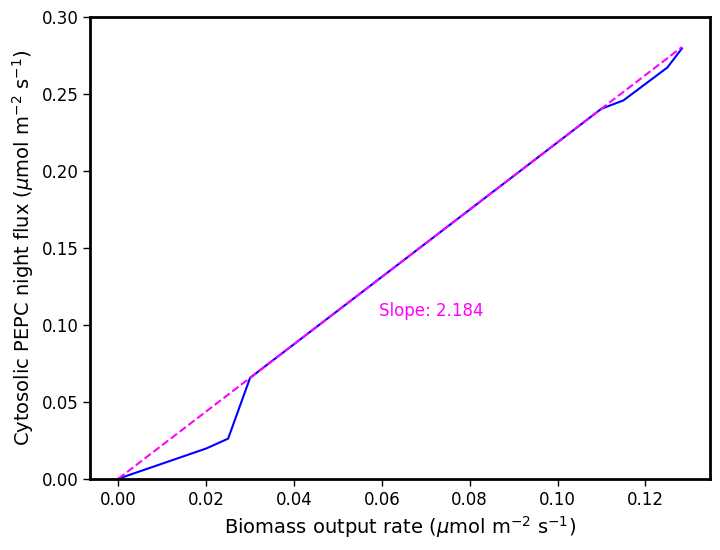

In [ ]:
# Plot nocturnal PEPC activity vs objective flux
df = df0

# Cytosol PEPC
fig, ax1 = plt.subplots(figsize=(8, 6))  # Create a figure and axis

# Plot the PEPC flux on the left y-axis
ax1.plot(df.T['AraCore_Biomass_tx_total'], df.T['PEPCARBOX_RXN_c_12'], label="Nocturnal cyt. PEPC", color='blue')
ax1.set_xlabel('Biomass output rate ($\mu$mol m$^{-2}$ s$^{-1}$)', fontsize=14)  # Increased font size
ax1.set_ylabel('Cytosolic PEPC night flux ($\mu$mol m$^{-2}$ s$^{-1}$)', fontsize=14)  # Increased font size
ax1.tick_params(axis='y', labelsize=12)  # Increased tick label size
ax1.tick_params(axis='x', labelsize=12)  # Increased tick label size

# Calculate slope for where the line is straight
x = df.T['AraCore_Biomass_tx_total'][8:16]
y = df.T['PEPCARBOX_RXN_c_12'][8:16]
x = x.dropna()
y = y.dropna()
slope, intercept = np.polyfit(x, y, 1)
print('The slope of PEPCARBOX_RXN_c_12 vs AraCore_Biomass_tx_total:', slope)
print('The intercept of PEPCARBOX_RXN_c_12 vs AraCore_Biomass_tx_total:', intercept)
PEPC_slope = slope

# Plot the trendline for PEPC flux
x = df.T['AraCore_Biomass_tx_total']
ax1.plot(x, slope * x + intercept, linestyle="dashed", color='magenta', label='Noct. cyt. PEPC trendline')
ax1.set_ylim(0, 0.3)

# Add text to display the slope on the plot
text_x = x.mean()  # Position the text at the mean of the x-axis data
text_y = slope * text_x + intercept  # Calculate the corresponding y value
ax1.text(text_x, text_y - 0.05, f"Slope: {slope:.3f}", color='magenta', fontsize=12, ha='center')  # Move text slightly below the trendline


# Add legends for both axes
# fig.legend(loc="upper left", bbox_to_anchor=(0.15, 0.86), fontsize=12)  # Increased legend font size

# Show the plot
plt.show()

The slope of PEPCARBOX_RXN_c_12 vs AraCore_Biomass_tx_total: 2.2553315593185044
The intercept of PEPCARBOX_RXN_c_12 vs AraCore_Biomass_tx_total: -0.008708634108408884


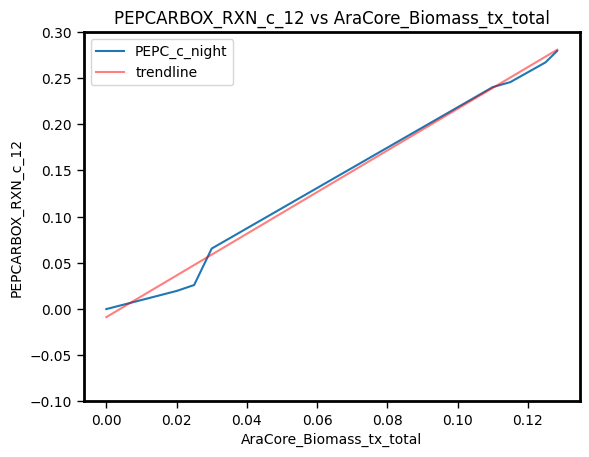

The slope of PEPCARBOX_RXN_c_12 vs AraCore_Biomass_tx_total: 2.1844080596948316
The intercept of PEPCARBOX_RXN_c_12 vs AraCore_Biomass_tx_total: 1.4758299164890712e-15


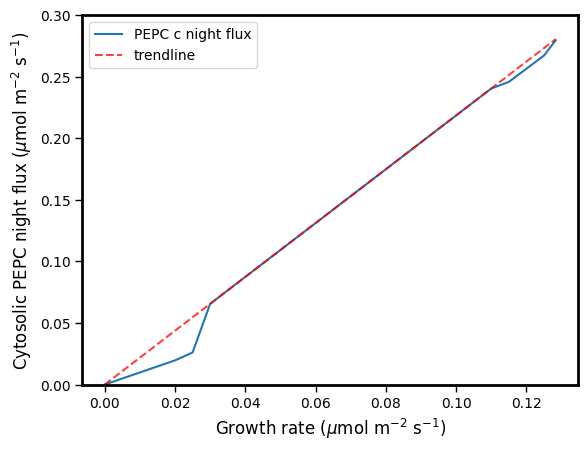

The slope of PEPCARBOX_RXN_p_12 vs AraCore_Biomass_tx_total: -1.017526185099907e-16
The intercept of PEPCARBOX_RXN_p_12vs AraCore_Biomass_tx_total: 7.448384104319534e-18


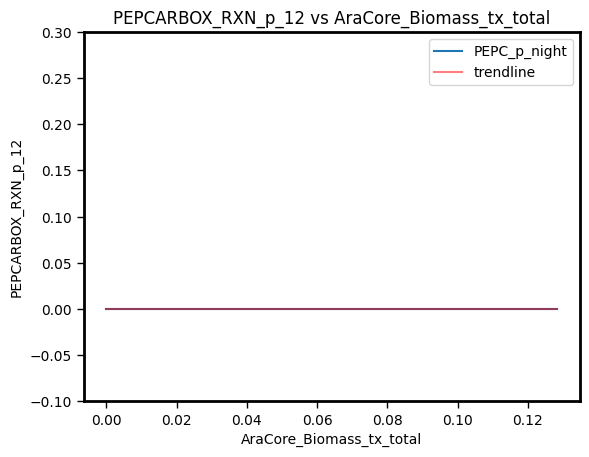

The slope of ISOCITDEH_RXN_c_12 vs AraCore_Biomass_tx_total: -0.5249589546080662
The intercept of ISOCITDEH_RXN_c_12 vs AraCore_Biomass_tx_total: -0.18860113507451653


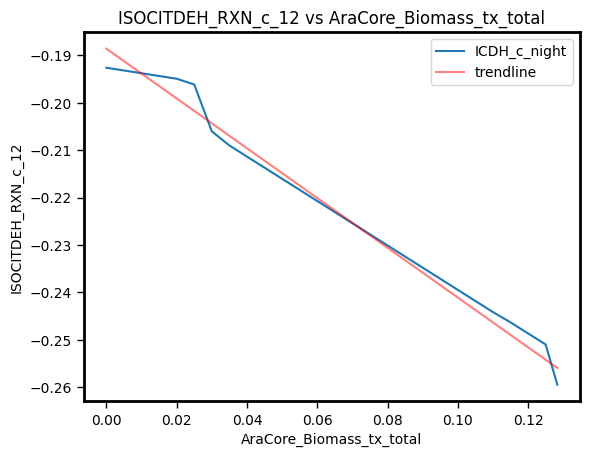

The slope of ISOCITDEH_RXN_x_12vs AraCore_Biomass_tx_total: -1.8087207297458805e-16
The intercept of ISOCITDEH_RXN_x_12 vs AraCore_Biomass_tx_total: 1.7301678878119866e-17


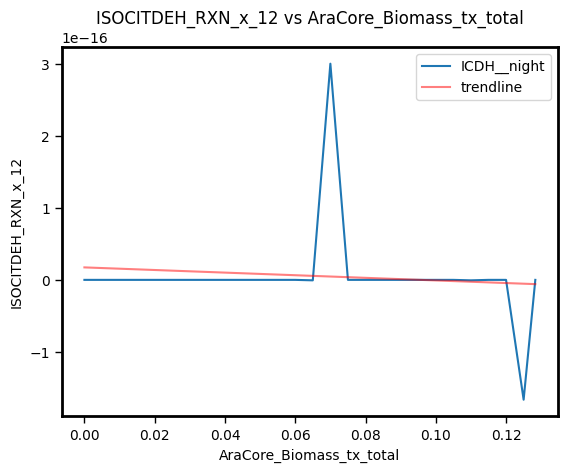

The slope of ISOCITDEH_RXN_m_12vs AraCore_Biomass_tx_total: -1.4357666802687906e-15
The intercept of ISOCITDEH_RXN_m_12 vs AraCore_Biomass_tx_total: 0.41834444444444435


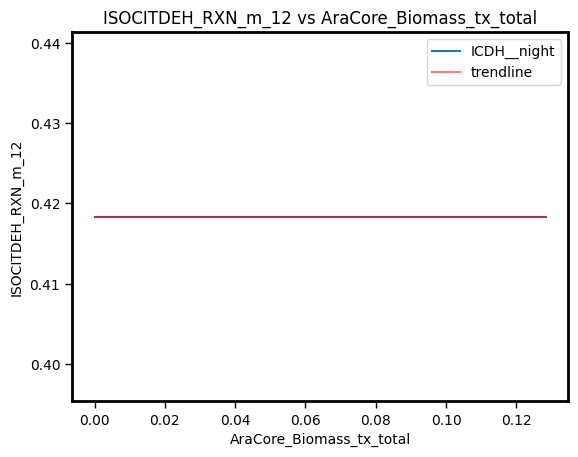

The slope of ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_12vs AraCore_Biomass_tx_total: 0.0
The intercept of ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_12 vs AraCore_Biomass_tx_total: 0.0


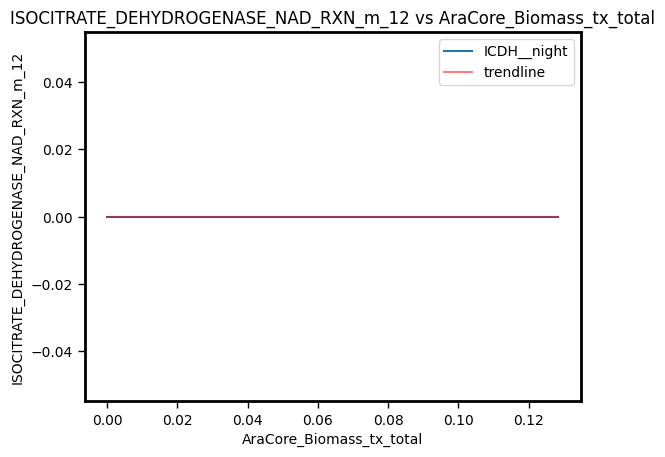

The slope of METHYLCROTONYL_COA_CARBOXYLASE_RXN_m_12vs AraCore_Biomass_tx_total: 0.0
The intercept of METHYLCROTONYL_COA_CARBOXYLASE_RXN_m_12 vs AraCore_Biomass_tx_total: 0.0


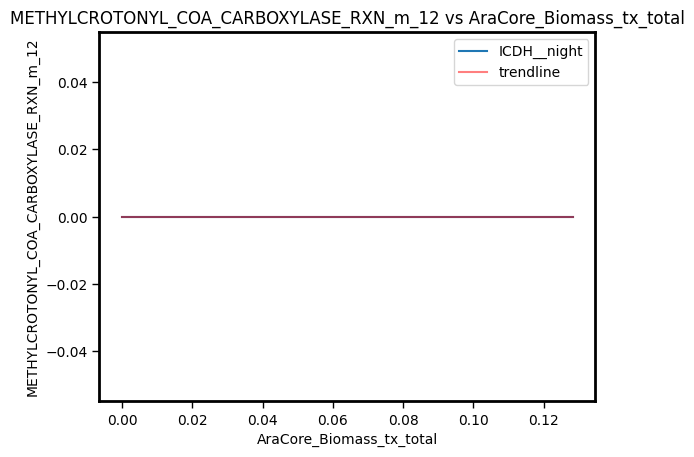

The slope of CARBAMATE_KINASE_RXN_p_12vs AraCore_Biomass_tx_total: -5.626196459668711e-17
The intercept of CARBAMATE_KINASE_RXN_p_12 vs AraCore_Biomass_tx_total: 1.5530033552508896e-18


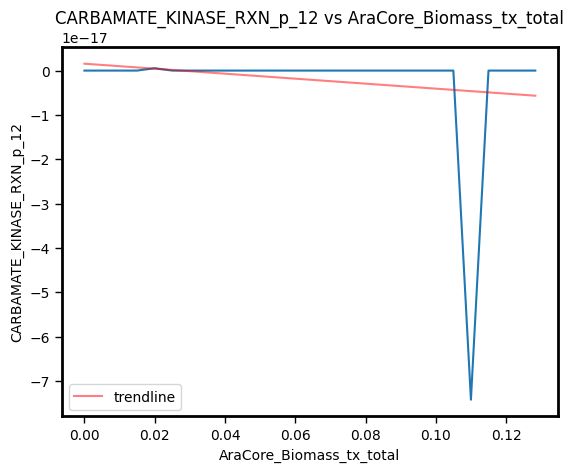

In [ ]:
#plot nocturnal PEPC activity vs objective flux
df = df0


# cytosol PEPC
# plot the data
plt.plot(df.T['AraCore_Biomass_tx_total'], df.T['PEPCARBOX_RXN_c_12'], label="PEPC_c_night")
plt.xlabel('AraCore_Biomass_tx_total')
plt.ylabel('PEPCARBOX_RXN_c_12')
plt.title('PEPCARBOX_RXN_c_12 vs AraCore_Biomass_tx_total')

# calculate the slope
x = df.T['AraCore_Biomass_tx_total']
y = df.T['PEPCARBOX_RXN_c_12']
x = x.dropna()
y = y.dropna()
slope, intercept = np.polyfit(x, y, 1)
print('The slope of PEPCARBOX_RXN_c_12 vs AraCore_Biomass_tx_total:', slope)
print('The intercept of PEPCARBOX_RXN_c_12 vs AraCore_Biomass_tx_total:', intercept)

# plot the trendline
plt.plot(x, slope*x + intercept,  color='red', label='trendline', alpha=0.5)
plt.ylim(-0.1, 0.3)
plt.legend()
plt.show()
PEPC_slope = slope



# cytosol PEPC
# plot the data
plt.plot(df.T['AraCore_Biomass_tx_total'], df.T['PEPCARBOX_RXN_c_12'], label="PEPC c night flux")
plt.xlabel('Growth rate ($\mu$mol m$^{-2}$ s$^{-1}$)', fontsize = 12)
plt.ylabel('Cytosolic PEPC night flux ($\mu$mol m$^{-2}$ s$^{-1}$)', fontsize = 12)
# plt.title('PEPCARBOX_RXN_c_12 vs AraCore_Biomass_tx_total')
#calculate slope for where line is straight
x = df.T['AraCore_Biomass_tx_total'][8:16]
y = df.T['PEPCARBOX_RXN_c_12'][8:16]
x = x.dropna()
y = y.dropna()
slope, intercept = np.polyfit(x, y, 1)
print('The slope of PEPCARBOX_RXN_c_12 vs AraCore_Biomass_tx_total:', slope)
print('The intercept of PEPCARBOX_RXN_c_12 vs AraCore_Biomass_tx_total:', intercept)
PEPC_slope = slope
# plot the trendline
x = df.T['AraCore_Biomass_tx_total']
plt.plot(x, slope*x + intercept, linestyle = "dashed", color='red', label='trendline', alpha=0.75)
plt.ylim(0, 0.3)


plt.legend()
plt.show()






# plastidic PEPC
# plot the data
plt.plot(df.T['AraCore_Biomass_tx_total'], df.T['PEPCARBOX_RXN_p_12'], label="PEPC_p_night")
plt.xlabel('AraCore_Biomass_tx_total')
plt.ylabel('PEPCARBOX_RXN_p_12')
plt.title('PEPCARBOX_RXN_p_12 vs AraCore_Biomass_tx_total')

# calculate the slope
x = df.T['AraCore_Biomass_tx_total']
y = df.T['PEPCARBOX_RXN_p_12']
x = x.dropna()
y = y.dropna()
slope, intercept = np.polyfit(x, y, 1)
print('The slope of PEPCARBOX_RXN_p_12 vs AraCore_Biomass_tx_total:', slope)
print('The intercept of PEPCARBOX_RXN_p_12vs AraCore_Biomass_tx_total:', intercept)





# plot the trendline
plt.plot(x, slope*x + intercept, color='red', label='trendline', alpha=0.5)
plt.ylim(-0.1, 0.3)
plt.legend()
plt.show()


# cytosolic ICDH
# plot the data
plt.plot(df.T['AraCore_Biomass_tx_total'], df.T['ISOCITDEH_RXN_c_12'], label="ICDH_c_night")
plt.xlabel('AraCore_Biomass_tx_total')
plt.ylabel('ISOCITDEH_RXN_c_12')
plt.title('ISOCITDEH_RXN_c_12 vs AraCore_Biomass_tx_total')

# calculate the slope
x = df.T['AraCore_Biomass_tx_total']
y = df.T['ISOCITDEH_RXN_c_12']
x = x.dropna()
y = y.dropna()
slope, intercept = np.polyfit(x, y, 1)
print('The slope of ISOCITDEH_RXN_c_12 vs AraCore_Biomass_tx_total:', slope)
print('The intercept of ISOCITDEH_RXN_c_12 vs AraCore_Biomass_tx_total:', intercept)

# plot the trendline
plt.plot(x, slope*x + intercept, color='red', label='trendline', alpha=0.5)
#plt.ylim(-0.1, 0.3)
plt.legend()
plt.show()

# peroxisomal ICDH
# plot the data
ICDH = 'ISOCITDEH_RXN_x_12'

plt.plot(df.T['AraCore_Biomass_tx_total'], df.T[ICDH], label="ICDH_"+ICDH[-4:3]+"_night")
plt.xlabel('AraCore_Biomass_tx_total')
plt.ylabel(ICDH)
plt.title(ICDH+' vs AraCore_Biomass_tx_total')

# calculate the slope
x = df.T['AraCore_Biomass_tx_total']
y = df.T[ICDH]
x = x.dropna()
y = y.dropna()
slope, intercept = np.polyfit(x, y, 1)
print('The slope of '+ICDH+'vs AraCore_Biomass_tx_total:', slope)
print('The intercept of '+ICDH+' vs AraCore_Biomass_tx_total:', intercept)

# plot the trendline
plt.plot(x, slope*x + intercept, color='red', label='trendline', alpha=0.5)
#plt.ylim(-0.1, 0.3)
plt.legend()
plt.show()

# mitochondiral ICDH
# plot the data
ICDH = 'ISOCITDEH_RXN_m_12'

plt.plot(df.T['AraCore_Biomass_tx_total'], df.T[ICDH], label="ICDH_"+ICDH[-4:3]+"_night")
plt.xlabel('AraCore_Biomass_tx_total')
plt.ylabel(ICDH)
plt.title(ICDH+' vs AraCore_Biomass_tx_total')

# calculate the slope
x = df.T['AraCore_Biomass_tx_total']
y = df.T[ICDH]
x = x.dropna()
y = y.dropna()
slope, intercept = np.polyfit(x, y, 1)
print('The slope of '+ICDH+'vs AraCore_Biomass_tx_total:', slope)
print('The intercept of '+ICDH+' vs AraCore_Biomass_tx_total:', intercept)

# plot the trendline
plt.plot(x, slope*x + intercept, color='red', label='trendline', alpha=0.5)
#plt.ylim(-0.1, 0.3)
plt.legend()
plt.show()

# mitochondiral ICDH
# plot the data
ICDH = 'ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_12'

plt.plot(df.T['AraCore_Biomass_tx_total'], df.T[ICDH], label="ICDH_"+ICDH[-4:3]+"_night")
plt.xlabel('AraCore_Biomass_tx_total')
plt.ylabel(ICDH)
plt.title(ICDH+' vs AraCore_Biomass_tx_total')

# calculate the slope
x = df.T['AraCore_Biomass_tx_total']
y = df.T[ICDH]
x = x.dropna()
y = y.dropna()
slope, intercept = np.polyfit(x, y, 1)
print('The slope of '+ICDH+'vs AraCore_Biomass_tx_total:', slope)
print('The intercept of '+ICDH+' vs AraCore_Biomass_tx_total:', intercept)

# plot the trendline
plt.plot(x, slope*x + intercept, color='red', label='trendline', alpha=0.5)
#plt.ylim(-0.1, 0.3)
plt.legend()
plt.show()

# plot METHYLCROTONYL_COA_CARBOXYLASE_RXN_m_12

rxn = 'METHYLCROTONYL_COA_CARBOXYLASE_RXN_m_12'

plt.plot(df.T['AraCore_Biomass_tx_total'], df.T[rxn], label="ICDH_"+rxn[-4:3]+"_night")
plt.xlabel('AraCore_Biomass_tx_total')
plt.ylabel(rxn)
plt.title(rxn+' vs AraCore_Biomass_tx_total')

# calculate the slope
x = df.T['AraCore_Biomass_tx_total']
y = df.T[rxn]
x = x.dropna()
y = y.dropna()
slope, intercept = np.polyfit(x, y, 1)
print('The slope of '+rxn+'vs AraCore_Biomass_tx_total:', slope)
print('The intercept of '+rxn+' vs AraCore_Biomass_tx_total:', intercept)

# plot the trendline
plt.plot(x, slope*x + intercept, color='red', label='trendline', alpha=0.5)
#plt.ylim(-0.1, 0.3)
plt.legend()
plt.show()

# plot CARBAMATE_KINASE_RXN_p_12

rxn = 'CARBAMATE_KINASE_RXN_p_12'

plt.plot(df.T['AraCore_Biomass_tx_total'], df.T[rxn], label=rxn[-4:3]+"_night")
plt.xlabel('AraCore_Biomass_tx_total')
plt.ylabel(rxn)
plt.title(rxn+' vs AraCore_Biomass_tx_total')

# calculate the slope
x = df.T['AraCore_Biomass_tx_total']
y = df.T[rxn]
x = x.dropna()
y = y.dropna()
slope, intercept = np.polyfit(x, y, 1)
print('The slope of '+rxn+'vs AraCore_Biomass_tx_total:', slope)
print('The intercept of '+rxn+' vs AraCore_Biomass_tx_total:', intercept)

# plot the trendline
plt.plot(x, slope*x + intercept, color='red', label='trendline', alpha=0.5)
#plt.ylim(-0.1, 0.3)
plt.legend()
plt.show()






In [ ]:
# scan over upper bound on CO2 uptake, while constraining PEPCs at night, to value in C3 behaviour model

diel_model_noCAM = diel_model.copy()
set_PEPC_C3_constraints(diel_model_noCAM, slope=PEPC_slope, objective = output_string+"_total")

df_C1, sol_C1 = parameter_scan_CO2(diel_model_noCAM, output_string+"_total", "CO2_tx"+day_tag, 0, 17, 0.5, pFBA=True, 
                    CO2_refixation_allowed=True, verbose=True, iterations=50)


Setting new PEPC_obj_const constraint, with slope 2.1844080596948316 .
Scanning process: CO2_tx_00 

------- Scan iteration: 1      Scan value: 0.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration is infeasible!
------- Scan iteration: 2      Scan value: 0.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration is infeasible!
------- Scan iteration: 3      Scan value: 1.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0003446
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.000753
producing HCO3-:	RXN0_5224_c_12	0.000753
producing CO2:	CO2_pc_12	0.210023
consuming CO2:	ISOCITDEH_RXN_c_12	-0.418236
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	9.8e-05
producing CO2:	CO2_mc_12	1.179007
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.000753
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	2.2e-05
producing CO2:	RXN_9652_p_12	6.6e-05
producing CO2:	RXN_9650_p_12	6.6e-05
producing 

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 4      Scan value: 1.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0061154
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.013359
producing HCO3-:	RXN0_5224_c_12	0.013359
producing CO2:	CO2_pc_12	0.22426
consuming CO2:	ISOCITDEH_RXN_c_12	-0.416426
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.001735
producing CO2:	CO2_mc_12	1.173912
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.013359
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.000392
producing CO2:	RXN_9652_p_12	0.001179
producing CO2:	RXN_9650_p_12	0.001179
producing CO2:	RXN_5682_p_12	0.000253
producing CO2:	2.3.1.180_RXN_p_12	0.001179
producing CO2:	RXN_9654_p_12	0.001179
consuming CO2:	RXN0_5224_p_12	0.008253
producing HCO3-:	RXN0_5224_p_12	0.008253
consuming CO2:	CO2_pc_12	0.22426
producing CO2:	1.2.1.2_RXN_p_12	0.000195
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.008253
producing CO2:	PYRUVDEH_RXN_p_12	0.009432
p

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 5      Scan value: 2.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0118862
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.025964
producing HCO3-:	RXN0_5224_c_12	0.025964
producing CO2:	CO2_pc_12	0.238498
consuming CO2:	ISOCITDEH_RXN_c_12	-0.414616
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.003373
producing CO2:	CO2_mc_12	1.168817
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.025964
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.000762
producing CO2:	RXN_9652_p_12	0.002292
producing CO2:	RXN_9650_p_12	0.002292
producing CO2:	RXN_5682_p_12	0.000492
producing CO2:	2.3.1.180_RXN_p_12	0.002292
producing CO2:	RXN_9654_p_12	0.002292
consuming CO2:	RXN0_5224_p_12	0.016041
producing HCO3-:	RXN0_5224_p_12	0.016041
consuming CO2:	CO2_pc_12	0.238498
producing CO2:	1.2.1.2_RXN_p_12	0.00038
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.016041
producing CO2:	PYRUVDEH_RXN_p_12	0.018332


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 6      Scan value: 2.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0176569
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.03857
producing HCO3-:	RXN0_5224_c_12	0.03857
producing CO2:	CO2_pc_12	0.252735
consuming CO2:	ISOCITDEH_RXN_c_12	-0.412805
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.00501
producing CO2:	CO2_mc_12	1.163723
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.03857
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.001132
producing CO2:	RXN_9652_p_12	0.003404
producing CO2:	RXN_9650_p_12	0.003404
producing CO2:	RXN_5682_p_12	0.00073
producing CO2:	2.3.1.180_RXN_p_12	0.003404
producing CO2:	RXN_9654_p_12	0.003404
consuming CO2:	RXN0_5224_p_12	0.023828
producing HCO3-:	RXN0_5224_p_12	0.023828
consuming CO2:	CO2_pc_12	0.252735
producing CO2:	1.2.1.2_RXN_p_12	0.000564
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.023828
producing CO2:	PYRUVDEH_RXN_p_12	0.027232
prod

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 7      Scan value: 3.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0234277
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.051176
producing HCO3-:	RXN0_5224_c_12	0.051176
producing CO2:	CO2_pc_12	0.266224
consuming CO2:	ISOCITDEH_RXN_c_12	-0.410995
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.006647
producing CO2:	CO2_mc_12	1.159376
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.051176
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.001502
producing CO2:	RXN_9652_p_12	0.004517
producing CO2:	RXN_9650_p_12	0.004517
producing CO2:	RXN_5682_p_12	0.000969
producing CO2:	2.3.1.180_RXN_p_12	0.004517
producing CO2:	RXN_9654_p_12	0.004517
consuming CO2:	RXN0_5224_p_12	0.031616
producing HCO3-:	RXN0_5224_p_12	0.031616
consuming CO2:	CO2_pc_12	0.266224
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.031616
producing CO2:	PYRUVDEH_RXN_p_12	0.036133
producing CO2:	RXN_9653_p_12	0.004517
pr

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 8      Scan value: 3.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0291984
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.063781
producing HCO3-:	RXN0_5224_c_12	0.063781
producing CO2:	CO2_pc_12	0.280277
consuming CO2:	ISOCITDEH_RXN_c_12	-0.409185
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.008285
producing CO2:	CO2_mc_12	1.154466
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.063781
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.001872
producing CO2:	RXN_9652_p_12	0.005629
producing CO2:	RXN_9650_p_12	0.005629
producing CO2:	RXN_5682_p_12	0.001207
producing CO2:	2.3.1.180_RXN_p_12	0.005629
producing CO2:	RXN_9654_p_12	0.005629
consuming CO2:	RXN0_5224_p_12	0.039404
producing HCO3-:	RXN0_5224_p_12	0.039404
consuming CO2:	CO2_pc_12	0.280277
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.039404
producing CO2:	PYRUVDEH_RXN_p_12	0.045033
producing CO2:	RXN_9653_p_12	0.005629
pr

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 9      Scan value: 4.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0349692
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.076387
producing HCO3-:	RXN0_5224_c_12	0.076387
producing CO2:	CO2_pc_12	0.294331
consuming CO2:	ISOCITDEH_RXN_c_12	-0.407375
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.009922
producing CO2:	CO2_mc_12	1.149555
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.076387
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.002242
producing CO2:	RXN_9652_p_12	0.006742
producing CO2:	RXN_9650_p_12	0.006742
producing CO2:	RXN_5682_p_12	0.001446
producing CO2:	2.3.1.180_RXN_p_12	0.006742
producing CO2:	RXN_9654_p_12	0.006742
consuming CO2:	RXN0_5224_p_12	0.047191
producing HCO3-:	RXN0_5224_p_12	0.047191
consuming CO2:	CO2_pc_12	0.294331
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.047191
producing CO2:	PYRUVDEH_RXN_p_12	0.053933
producing CO2:	RXN_9653_p_12	0.006742
pr

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 10      Scan value: 4.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0407399
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.088993
producing HCO3-:	RXN0_5224_c_12	0.088993
producing CO2:	CO2_pc_12	0.308384
consuming CO2:	ISOCITDEH_RXN_c_12	-0.405564
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.011559
producing CO2:	CO2_mc_12	1.144645
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.088993
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.002612
producing CO2:	RXN_9652_p_12	0.007854
producing CO2:	RXN_9650_p_12	0.007854
producing CO2:	RXN_5682_p_12	0.001685
producing CO2:	2.3.1.180_RXN_p_12	0.007854
producing CO2:	RXN_9654_p_12	0.007854
consuming CO2:	RXN0_5224_p_12	0.054979
producing HCO3-:	RXN0_5224_p_12	0.054979
consuming CO2:	CO2_pc_12	0.308384
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.054979
producing CO2:	PYRUVDEH_RXN_p_12	0.062833
producing CO2:	RXN_9653_p_12	0.007854
p

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 11      Scan value: 5.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0465107
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.101598
producing HCO3-:	RXN0_5224_c_12	0.101598
producing CO2:	CO2_pc_12	0.322437
consuming CO2:	ISOCITDEH_RXN_c_12	-0.403754
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.013197
producing CO2:	CO2_mc_12	1.139734
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.101598
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.002982
producing CO2:	RXN_9652_p_12	0.008967
producing CO2:	RXN_9650_p_12	0.008967
producing CO2:	RXN_5682_p_12	0.001923
producing CO2:	2.3.1.180_RXN_p_12	0.008967
producing CO2:	RXN_9654_p_12	0.008967
consuming CO2:	RXN0_5224_p_12	0.062767
producing HCO3-:	RXN0_5224_p_12	0.062767
consuming CO2:	CO2_pc_12	0.322437
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.062767
producing CO2:	PYRUVDEH_RXN_p_12	0.071734
producing CO2:	RXN_9653_p_12	0.008967
p

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 12      Scan value: 5.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0522815
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.114204
producing HCO3-:	RXN0_5224_c_12	0.114204
producing CO2:	CO2_pc_12	0.33649
consuming CO2:	ISOCITDEH_RXN_c_12	-0.401944
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.014834
producing CO2:	CO2_mc_12	1.134824
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.114204
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.003352
producing CO2:	RXN_9652_p_12	0.010079
producing CO2:	RXN_9650_p_12	0.010079
producing CO2:	RXN_5682_p_12	0.002162
producing CO2:	2.3.1.180_RXN_p_12	0.010079
producing CO2:	RXN_9654_p_12	0.010079
consuming CO2:	RXN0_5224_p_12	0.070555
producing HCO3-:	RXN0_5224_p_12	0.070555
consuming CO2:	CO2_pc_12	0.33649
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.070555
producing CO2:	PYRUVDEH_RXN_p_12	0.080634
producing CO2:	RXN_9653_p_12	0.010079
pro

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 13      Scan value: 6.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0580522
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.12681
producing HCO3-:	RXN0_5224_c_12	0.12681
producing CO2:	CO2_pc_12	0.350543
consuming CO2:	ISOCITDEH_RXN_c_12	-0.400134
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.016471
producing CO2:	CO2_mc_12	1.129913
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.12681
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.003722
producing CO2:	RXN_9652_p_12	0.011192
producing CO2:	RXN_9650_p_12	0.011192
producing CO2:	RXN_5682_p_12	0.002401
producing CO2:	2.3.1.180_RXN_p_12	0.011192
producing CO2:	RXN_9654_p_12	0.011192
consuming CO2:	RXN0_5224_p_12	0.078342
producing HCO3-:	RXN0_5224_p_12	0.078342
consuming CO2:	CO2_pc_12	0.350543
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.078342
producing CO2:	PYRUVDEH_RXN_p_12	0.089534
producing CO2:	RXN_9653_p_12	0.011192
prod

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 14      Scan value: 6.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.063823
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.139415
producing HCO3-:	RXN0_5224_c_12	0.139415
producing CO2:	CO2_pc_12	0.364596
consuming CO2:	ISOCITDEH_RXN_c_12	-0.398323
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.018109
producing CO2:	CO2_mc_12	1.125003
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.139415
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.004092
producing CO2:	RXN_9652_p_12	0.012304
producing CO2:	RXN_9650_p_12	0.012304
producing CO2:	RXN_5682_p_12	0.002639
producing CO2:	2.3.1.180_RXN_p_12	0.012304
producing CO2:	RXN_9654_p_12	0.012304
consuming CO2:	RXN0_5224_p_12	0.08613
producing HCO3-:	RXN0_5224_p_12	0.08613
consuming CO2:	CO2_pc_12	0.364596
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.08613
producing CO2:	PYRUVDEH_RXN_p_12	0.098434
producing CO2:	RXN_9653_p_12	0.012304
produ

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 15      Scan value: 7.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0695937
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.152021
producing HCO3-:	RXN0_5224_c_12	0.152021
producing CO2:	CO2_pc_12	0.37865
consuming CO2:	ISOCITDEH_RXN_c_12	-0.396513
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.019746
producing CO2:	CO2_mc_12	1.120092
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.152021
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.004462
producing CO2:	RXN_9652_p_12	0.013417
producing CO2:	RXN_9650_p_12	0.013417
producing CO2:	RXN_5682_p_12	0.002878
producing CO2:	2.3.1.180_RXN_p_12	0.013417
producing CO2:	RXN_9654_p_12	0.013417
consuming CO2:	RXN0_5224_p_12	0.093918
producing HCO3-:	RXN0_5224_p_12	0.093918
consuming CO2:	CO2_pc_12	0.37865
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.093918
producing CO2:	PYRUVDEH_RXN_p_12	0.107335
producing CO2:	RXN_9653_p_12	0.013417
pro

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 16      Scan value: 7.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0753645
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.164627
producing HCO3-:	RXN0_5224_c_12	0.164627
producing CO2:	CO2_pc_12	0.392703
consuming CO2:	ISOCITDEH_RXN_c_12	-0.394703
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.021384
producing CO2:	CO2_mc_12	1.115182
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.164627
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.004832
producing CO2:	RXN_9652_p_12	0.014529
producing CO2:	RXN_9650_p_12	0.014529
producing CO2:	RXN_5682_p_12	0.003116
producing CO2:	2.3.1.180_RXN_p_12	0.014529
producing CO2:	RXN_9654_p_12	0.014529
consuming CO2:	RXN0_5224_p_12	0.101706
producing HCO3-:	RXN0_5224_p_12	0.101706
consuming CO2:	CO2_pc_12	0.392703
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.101706
producing CO2:	PYRUVDEH_RXN_p_12	0.116235
producing CO2:	RXN_9653_p_12	0.014529
p

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 17      Scan value: 8.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0811352
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.177232
producing HCO3-:	RXN0_5224_c_12	0.177232
producing CO2:	CO2_pc_12	0.406756
consuming CO2:	ISOCITDEH_RXN_c_12	-0.392892
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.023021
producing CO2:	CO2_mc_12	1.110271
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.177232
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.005202
producing CO2:	RXN_9652_p_12	0.015642
producing CO2:	RXN_9650_p_12	0.015642
producing CO2:	RXN_5682_p_12	0.003355
producing CO2:	2.3.1.180_RXN_p_12	0.015642
producing CO2:	RXN_9654_p_12	0.015642
consuming CO2:	RXN0_5224_p_12	0.109493
producing HCO3-:	RXN0_5224_p_12	0.109493
consuming CO2:	CO2_pc_12	0.406756
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.109493
producing CO2:	PYRUVDEH_RXN_p_12	0.125135
producing CO2:	RXN_9653_p_12	0.015642
p

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 18      Scan value: 8.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.086906
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.189838
producing HCO3-:	RXN0_5224_c_12	0.189838
producing CO2:	CO2_pc_12	0.420809
consuming CO2:	ISOCITDEH_RXN_c_12	-0.391082
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.024658
producing CO2:	CO2_mc_12	1.10536
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.189838
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.005572
producing CO2:	RXN_9652_p_12	0.016754
producing CO2:	RXN_9650_p_12	0.016754
producing CO2:	RXN_5682_p_12	0.003594
producing CO2:	2.3.1.180_RXN_p_12	0.016754
producing CO2:	RXN_9654_p_12	0.016754
consuming CO2:	RXN0_5224_p_12	0.117281
producing HCO3-:	RXN0_5224_p_12	0.117281
consuming CO2:	CO2_pc_12	0.420809
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.117281
producing CO2:	PYRUVDEH_RXN_p_12	0.134036
producing CO2:	RXN_9653_p_12	0.016754
pro

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 19      Scan value: 9.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0926768
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.202444
producing HCO3-:	RXN0_5224_c_12	0.202444
producing CO2:	CO2_pc_12	0.434862
consuming CO2:	ISOCITDEH_RXN_c_12	-0.389272
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.026296
producing CO2:	CO2_mc_12	1.10045
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.202444
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.005942
producing CO2:	RXN_9652_p_12	0.017867
producing CO2:	RXN_9650_p_12	0.017867
producing CO2:	RXN_5682_p_12	0.003832
producing CO2:	2.3.1.180_RXN_p_12	0.017867
producing CO2:	RXN_9654_p_12	0.017867
consuming CO2:	RXN0_5224_p_12	0.125069
producing HCO3-:	RXN0_5224_p_12	0.125069
consuming CO2:	CO2_pc_12	0.434862
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.125069
producing CO2:	PYRUVDEH_RXN_p_12	0.142936
producing CO2:	RXN_9653_p_12	0.017867
pr

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 20      Scan value: 9.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0984475
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.21505
producing HCO3-:	RXN0_5224_c_12	0.21505
producing CO2:	CO2_pc_12	0.448915
consuming CO2:	ISOCITDEH_RXN_c_12	-0.387462
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.027933
producing CO2:	CO2_mc_12	1.095539
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.21505
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.006312
producing CO2:	RXN_9652_p_12	0.01898
producing CO2:	RXN_9650_p_12	0.01898
producing CO2:	RXN_5682_p_12	0.004071
producing CO2:	2.3.1.180_RXN_p_12	0.01898
producing CO2:	RXN_9654_p_12	0.01898
consuming CO2:	RXN0_5224_p_12	0.132857
producing HCO3-:	RXN0_5224_p_12	0.132857
consuming CO2:	CO2_pc_12	0.448915
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.132857
producing CO2:	PYRUVDEH_RXN_p_12	0.151836
producing CO2:	RXN_9653_p_12	0.01898
producing

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 21      Scan value: 10.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1042183
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.227655
producing HCO3-:	RXN0_5224_c_12	0.227655
producing CO2:	CO2_pc_12	0.462969
consuming CO2:	ISOCITDEH_RXN_c_12	-0.385651
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.02957
producing CO2:	CO2_mc_12	1.090629
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.227655
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.006681
producing CO2:	RXN_9652_p_12	0.020092
producing CO2:	RXN_9650_p_12	0.020092
producing CO2:	RXN_5682_p_12	0.00431
producing CO2:	2.3.1.180_RXN_p_12	0.020092
producing CO2:	RXN_9654_p_12	0.020092
consuming CO2:	RXN0_5224_p_12	0.140644
producing HCO3-:	RXN0_5224_p_12	0.140644
consuming CO2:	CO2_pc_12	0.462969
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.140644
producing CO2:	PYRUVDEH_RXN_p_12	0.160736
producing CO2:	RXN_9653_p_12	0.020092
pr

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 22      Scan value: 10.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.109989
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.240261
producing HCO3-:	RXN0_5224_c_12	0.240261
producing CO2:	CO2_pc_12	0.477022
consuming CO2:	ISOCITDEH_RXN_c_12	-0.383841
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.031208
producing CO2:	CO2_mc_12	1.085718
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.240261
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.007051
producing CO2:	RXN_9652_p_12	0.021205
producing CO2:	RXN_9650_p_12	0.021205
producing CO2:	RXN_5682_p_12	0.004548
producing CO2:	2.3.1.180_RXN_p_12	0.021205
producing CO2:	RXN_9654_p_12	0.021205
consuming CO2:	RXN0_5224_p_12	0.148432
producing HCO3-:	RXN0_5224_p_12	0.148432
consuming CO2:	CO2_pc_12	0.477022
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.148432
producing CO2:	PYRUVDEH_RXN_p_12	0.169637
producing CO2:	RXN_9653_p_12	0.021205
p

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 23      Scan value: 11.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1157598
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.252867
producing HCO3-:	RXN0_5224_c_12	0.252867
producing CO2:	CO2_pc_12	0.491075
consuming CO2:	ISOCITDEH_RXN_c_12	-0.382031
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.032845
producing CO2:	CO2_mc_12	1.080808
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.252867
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.007421
producing CO2:	RXN_9652_p_12	0.022317
producing CO2:	RXN_9650_p_12	0.022317
producing CO2:	RXN_5682_p_12	0.004787
producing CO2:	2.3.1.180_RXN_p_12	0.022317
producing CO2:	RXN_9654_p_12	0.022317
consuming CO2:	RXN0_5224_p_12	0.15622
producing HCO3-:	RXN0_5224_p_12	0.15622
consuming CO2:	CO2_pc_12	0.491075
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.15622
producing CO2:	PYRUVDEH_RXN_p_12	0.178537
producing CO2:	RXN_9653_p_12	0.022317
pro

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 24      Scan value: 11.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1215305
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.265472
producing HCO3-:	RXN0_5224_c_12	0.265472
producing CO2:	CO2_pc_12	0.505128
consuming CO2:	ISOCITDEH_RXN_c_12	-0.38022
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.034483
producing CO2:	CO2_mc_12	1.075897
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.265472
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.007791
producing CO2:	RXN_9652_p_12	0.02343
producing CO2:	RXN_9650_p_12	0.02343
producing CO2:	RXN_5682_p_12	0.005025
producing CO2:	2.3.1.180_RXN_p_12	0.02343
producing CO2:	RXN_9654_p_12	0.02343
consuming CO2:	RXN0_5224_p_12	0.164007
producing HCO3-:	RXN0_5224_p_12	0.164007
consuming CO2:	CO2_pc_12	0.505128
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.164007
producing CO2:	PYRUVDEH_RXN_p_12	0.187437
producing CO2:	RXN_9653_p_12	0.02343
produc

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 25      Scan value: 12.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1266073
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.276562
producing HCO3-:	RXN0_5224_c_12	0.276562
producing CO2:	CO2_pc_12	0.544707
consuming CO2:	ISOCITDEH_RXN_c_12	-0.378628
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.035923
producing CO2:	CO2_mc_12	0.70666
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.392599
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.276562
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005235
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.003641
producing CO2:	RXN_9652_p_12	0.024408
producing CO2:	RXN_9650_p_12	0.024408
producing CO2:	2.3.1.180_RXN_p_12	0.024408
producing CO2:	RXN_9654_p_12	0.024408
consuming CO2:	RXN0_5224_p_12	0.170859
producing HCO3-:	RXN0_5224_p_12	0.170859
consuming CO2:	CO2_pc_12	0.544707
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.170859
produ

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 26      Scan value: 12.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	P

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 27      Scan value: 13.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	P

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 28      Scan value: 13.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	P

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 29      Scan value: 14.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	P

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 30      Scan value: 14.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	P

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 31      Scan value: 15.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	P

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 32      Scan value: 15.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	P

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 33      Scan value: 16.0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	P

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 34      Scan value: 16.5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	P

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


In [ ]:

#place constraint on PEPC activity relative to objective flux
PEPC_slope = 2.1844080596948316

PEPC_const_model = diel_model.copy()
set_PEPC_C3_constraints(PEPC_const_model, slope=PEPC_slope, objective = output_string+"_total")

PEPC_const_model.reactions.get_by_id("CO2_tx"+day_tag).upper_bound = CO2_uptake

#optimise
solution_PEPC_const, PEPC_const_model_opt = optimise_model(PEPC_const_model, output_string+"_total", pFBA=True)
calculate_noct_CO2_refixation_coefficient(PEPC_const_model_opt, verbose=True, threshold = 0.00001, show_noflux = False)




Setting new PEPC_obj_const constraint, with slope 2.1844080596948316 .
Objective: AraCore_Biomass_tx_total
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.143021
producing HCO3-:	RXN0_5224_c_12	0.143021
producing CO2:	CO2_pc_12	0.368616
consuming CO2:	ISOCITDEH_RXN_c_12	-0.397805
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.018577
producing CO2:	CO2_mc_12	1.123598
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.143021
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.004198
producing CO2:	RXN_9652_p_12	0.012622
producing CO2:	RXN_9650_p_12	0.012622
producing CO2:	RXN_5682_p_12	0.002707
producing CO2:	2.3.1.180_RXN_p_12	0.012622
producing CO2:	RXN_9654_p_12	0.012622
consuming CO2:	RXN0_5224_p_12	0.088357
producing HCO3-:	RXN0_5224_p_12	0.088357
consuming CO2:	CO2_pc_12	0.368616
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.088357
producing CO2:	PYRUVDEH_RXN_p_12	0.10098
producing CO2:	RXN_9653_p_12	0.012622
producing CO2:	RXN_9651_p_12	0.012622
consuming CO2

0.3949893407673123

In [ ]:
df_list = [df_A1, df_B1, df_C1]
df_name_list = ["C3", "CAM", "PEPC_constrained"]

In [ ]:
df_list = [df_A1, df_B1, df_C1]
df_name_list = ["C3", "CAM", "PEPC_constrained", "PEPC_c_off", "PEPC_c_PEPC_p_off", "PEPC_c_PEPC_p_ICDH_c_off", 
"PEPC_c_PEPC_p_ICDH_c_ICDH_x_off", "PEPC_c_PEPC_p_off_ICDH_c_ICDH_x_ICDH_m_irrev", "PEPC_c_PEPC_p_off_ICDH_c_ICDH_x_ICDH_m_irrev_CK_irrev"]
models = [C3_model_opt, CAM_cyc_model_opt, PEPC_const_model_opt]
solutions = [solution_C3, solution_CAM_cyc, solution_PEPC_const]

0.0 0.0
0.044199293580085744 -0.9198319509352522
0.0 0.0
-0.01618342210862914 0.020523399171000156
0.025653290225774023 -0.6868977325671243
0.04706198085440496 -1.0596405954269197
0.03862113633248478 0.15763381123132497
-0.020271583467375214 1.239045209377057
0.022472423623564396 0.5063649721623139
0.0002449300650995527 0.00010213460737772714
8.933982082397591e-05 4.6227263515272675e-05
0.0 0.0
2.764596375775763e-19 -3.366777371484505e-18
0.00010453696101475904 0.002401760839861684
0.0016418876845997188 0.06252914410392849
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
-0.06488384448356196 1.0147253376458494


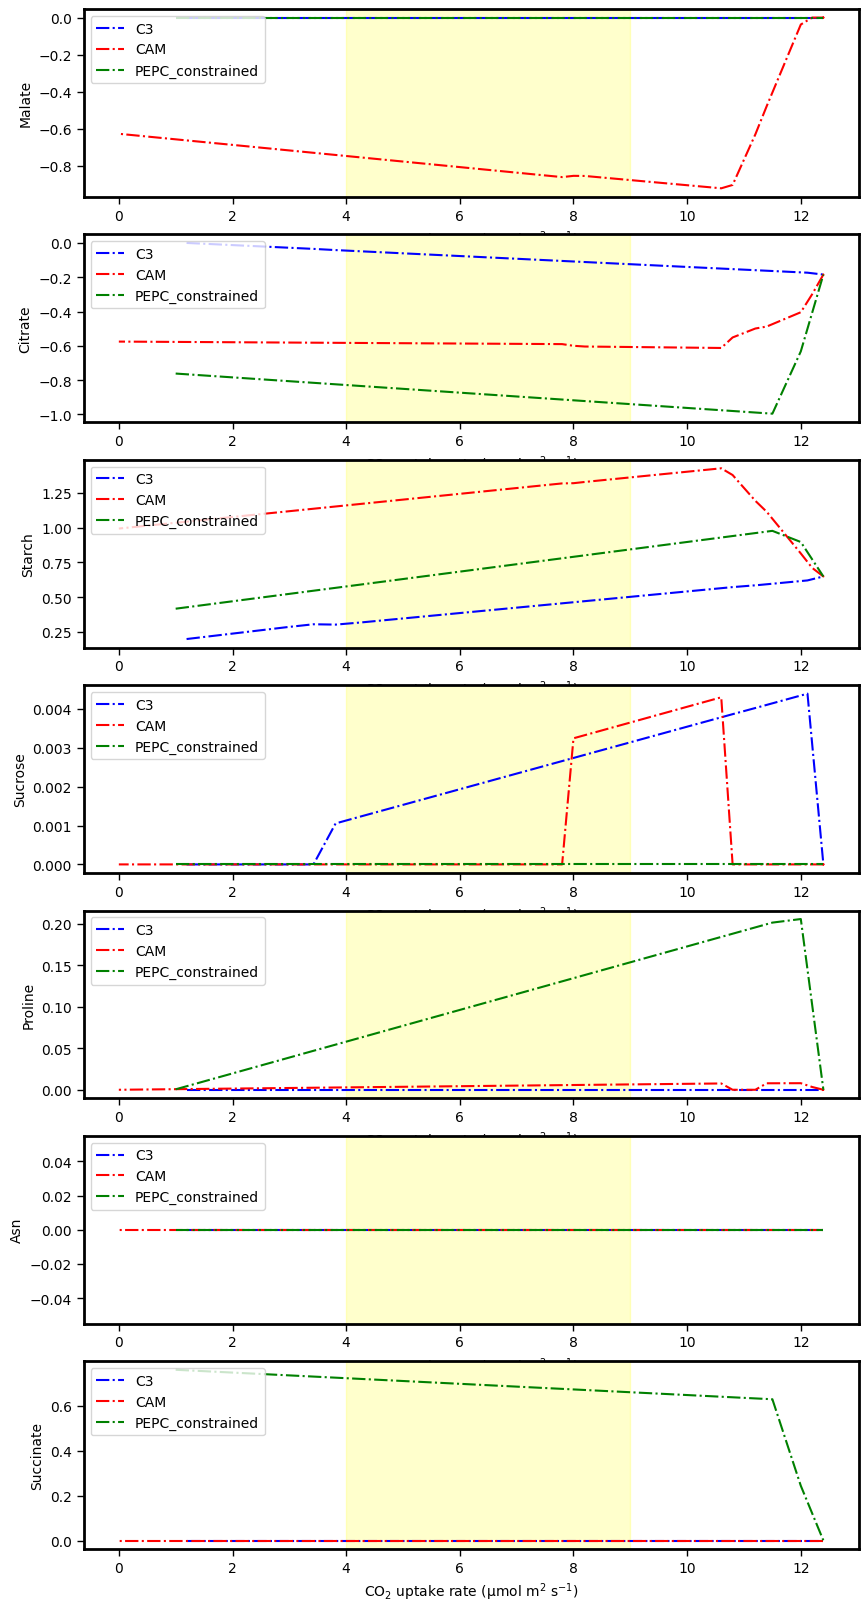

In [ ]:
x_axis = "CO2_tx_00"
x_axis_label = "CO$_{2}$ uptake rate (\u00B5mol m$^{2}$ s$^{-1}$)"
y_axes = ["MAL_v_linker_12_to_00", "CIT_v_linker_12_to_00", "STARCH_p_linker_00_to_12", "SUCROSE_v_linker_00_to_12", "PRO_v_linker_00_to_12", "ASN_v_linker_12_to_00", "SUC_v_linker_00_to_12"]
y_axes_labels = ["Malate", "Citrate", "Starch", "Sucrose", "Proline","Asn", "Succinate"]

import matplotlib.pyplot as plt
from scipy import stats

fig, axs = plt.subplots(nrows=len(y_axes), ncols=1, figsize=(10, 20))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']


for count, y_axis in enumerate(y_axes):
    
    
    for df, df_name in zip(df_list, df_name_list):
        # Assign colors to lines based on dataframe index
        color_index = df_name_list.index(df_name)
        color = colors[color_index % len(colors)]
    
        x1 = df.T[x_axis]
        x1 = x1.dropna()

        
        y1 = df.T[y_axis]
        y1 = y1.dropna()

        axs[count].plot(x1, y1, color=color, label=df_name, linestyle ="dashdot")

        # Calculate slope using linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(x1, y1)

        print(slope, intercept)

    axs[count].set_xlabel(x_axis_label)
    axs[count].set_ylabel(y_axes_labels[count])
    axs[count].legend(loc='upper left')
    # Highlight the region between 4 and 9 on the x-axis
    axs[count].axvspan(4, 9, alpha=0.2, color='yellow')

plt.legend(loc='upper left')
plt.show()


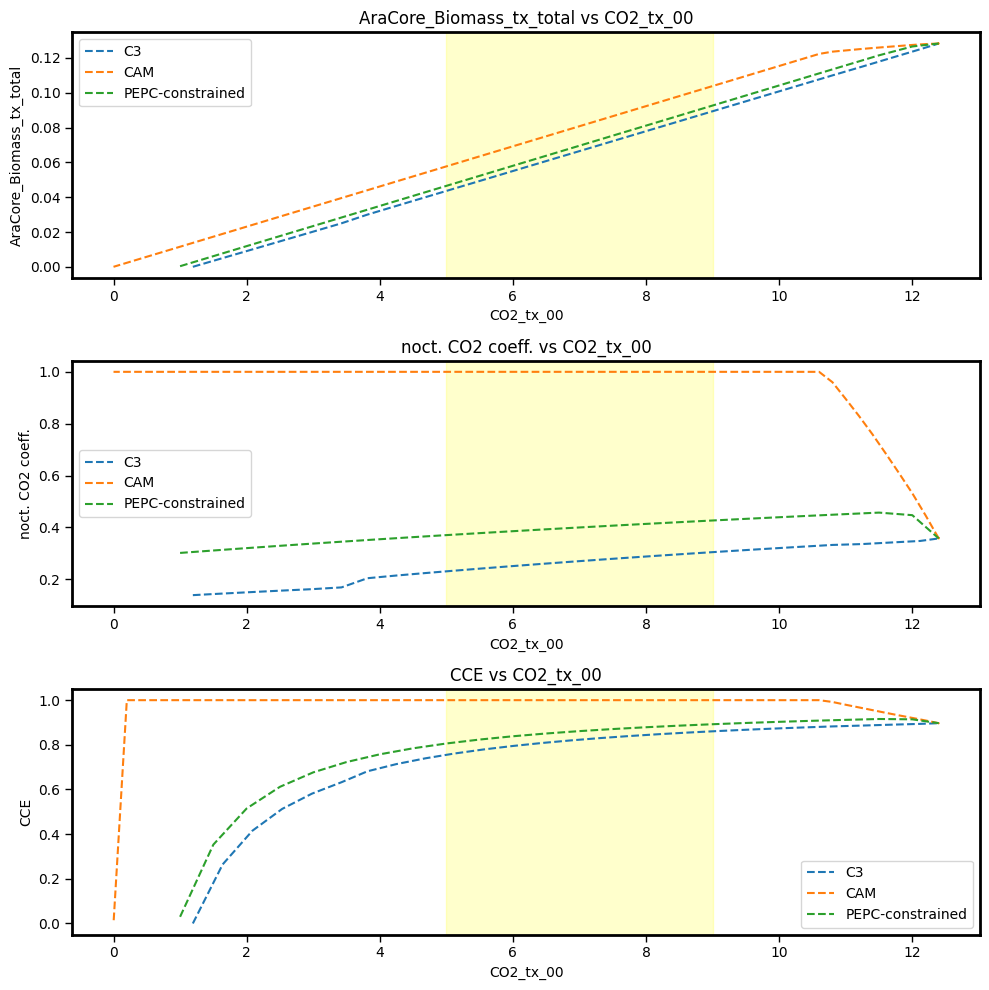

In [ ]:
import matplotlib.pyplot as plt

# rxn_list = ['AraCore_Biomass_tx_total', "ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12", "PEPCARBOX_RXN_c_12"] + list(df_A1.tail(10).index)
rxn_list = ['AraCore_Biomass_tx_total','noct. CO2 coeff.',
 'CCE',
#  'sum of fluxes',
#  'photon use'
#  ,"MAL_v_linker_12_to_00", "CIT_v_linker_12_to_00", "STARCH_p_linker_00_to_12"
 ]

fig, ax = plt.subplots(nrows=len(rxn_list), ncols=1, figsize=(10, 10))

for count, item in enumerate(rxn_list):
    df_A1.T.plot(x='CO2_tx_00', y=item, kind='line', style="--", ax=ax[count], label='C3')
    df_B1.T.plot(x='CO2_tx_00', y=item, kind='line', style="--", ax=ax[count], label='CAM')
    df_C1.T.plot(x='CO2_tx_00', y=item, kind='line', style="--", ax=ax[count], label='PEPC-constrained')
    

    # Highlight the region between 5 and 9 on the x-axis
    ax[count].axvspan(5, 9, alpha=0.2, color='yellow')

    ax[count].set_xlabel('CO2_tx_00')
    ax[count].set_ylabel(item)
    ax[count].set_title(item +' vs CO2_tx_00')
    ax[count].legend()

plt.tight_layout()
plt.show()

# Compare all the different scenarios

In [ ]:
df_name_list = ["CO2-onconstrained", "C3", "CAM-cycling", "PEPC-constrained"]

solutions = [solution_C3_unlimited, solution_C3, solution_CAM_cyc, solution_PEPC_const]

models = [C3_unlimited,C3_model_opt, CAM_cyc_model_opt, PEPC_const_model_opt]

metrics_df = create_dataframe(df_name_list, solutions, models)



CO2 daytime exchange: 12.397209573762565
CO2 nightime exchange: -1.2782184385959638
CO2 respiratory losses: 0 (no CO2_m_00 found)
Carbon day to night: 5.201828196217181
Carbon night to day: 1.14386197382954
CO2 exchange night:day: 0.2198961462551507
AraCore_Biomass_tx_00 carbon flux: -8.339243351374911
AraCore_Biomass_tx_12 carbon flux: -2.7797477837916365
total carbon biomass flux: -11.118991135166548
total CCE: 0.8968946656107852
nCO2RC: 0.35778238941665746
night CCE1 (carbon in to biomass): 0.5343790065602504
night CCE2 (1 - (carbon lost / carbon in)): 0.7542751528154089
CO2 daytime exchange: 6.643522352606437
CO2 nightime exchange: -1.2359151744723074
CO2 respiratory losses: 0 (no CO2_m_00 found)
Carbon day to night: 3.1379011228183975
Carbon night to day: 0.550084153812556
CO2 exchange night:day: 0.17530321456352388
AraCore_Biomass_tx_00 carbon flux: -4.05570538360061
AraCore_Biomass_tx_12 carbon flux: -1.3519017945335363
total carbon biomass flux: -5.407607178134146
total CCE: 0.

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarnin

Total: 1.9903198192197287
Total: 1.6783317382195344
Total: 1.9705533288938748
Total: 1.6032192888823205


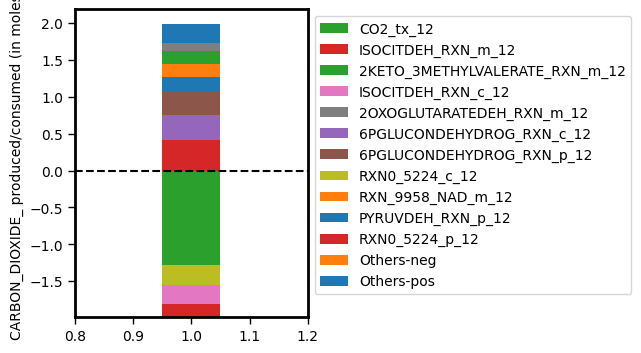

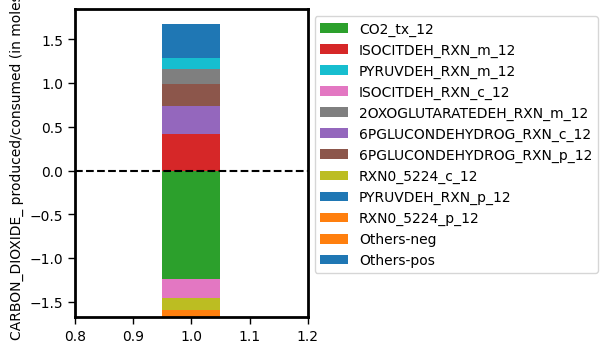

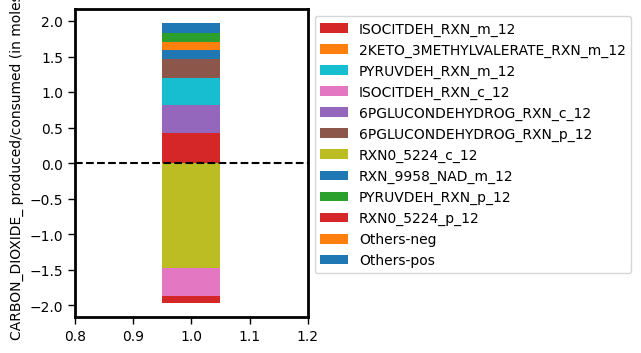

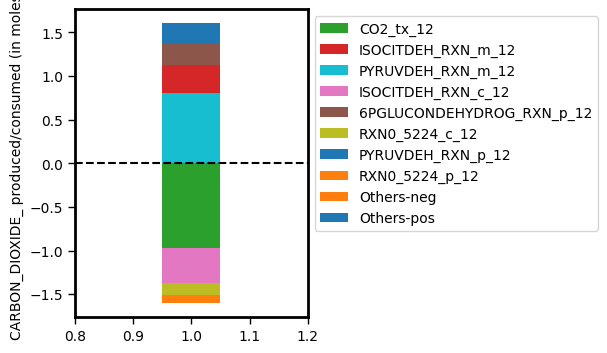

In [ ]:
CO2_models = {"CO2_unconstrained": [C3_unlimited_opt, solution_C3_unlimited],
              "CO2_indirect": [C3_model_opt, solution_C3],
              "CO2_direct": [CAM_cyc_model_opt, solution_CAM_cyc],
              "PEPC_limited": [PEPC_const_model_opt, solution_PEPC_const]}

df_CO2_models = pd.DataFrame()

for model_name, model in CO2_models.items():
    _, df_temp = generateMetaboliteBudget(model[0], model[1], show_plot=True, percentage=False, day_or_night_tag="_12", 
                         metabolite="CARBON_DIOXIDE_", threshold=0.05, colourDict=colourDict_CO2)
    
    df_CO2_models = df_CO2_models.combine_first(df_temp)
    
    df_CO2_models[model_name] = df_temp["value"]

 

In [ ]:

df_CO2_models

,CO2_direct,CO2_indirect,CO2_unconstrained,value,PEPC_limited
2KETO_3METHYLVALERATE_RXN_m_12,0.120290,NaN,1.758882e-01,1.758882e-01,NaN
2OXOGLUTARATEDEH_RXN_m_12,NaN,0.170889,1.062338e-01,1.062338e-01,NaN
6PGLUCONDEHYDROG_RXN_c_12,0.401194,0.319490,3.350001e-01,3.350001e-01,NaN
6PGLUCONDEHYDROG_RXN_p_12,0.267938,0.256522,3.091850e-01,3.091850e-01,0.259694
CO2_tx_12,NaN,-1.235915,-1.278218e+00,-1.278218e+00,-0.969965
ISOCITDEH_RXN_c_12,-0.391173,-0.221864,-2.594895e-01,-2.594895e-01,-0.397805
ISOCITDEH_RXN_m_12,0.418344,0.418344,4.183444e-01,4.183444e-01,0.313815
Others-neg,-0.004767,0.000000,-4.412519e-17,-4.412519e-17,-0.004071
Others-pos,0.144855,0.291668,2.603319e-01,2.603319e-01,0.121039
PYRUVDEH_RXN_m_12,0.379398,0.119556,NaN,1.195565e-01,0.807692


In [ ]:
import pandas as pd
from io import StringIO

# Define the data as a string
data = """
Reaction	CO$_2$ unconstrained	CO$_2$ direct constraint	CO$_2$ indirect constraint	PEPC limited
mito. 2-Keto-3-methyl-valerate DH	1.72E-01	0.12029	NaN	NaN
mito. 2-oxoglutarate DH	1.05E-01	NaN	0.171596	NaN
mito. Malonate-semialdehyde DH	1.72E-01	0.12029	NaN	NaN
cyt. PGD	3.38E-01	0.401194	0.321381	NaN
plastid PGD	3.09E-01	0.267938	0.256564	0.259727
cyt. ICDH	-2.70E-01	-0.391173	-0.225648	-0.397792
mito. ICDH	4.18E-01	0.418344	0.418344	0.313747
mito. PDH	NaN	0.379398	0.129246	0.808321
plastid PDH	2.09E-01	0.118245	0.101954	0.101046
cyto. CA	-2.80E-01	-1.471149	-0.136451	-0.147397
plastid CA	-1.73E-01	-0.103465	-0.084299	-0.088415
CO$_2$ exchange	-1.26E+00	NaN	-1.231074	-0.96628
Other consumers	-2.29E-17	-0.004767	0	-0.004074
Other producers	2.60E-01	0.144855	0.278386	0.121117
"""

# Convert the string data to a pandas DataFrame
df = pd.read_csv(StringIO(data), sep='\t')

# Set the "Reaction" column as the index
df.set_index('Reaction', inplace=True)

# Display the DataFrame
print(df)

                                   CO$_2$ unconstrained  \
Reaction                                                  
mito. 2-Keto-3-methyl-valerate DH          1.720000e-01   
mito. 2-oxoglutarate DH                    1.050000e-01   
mito. Malonate-semialdehyde DH             1.720000e-01   
cyt. PGD                                   3.380000e-01   
plastid PGD                                3.090000e-01   
cyt. ICDH                                 -2.700000e-01   
mito. ICDH                                 4.180000e-01   
mito. PDH                                           NaN   
plastid PDH                                2.090000e-01   
cyto. CA                                  -2.800000e-01   
plastid CA                                -1.730000e-01   
CO$_2$ exchange                           -1.260000e+00   
Other consumers                           -2.290000e-17   
Other producers                            2.600000e-01   

                                   CO$_2$ direct constr

In [ ]:
df

,CO$_2$ unconstrained,CO$_2$ direct constraint,CO$_2$ indirect constraint,PEPC limited
Reaction,,,,
mito. 2-Keto-3-methyl-valerate DH,1.720000e-01,0.120290,NaN,NaN
mito. 2-oxoglutarate DH,1.050000e-01,NaN,0.171596,NaN
mito. Malonate-semialdehyde DH,1.720000e-01,0.120290,NaN,NaN
cyt. PGD,3.380000e-01,0.401194,0.321381,NaN
plastid PGD,3.090000e-01,0.267938,0.256564,0.259727
cyt. ICDH,-2.700000e-01,-0.391173,-0.225648,-0.397792
mito. ICDH,4.180000e-01,0.418344,0.418344,0.313747
mito. PDH,NaN,0.379398,0.129246,0.808321
plastid PDH,2.090000e-01,0.118245,0.101954,0.101046


In [ ]:
import matplotlib.pyplot as plt

def generate_multiple_stacked_bars(df):
    df.plot(kind='bar', stacked=True)
    # plt.title('Nocturnal CO2 budget')
    plt.xlabel('Model iteration', fontsize=12)
    plt.ylabel('Flux ($\mu$mol m$^{-2}$ s$^{-1}$)', fontsize=12)
    # Rotate the x-axis labels slightly
    plt.xticks(rotation=45, ha='right')

    plt.legend(bbox_to_anchor=(1.65,0.9), loc='upper right')
    # Add a horizontal line at y=0
    plt.axhline(0, color='black') 

    # Set x-axis limits
    plt.ylim(-2.1, 2.1)

    plt.show()

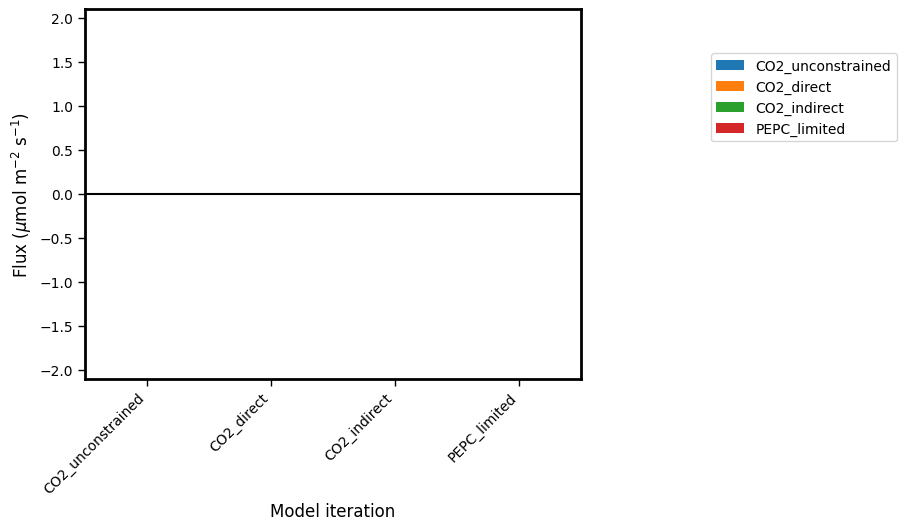

In [ ]:
df_CO2_models = df_CO2_models.T.reindex(['CO2_unconstrained', 'CO2_direct', 'CO2_indirect', "PEPC_limited"])

generate_multiple_stacked_bars(df_CO2_models)

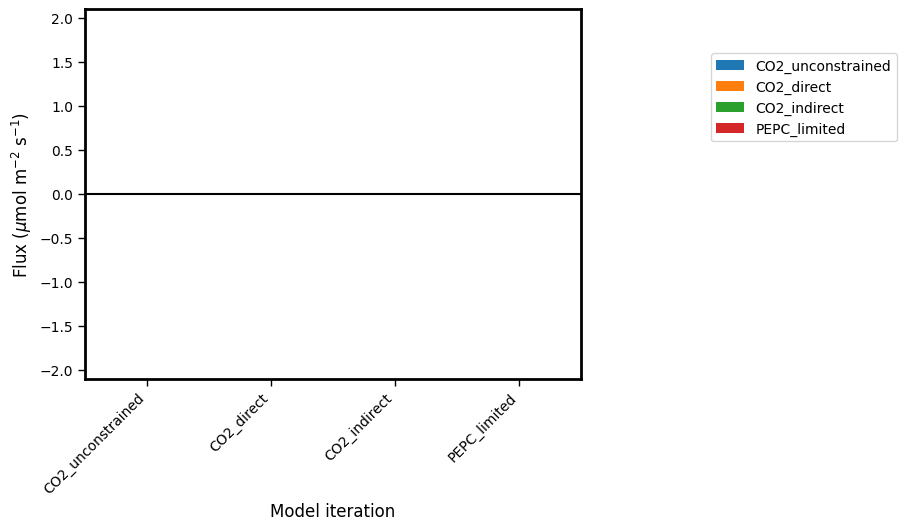

In [ ]:
df = df_CO2_models.T.reindex(['CO2_unconstrained', 'CO2_direct', 'CO2_indirect', "PEPC_limited"])

generate_multiple_stacked_bars(df)

In [ ]:
metrics_df

,C3,CAM-cycling,CO2-onconstrained,PEPC-constrained
% nCO2R,26.360496,1.000000e+02,35.778239,39.498934
CIT_v_linker_12_to_00,0.086600,5.877512e-01,0.184461,0.887366
CO2 daytime exchange,6.643522,6.643000e+00,12.397210,6.643000
CO2 exchange night:day,0.175303,8.044860e-01,0.219896,0.690341
CO2 nightime exchange,-1.235915,-3.412886e-13,-1.278218,-0.969965
Carbon day to night,3.137901,8.494275e+00,5.201828,7.712419
Carbon night to day,0.550084,6.833525e+00,1.143862,5.324196
MAL_v_linker_12_to_00,0.000000,8.267544e-01,0.000000,0.000000
Photon flux,111.328905,1.391162e+02,200.000000,122.340342
Rubisco flux,7.929695,9.792442e+00,14.785609,8.487407


# Fluxmaps data


In [ ]:
import pandas as pd

rxn_list = [
    "Photon_tx_00",
    "CO2_tx_00", "CO2_tx_12", 
    "AraCore_Biomass_tx_total", "AraCore_Biomass_tx_00", "AraCore_Biomass_tx_12", 
    "RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_00", "RXN_961_p_00",
    "STARCH_p_linker_00_to_12",
    "MAL_v_linker_00_to_12", "MAL_v_linker_12_to_00",
    "CIT_v_linker_12_to_00",
    "PEPCARBOX_RXN_c_12", "RXN0_5224_c_12", "RXN0_5224_p_12",
    "ISOCITDEH_RXN_c_12", "ISOCITDEH_RXN_x_12", "ISOCITDEH_RXN_m_12",
    "PYRUVDEH_RXN_m_12", "PYRUVDEH_RXN_p_12"
]

# List of models
models = {
    "Model_1": C3_unlimited_opt,
    "Model_2": C3_model_opt,
    "Model_3": CAM_cyc_model_opt,
    "Model_4": PEPC_const_model_opt,
}

# Define the min and max flux values
min_flux = 0.01
max_flux = 200

# Create an empty dictionary to store data for each model
data = {rxn: {"Reaction Name": None, "Reaction ID": None} for rxn in rxn_list}

# Loop through each model
for model_name, model in models.items():
    for rxn in rxn_list:
        reaction = model.reactions.get_by_id(rxn)
        flux = reaction.flux
        
        # Scale the thickness based on the flux
        if flux == 0:
            thickness = 0  # Set thickness to 0 if flux is 0
        else:
            thickness = 0.1 + (flux - min_flux) * (1 - 0.1) / (max_flux - min_flux)
        
        # Add data for this reaction and model
        if data[rxn]["Reaction Name"] is None:
            data[rxn]["Reaction Name"] = reaction.name
            data[rxn]["Reaction ID"] = reaction.id
        data[rxn][f"{model_name} Flux"] = flux
        data[rxn][f"{model_name} Thickness"] = thickness

# Convert the data dictionary into a pandas DataFrame
df_combined = pd.DataFrame.from_dict(data, orient="index").reset_index(drop=True)

# Display the combined DataFrame
# print(df_combined)

# Optionally, export the combined DataFrame to an Excel file
df_combined.to_excel("combined_reaction_data_columns.xlsx", index=False)

df_combined

,Reaction Name,Reaction ID,Model_1 Flux,Model_1 Thickness,Model_2 Flux,Model_2 Thickness,Model_3 Flux,Model_3 Thickness,Model_4 Flux,Model_4 Thickness
0,Photon_tx,Photon_tx_00,2.000000e+02,1.000000,111.328905,0.600960,1.391162e+02,0.726009,122.340342,0.650514
1,CO2_tx,CO2_tx_00,1.239721e+01,0.155745,6.643522,0.129852,6.643000e+00,0.129850,6.643000,0.129850
2,CO2_tx,CO2_tx_12,-1.278218e+00,0.094203,-1.235915,0.094393,-3.412886e-13,0.099955,-0.969965,0.095590
3,,AraCore_Biomass_tx_total,1.283260e-01,0.100532,0.062410,0.100236,7.666792e-02,0.100300,0.065473,0.100250
4,AraCoreBiomass,AraCore_Biomass_tx_00,9.624454e-02,0.100388,0.046808,0.100166,5.750094e-02,0.100214,0.049105,0.100176
5,AraCoreBiomass,AraCore_Biomass_tx_12,3.208151e-02,0.100099,0.015603,0.100025,1.916698e-02,0.100041,0.016368,0.100029
6,RIBULOSE-BISPHOSPHATE-CARBOXYLASE-RXN:Ribulose...,RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_00,1.478561e+01,0.166494,7.929695,0.135640,9.792442e+00,0.144023,8.487407,0.138150
7,RXN-961:NIL,RXN_961_p_00,4.928536e+00,0.122135,2.643232,0.111850,3.264147e+00,0.114644,2.829136,0.112687
8,STARCH_p_linker_day_to_night,STARCH_p_linker_00_to_12,6.488841e-01,0.102875,0.410670,0.101803,1.270200e+00,0.105671,0.717963,0.103186
9,MAL_v_linker_day_to_night,MAL_v_linker_00_to_12,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000


# Other Analysis (WIP)

In [ ]:
metrics_df.to_csv("baseline_model_analysis_metrics.csv")

# Making a plot of estimateOutput results

In [ ]:
sol, temp_model, df_eO = estimateOutputFromNetCO2_Corinna_dev(diel_model,6.643,Output_ID=output_string+"_total",
                                      Vc_ID="RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_00",
                                      CO2in_ID="CO2_tx_00",verbose=False, iterations=50, threshold=0.001, pFBA=True)

Model can achieve desired CO2 rate, without discouraging CO2 refixation.
0.07666792062071259
First optimisation (unconstrained CO2 uptake): Model is feasible.
Starting CO2 uptake = 12.397209573805899
Starting output flux: AraCore_Biomass_tx_total = 0.12832604692659602


---- CO2 adjustment iteration 1 ----
CCE: 89.69
Factor: 0.5358
prev: 0.12832604692659602
now: 0.06876304902794929
Optimisation successful.
---- CO2 adjustment iteration 2 ----
CCE: 82.77
Factor: 0.9228
prev: 0.06876304902794929
now: 0.06345691214211402
Optimisation successful.
---- CO2 adjustment iteration 3 ----
CCE: 81.64
Factor: 0.9863
prev: 0.06345691214211402
now: 0.06259038713410771
Optimisation successful.
---- CO2 adjustment iteration 4 ----
CCE: 81.44
Factor: 0.9976
prev: 0.06259038713410771
now: 0.06243742030777495
Optimisation successful.
---- CO2 adjustment iteration 5 ----
CCE: 81.4
Factor: 0.9996
prev: 0.06243742030777495
now: 0.06241005537877365
Optimisation successful.
Net CO2 uptake value achieved.



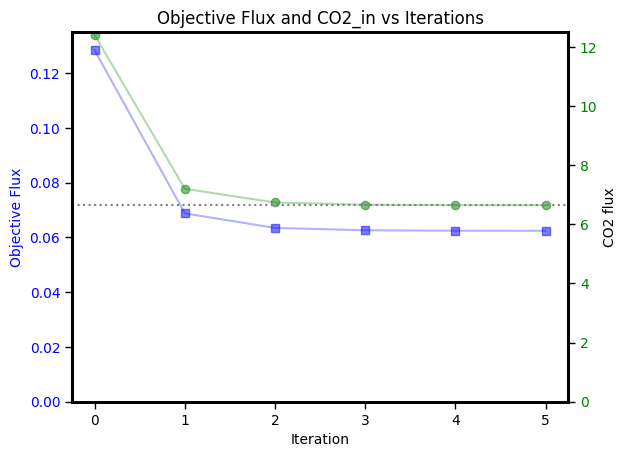

In [ ]:
plot_eO_iteration_results(df_eO)

In [ ]:
import numpy as np

# Define the flux range and arrow thickness range
flux_values = np.array([0.01, 0.1, 1, 10, 50, 100, 200])  # Example flux values
min_flux, max_flux = 0.01, 200  # Flux range
min_thickness, max_thickness = 0.2, 4  # Arrow thickness range

# Logarithmic scaling
log_flux = np.log10(flux_values)
log_min_flux, log_max_flux = np.log10(min_flux), np.log10(max_flux)

# Normalize log flux values to [0, 1]
normalized_flux = (log_flux - log_min_flux) / (log_max_flux - log_min_flux)

# Scale normalized values to [0.2, 4]
arrow_thicknesses = normalized_flux * (max_thickness - min_thickness) + min_thickness

# Print results
for flux, thickness in zip(flux_values, arrow_thicknesses):
    print(f"Flux: {flux}, Arrow Thickness: {thickness:.2f} mm")

Flux: 0.01, Arrow Thickness: 0.20 mm
Flux: 0.1, Arrow Thickness: 1.08 mm
Flux: 1.0, Arrow Thickness: 1.97 mm
Flux: 10.0, Arrow Thickness: 2.85 mm
Flux: 50.0, Arrow Thickness: 3.47 mm
Flux: 100.0, Arrow Thickness: 3.73 mm
Flux: 200.0, Arrow Thickness: 4.00 mm


In [ ]:
models = [C3_unlimited,CAM_cyc_model_opt, C3_model_opt,  PEPC_const_model_opt]

model = C3_model_opt
#

rxns = [
        "Photon_tx_00",
        "CO2_tx_00",
        "CO2_tx_12",
        "O2_tx_00",
        "O2_tx_12",
        "RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_00",
        "RXN_961_p_00",
        "STARCH_p_linker_00_to_12",
        "MAL_v_linker_00_to_12",
        "MAL_v_linker_12_to_00",
        "CIT_v_linker_00_to_12",
        "CIT_v_linker_12_to_00",
        "Nitrate_tx_00",
        "Nitrate_tx_12",
        "NITRATE_v_linker_12_to_00",
        "AraCore_Biomass_tx_00",
        "AraCore_Biomass_tx_12",
        "ATPase_tx_00",
        "PEPCARBOX_RXN_c_12",
        "PEPCARBOX_RXN_p_12",
        "RXN0_5224_c_12",
        "RXN0_5224_p_12",
        "PYRUVDEH_RXN_p_12",
        "PYRUVDEH_RXN_m_12",
        "ISOCITDEH_RXN_c_12",
        "ISOCITDEH_RXN_x_12",
        "ISOCITDEH_RXN_m_12",
        "Mitochondrial_ATP_Synthase_m_00",
        "Mitochondrial_ATP_Synthase_m_12",
        "PEPCARBOXYKIN_RXN_c_00",
        "ATP_CITRATE_PRO_S__LYASE_RXN_c_00",
        "ATP_CITRATE_PRO_S__LYASE_RXN_c_12",
        "CITSYN_RXN_m_12",
        "ACONITATEDEHYDR_RXN_c_12",
        "ACONITATEDEHYDR_RXN_c_00",
        "GLUTAMINESYN_RXN_p_00",
        "FERREDOXIN__NITRITE_REDUCTASE_RXN_p_00",
        "GCVMULTI_RXN_m_00",
        "Plastidial_ATP_Synthase_p_00",
        "PSII_RXN_p_00",
        "1.18.1.2_RXN_p_00",
        "NADH_DEHYDROG_A_RXN_mc_12",
        "GAPOXNPHOSPHN_RXN_c_12",
        "GAPOXNPHOSPHN_RXN_p_12",
        "GLU6PDEHYDROG_RXN_c_12",
        "GLU6PDEHYDROG_RXN_x_12",
        "GLU6PDEHYDROG_RXN_p_12",
        "6PGLUCONDEHYDROG_RXN_c_12",
        "6PGLUCONDEHYDROG_RXN_p_12",
        "6PGLUCONDEHYDROG_RXN_x_12",
        "2OXOGLUTARATEDEH_RXN_m_12",
        "MALIC_NADP_RXN_c_00"



]


for rxn in rxns:
        # print(rxn, "\t", round(model.reactions.get_by_id(rxn).flux, 4))
        print(round(model.reactions.get_by_id(rxn).flux, 4))

111.3289
6.6435
-1.2359
-8.0958
1.4269
7.9297
2.6432
0.4107
0.0
0.0
0.0
0.0866
0.2846
0.1898
0.1898
0.0468
0.0156
3.7651
0.1363
0.0
0.1363
0.0842
0.1019
0.1196
-0.2219
0.0
0.4183
1.7875
1.4985
0.0
0.0
0.0
0.2872
0.1965
0.0743
2.0222
0.4744
1.4738
12.0236
13.5819
23.7319
1.3482
0.3141
0.0857
0.3195
0.0
0.2565
0.3195
0.2565
0.0
0.1709
0.0427
